## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 8.62 and accuracy of 0.062
Iteration 100: with minibatch training loss = 1.11 and accuracy of 0.19
Iteration 200: with minibatch training loss = 0.793 and accuracy of 0.27
Iteration 300: with minibatch training loss = 0.679 and accuracy of 0.28
Iteration 400: with minibatch training loss = 0.602 and accuracy of 0.31
Iteration 500: with minibatch training loss = 0.486 and accuracy of 0.36
Iteration 600: with minibatch training loss = 0.503 and accuracy of 0.27
Iteration 700: with minibatch training loss = 0.533 and accuracy of 0.31
Epoch 1, Overall loss = 0.751 and accuracy of 0.309


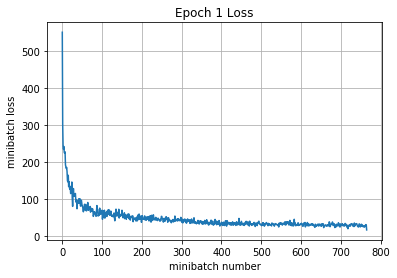

Validation
Epoch 1, Overall loss = 0.483 and accuracy of 0.338


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += float(np.sum(corr))
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
#                 print (float(np.sum(corr))/actual_batch_size)
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,float(np.sum(corr))/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    pass
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    beta1  = tf.get_variable("beta1",shape = [26,26,32]) # (32-7+1)/1 = 26
    gamma1 = tf.get_variable("gamma",shape = [26,26,32])
    Wfc1 = tf.get_variable("Wfc1",shape=[5408,1024])
    bfc1 = tf.get_variable("bfc1",shape=[1024])
    Wfc2 = tf.get_variable("Wfc2",shape=[1024,10])
    bfc2 = tf.get_variable("bfc2",shape=[10])    
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h2 = tf.layers.batch_normalization(h1,training=is_training)
    h3 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides= [1, 2, 2, 1], padding = 'SAME')
    h4 = tf.matmul(tf.reshape(h3, [-1, 13*13*32]), Wfc1) + bfc1
    h5 = tf.nn.relu(h4)
    y_out = tf.matmul(h5, Wfc2) + bfc2
    return y_out

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

100 loops, best of 3: 5.06 ms per loop
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

100 loops, best of 3: 5.11 ms per loop


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [8]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None
pass
total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
# total_loss= tf.losses.softmax_cross_entropy(tf.one_hot(y,10),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3) 

In [9]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.2 and accuracy of 0.19
Iteration 100: with minibatch training loss = 2.29 and accuracy of 0.34
Iteration 200: with minibatch training loss = 2.04 and accuracy of 0.31
Iteration 300: with minibatch training loss = 1.86 and accuracy of 0.39
Iteration 400: with minibatch training loss = 1.14 and accuracy of 0.7
Iteration 500: with minibatch training loss = 1.34 and accuracy of 0.47
Iteration 600: with minibatch training loss = 1.14 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.39 and accuracy of 0.48
Epoch 1, Overall loss = 1.69 and accuracy of 0.448


(1.6906566054675043, 0.4478367346938775)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [11]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.72 and accuracy of 0.479


(1.7184956817626953, 0.479)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [21]:
# Feel free to play with this cell
DROPOUT_RATE = 0.5
init = tf.contrib.layers.xavier_initializer()
def res_block(input_layer, i):
    with tf.variable_scope("res_block"+str(i)):
        res_conv1 = tf.layers.conv2d(input_layer, 96, kernel_size=3, strides=1, kernel_initializer=init, padding='SAME')
        res_bn1 = tf.layers.batch_normalization(res_conv1,training=is_training)
        res_conv2 = tf.layers.conv2d(tf.nn.relu(res_bn1), 96, kernel_size=3, strides=1, kernel_initializer=init, padding='SAME')
        res_bn2 = tf.layers.batch_normalization(res_conv2,training=is_training)
        res_out = tf.nn.relu(input_layer +  res_bn2)
    return res_out
        
def my_model(X,y,is_training):
    pass
    conv1 = tf.layers.conv2d(X, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn1 = tf.layers.batch_normalization(conv1,training=is_training)
    conv2 = tf.layers.conv2d(bn1, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn2 = tf.layers.batch_normalization(conv2,training=is_training)
    pool1 = tf.layers.max_pooling2d(bn2, pool_size=2, strides=2)
    dp1 = tf.layers.dropout(pool1, rate=DROPOUT_RATE, training=is_training)
    
    conv3 = tf.layers.conv2d(dp1, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn3 = tf.layers.batch_normalization(conv3,training=is_training)
    conv4 = tf.layers.conv2d(bn3, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn4 = tf.layers.batch_normalization(conv4,training=is_training)
    pool2 = tf.layers.max_pooling2d(bn4, pool_size=2, strides=2)
    dp2 = tf.layers.dropout(pool2, rate=DROPOUT_RATE, training=is_training)
    
    res_input = dp2
    for i in range(5):
        res_out = res_block(res_input, i)
    
    flatten = tf.reshape(res_out, [-1, 5*5*96])
    fc1 = tf.layers.dense(flatten, 384, activation=tf.nn.relu)
    fc_bn1 = tf.layers.batch_normalization(fc1,center=False,scale=False,training=is_training)
    fc_dp1 = tf.layers.dropout(fc_bn1, rate=DROPOUT_RATE, training=is_training)
    fc2 = tf.layers.dense(fc_dp1, 192, activation=tf.nn.relu)
    fc_bn2 = tf.layers.batch_normalization(fc2,center=False,scale=False,training=is_training)
    fc_dp2 = tf.layers.dropout(fc_bn2, rate=DROPOUT_RATE, training=is_training)
    fc3 = tf.layers.dense(fc_dp2, 10, activation=tf.nn.relu)
    fc_bn3 = tf.layers.batch_normalization(fc3,center=False,scale=False,training=is_training)
    return fc3
    
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None

total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
global_acc = tf.Variable(0, trainable=False, dtype=tf.float32)
learning_rate = tf.train.piecewise_constant(global_acc, [0.6, 0.7, 0.8, 0.9], [1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 3 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.52 and accuracy of 0.19
Iteration 200: with minibatch training loss = 2.56 and accuracy of 0.17
Iteration 300: with minibatch training loss = 2.43 and accuracy of 0.23
Iteration 400: with minibatch training loss = 2.56 and accuracy of 0.17
Iteration 500: with minibatch training loss = 2.37 and accuracy of 0.2
Iteration 600: with minibatch training loss = 2.55 and accuracy of 0.19
Iteration 700: with minibatch training loss = 2.37 and accuracy of 0.19
Epoch 1, Overall loss = 2.53 and accuracy of 0.202


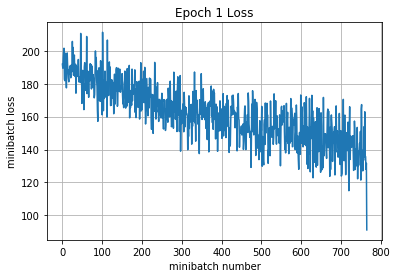

Iteration 800: with minibatch training loss = 2.06 and accuracy of 0.33
Iteration 900: with minibatch training loss = 2.46 and accuracy of 0.25
Iteration 1000: with minibatch training loss = 1.96 and accuracy of 0.38
Iteration 1100: with minibatch training loss = 2.16 and accuracy of 0.31
Iteration 1200: with minibatch training loss = 2.21 and accuracy of 0.22
Iteration 1300: with minibatch training loss = 1.75 and accuracy of 0.34
Iteration 1400: with minibatch training loss = 1.88 and accuracy of 0.36
Iteration 1500: with minibatch training loss = 2 and accuracy of 0.36
Epoch 2, Overall loss = 2.05 and accuracy of 0.316


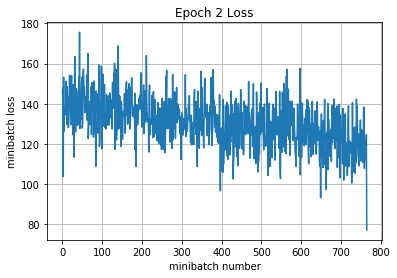

Iteration 1600: with minibatch training loss = 1.96 and accuracy of 0.39
Iteration 1700: with minibatch training loss = 2.18 and accuracy of 0.31
Iteration 1800: with minibatch training loss = 1.9 and accuracy of 0.33
Iteration 1900: with minibatch training loss = 1.72 and accuracy of 0.41
Iteration 2000: with minibatch training loss = 2.22 and accuracy of 0.31
Iteration 2100: with minibatch training loss = 1.97 and accuracy of 0.38
Iteration 2200: with minibatch training loss = 1.64 and accuracy of 0.41
Epoch 3, Overall loss = 1.81 and accuracy of 0.38


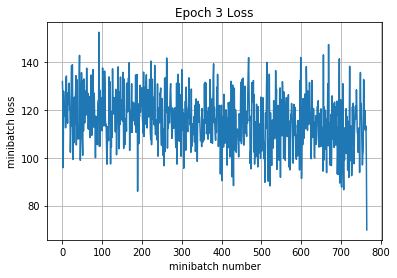

Iteration 2300: with minibatch training loss = 1.58 and accuracy of 0.47
Iteration 2400: with minibatch training loss = 1.6 and accuracy of 0.42
Iteration 2500: with minibatch training loss = 1.67 and accuracy of 0.48
Iteration 2600: with minibatch training loss = 1.8 and accuracy of 0.38
Iteration 2700: with minibatch training loss = 1.59 and accuracy of 0.47
Iteration 2800: with minibatch training loss = 1.46 and accuracy of 0.45
Iteration 2900: with minibatch training loss = 1.44 and accuracy of 0.52
Iteration 3000: with minibatch training loss = 1.29 and accuracy of 0.52
Epoch 4, Overall loss = 1.65 and accuracy of 0.431


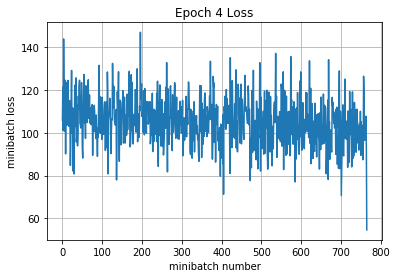

Iteration 3100: with minibatch training loss = 1.72 and accuracy of 0.33
Iteration 3200: with minibatch training loss = 1.25 and accuracy of 0.58
Iteration 3300: with minibatch training loss = 1.57 and accuracy of 0.45
Iteration 3400: with minibatch training loss = 1.44 and accuracy of 0.58
Iteration 3500: with minibatch training loss = 1.91 and accuracy of 0.38
Iteration 3600: with minibatch training loss = 1.93 and accuracy of 0.34
Iteration 3700: with minibatch training loss = 1.34 and accuracy of 0.59
Iteration 3800: with minibatch training loss = 1.48 and accuracy of 0.53
Epoch 5, Overall loss = 1.51 and accuracy of 0.479


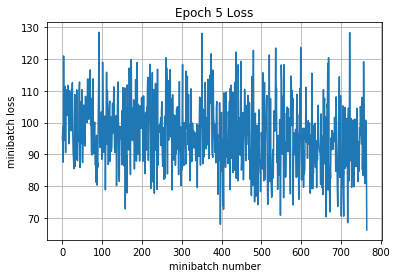

Iteration 3900: with minibatch training loss = 1.34 and accuracy of 0.52
Iteration 4000: with minibatch training loss = 1.17 and accuracy of 0.62
Iteration 4100: with minibatch training loss = 1.49 and accuracy of 0.5
Iteration 4200: with minibatch training loss = 1.28 and accuracy of 0.52
Iteration 4300: with minibatch training loss = 1.36 and accuracy of 0.53
Iteration 4400: with minibatch training loss = 1.45 and accuracy of 0.48
Iteration 4500: with minibatch training loss = 1.3 and accuracy of 0.5
Epoch 6, Overall loss = 1.39 and accuracy of 0.515


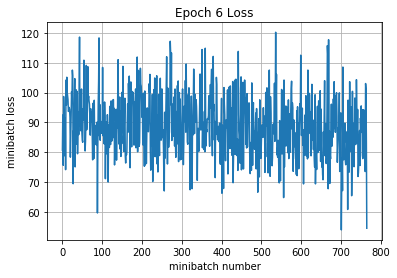

Iteration 4600: with minibatch training loss = 1.34 and accuracy of 0.52
Iteration 4700: with minibatch training loss = 1.15 and accuracy of 0.66
Iteration 4800: with minibatch training loss = 1.37 and accuracy of 0.55
Iteration 4900: with minibatch training loss = 1.15 and accuracy of 0.59
Iteration 5000: with minibatch training loss = 1.4 and accuracy of 0.47
Iteration 5100: with minibatch training loss = 1.41 and accuracy of 0.53
Iteration 5200: with minibatch training loss = 1.13 and accuracy of 0.66
Iteration 5300: with minibatch training loss = 1.13 and accuracy of 0.58
Epoch 7, Overall loss = 1.29 and accuracy of 0.551


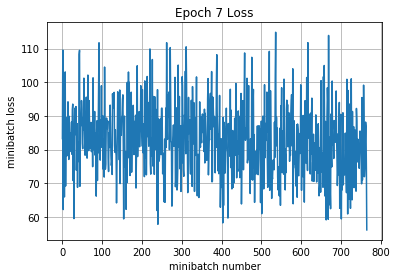

Iteration 5400: with minibatch training loss = 1.04 and accuracy of 0.69
Iteration 5500: with minibatch training loss = 1.2 and accuracy of 0.61
Iteration 5600: with minibatch training loss = 0.92 and accuracy of 0.67
Iteration 5700: with minibatch training loss = 1.32 and accuracy of 0.56
Iteration 5800: with minibatch training loss = 1.33 and accuracy of 0.61
Iteration 5900: with minibatch training loss = 1.47 and accuracy of 0.55
Iteration 6000: with minibatch training loss = 1.13 and accuracy of 0.59
Iteration 6100: with minibatch training loss = 1.12 and accuracy of 0.64
Epoch 8, Overall loss = 1.21 and accuracy of 0.579


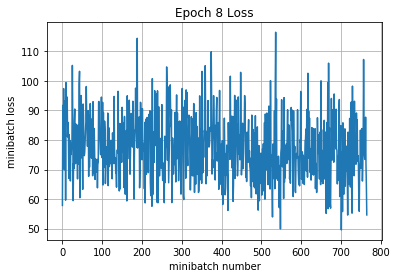

Iteration 6200: with minibatch training loss = 1.17 and accuracy of 0.52
Iteration 6300: with minibatch training loss = 1.35 and accuracy of 0.44
Iteration 6400: with minibatch training loss = 1.21 and accuracy of 0.52
Iteration 6500: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 6600: with minibatch training loss = 0.916 and accuracy of 0.73
Iteration 6700: with minibatch training loss = 0.932 and accuracy of 0.72
Iteration 6800: with minibatch training loss = 0.893 and accuracy of 0.67
Epoch 9, Overall loss = 1.13 and accuracy of 0.603


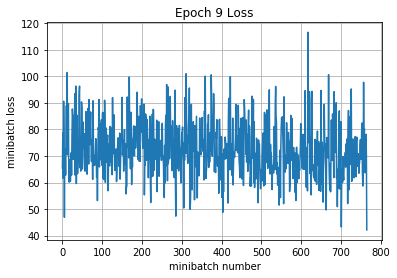

Iteration 6900: with minibatch training loss = 1.17 and accuracy of 0.58
Iteration 7000: with minibatch training loss = 1.14 and accuracy of 0.61
Iteration 7100: with minibatch training loss = 0.921 and accuracy of 0.67
Iteration 7200: with minibatch training loss = 1.07 and accuracy of 0.64
Iteration 7300: with minibatch training loss = 1.13 and accuracy of 0.55
Iteration 7400: with minibatch training loss = 1.03 and accuracy of 0.67
Iteration 7500: with minibatch training loss = 1.06 and accuracy of 0.64
Iteration 7600: with minibatch training loss = 0.91 and accuracy of 0.62
Epoch 10, Overall loss = 1.07 and accuracy of 0.627


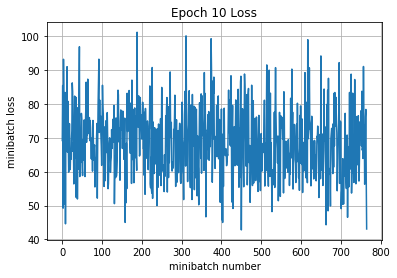

Iteration 7700: with minibatch training loss = 0.983 and accuracy of 0.69
Iteration 7800: with minibatch training loss = 0.987 and accuracy of 0.67
Iteration 7900: with minibatch training loss = 0.886 and accuracy of 0.7
Iteration 8000: with minibatch training loss = 1.01 and accuracy of 0.62
Iteration 8100: with minibatch training loss = 0.882 and accuracy of 0.7
Iteration 8200: with minibatch training loss = 0.906 and accuracy of 0.7
Iteration 8300: with minibatch training loss = 1.04 and accuracy of 0.58
Iteration 8400: with minibatch training loss = 0.964 and accuracy of 0.69
Epoch 11, Overall loss = 1.02 and accuracy of 0.645


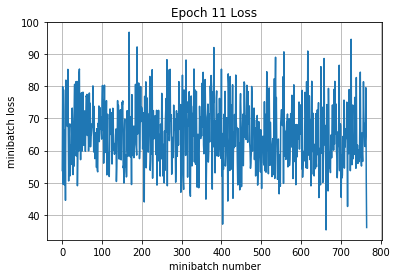

Iteration 8500: with minibatch training loss = 0.88 and accuracy of 0.73
Iteration 8600: with minibatch training loss = 0.742 and accuracy of 0.75
Iteration 8700: with minibatch training loss = 1.13 and accuracy of 0.59
Iteration 8800: with minibatch training loss = 1.09 and accuracy of 0.62
Iteration 8900: with minibatch training loss = 1.02 and accuracy of 0.66
Iteration 9000: with minibatch training loss = 1.23 and accuracy of 0.61
Iteration 9100: with minibatch training loss = 0.635 and accuracy of 0.83
Epoch 12, Overall loss = 0.971 and accuracy of 0.664


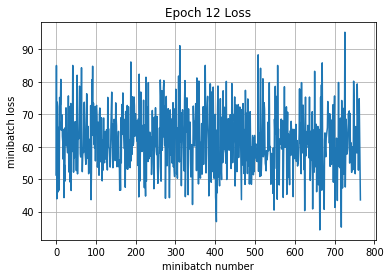

Iteration 9200: with minibatch training loss = 0.689 and accuracy of 0.75
Iteration 9300: with minibatch training loss = 0.738 and accuracy of 0.83
Iteration 9400: with minibatch training loss = 0.798 and accuracy of 0.66
Iteration 9500: with minibatch training loss = 1.13 and accuracy of 0.61
Iteration 9600: with minibatch training loss = 0.814 and accuracy of 0.73
Iteration 9700: with minibatch training loss = 1.2 and accuracy of 0.62
Iteration 9800: with minibatch training loss = 0.799 and accuracy of 0.77
Iteration 9900: with minibatch training loss = 0.798 and accuracy of 0.72
Epoch 13, Overall loss = 0.929 and accuracy of 0.681


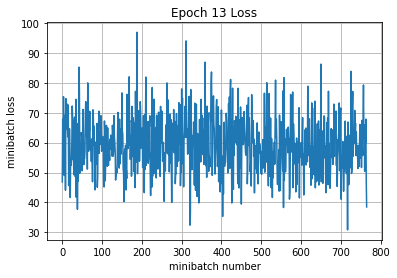

Iteration 10000: with minibatch training loss = 1.24 and accuracy of 0.58
Iteration 10100: with minibatch training loss = 0.815 and accuracy of 0.77
Iteration 10200: with minibatch training loss = 1 and accuracy of 0.69
Iteration 10300: with minibatch training loss = 0.718 and accuracy of 0.75
Iteration 10400: with minibatch training loss = 0.91 and accuracy of 0.73
Iteration 10500: with minibatch training loss = 0.924 and accuracy of 0.67
Iteration 10600: with minibatch training loss = 0.788 and accuracy of 0.67
Iteration 10700: with minibatch training loss = 0.773 and accuracy of 0.75
Epoch 14, Overall loss = 0.892 and accuracy of 0.692


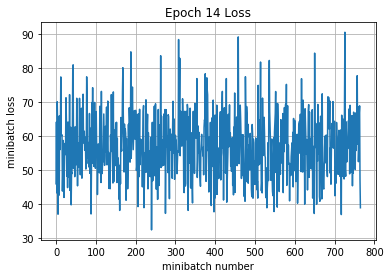

Iteration 10800: with minibatch training loss = 0.828 and accuracy of 0.77
Iteration 10900: with minibatch training loss = 0.68 and accuracy of 0.8
Iteration 11000: with minibatch training loss = 0.929 and accuracy of 0.7
Iteration 11100: with minibatch training loss = 0.839 and accuracy of 0.7
Iteration 11200: with minibatch training loss = 0.965 and accuracy of 0.67
Iteration 11300: with minibatch training loss = 0.944 and accuracy of 0.73
Iteration 11400: with minibatch training loss = 0.878 and accuracy of 0.72
Epoch 15, Overall loss = 0.856 and accuracy of 0.706


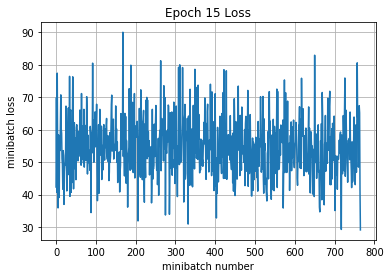

Iteration 11500: with minibatch training loss = 1.04 and accuracy of 0.66
Iteration 11600: with minibatch training loss = 0.934 and accuracy of 0.67
Iteration 11700: with minibatch training loss = 1.18 and accuracy of 0.59
Iteration 11800: with minibatch training loss = 0.801 and accuracy of 0.66
Iteration 11900: with minibatch training loss = 0.799 and accuracy of 0.72
Iteration 12000: with minibatch training loss = 0.938 and accuracy of 0.62
Iteration 12100: with minibatch training loss = 1.06 and accuracy of 0.61
Iteration 12200: with minibatch training loss = 0.76 and accuracy of 0.81
Epoch 16, Overall loss = 0.829 and accuracy of 0.713


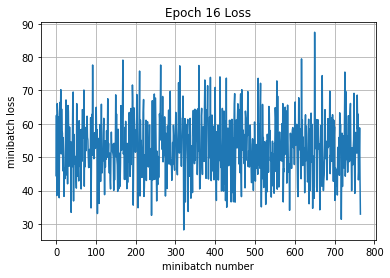

Iteration 12300: with minibatch training loss = 0.798 and accuracy of 0.69
Iteration 12400: with minibatch training loss = 0.858 and accuracy of 0.67
Iteration 12500: with minibatch training loss = 0.657 and accuracy of 0.78
Iteration 12600: with minibatch training loss = 0.619 and accuracy of 0.78
Iteration 12700: with minibatch training loss = 0.505 and accuracy of 0.8
Iteration 12800: with minibatch training loss = 0.889 and accuracy of 0.7
Iteration 12900: with minibatch training loss = 0.835 and accuracy of 0.62
Iteration 13000: with minibatch training loss = 0.771 and accuracy of 0.78
Epoch 17, Overall loss = 0.804 and accuracy of 0.722


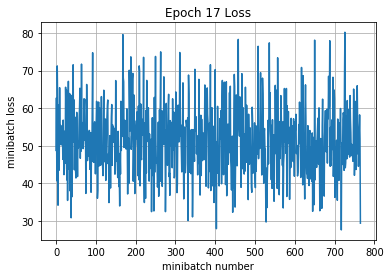

Iteration 13100: with minibatch training loss = 0.821 and accuracy of 0.72
Iteration 13200: with minibatch training loss = 0.723 and accuracy of 0.75
Iteration 13300: with minibatch training loss = 0.631 and accuracy of 0.7
Iteration 13400: with minibatch training loss = 0.8 and accuracy of 0.7
Iteration 13500: with minibatch training loss = 0.745 and accuracy of 0.69
Iteration 13600: with minibatch training loss = 0.675 and accuracy of 0.8
Iteration 13700: with minibatch training loss = 0.788 and accuracy of 0.78
Epoch 18, Overall loss = 0.771 and accuracy of 0.734


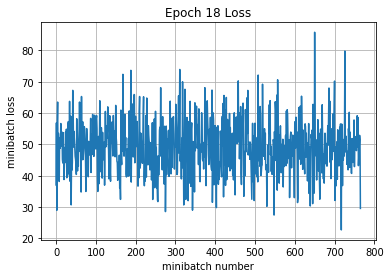

Iteration 13800: with minibatch training loss = 0.979 and accuracy of 0.72
Iteration 13900: with minibatch training loss = 0.715 and accuracy of 0.8
Iteration 14000: with minibatch training loss = 0.837 and accuracy of 0.7
Iteration 14100: with minibatch training loss = 0.743 and accuracy of 0.72
Iteration 14200: with minibatch training loss = 0.834 and accuracy of 0.73
Iteration 14300: with minibatch training loss = 0.684 and accuracy of 0.75
Iteration 14400: with minibatch training loss = 0.933 and accuracy of 0.66
Iteration 14500: with minibatch training loss = 0.621 and accuracy of 0.75
Epoch 19, Overall loss = 0.753 and accuracy of 0.739


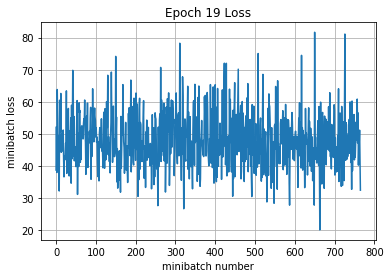

Iteration 14600: with minibatch training loss = 0.719 and accuracy of 0.78
Iteration 14700: with minibatch training loss = 0.673 and accuracy of 0.73
Iteration 14800: with minibatch training loss = 0.54 and accuracy of 0.83
Iteration 14900: with minibatch training loss = 0.719 and accuracy of 0.77
Iteration 15000: with minibatch training loss = 0.438 and accuracy of 0.83
Iteration 15100: with minibatch training loss = 0.671 and accuracy of 0.75
Iteration 15200: with minibatch training loss = 0.758 and accuracy of 0.7
Iteration 15300: with minibatch training loss = 0.733 and accuracy of 0.8
Epoch 20, Overall loss = 0.734 and accuracy of 0.748


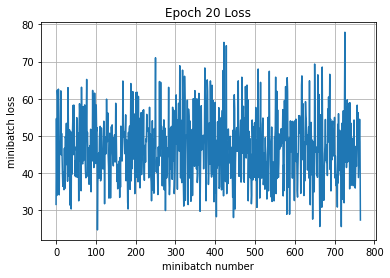

Iteration 15400: with minibatch training loss = 0.607 and accuracy of 0.8
Iteration 15500: with minibatch training loss = 0.606 and accuracy of 0.81
Iteration 15600: with minibatch training loss = 0.758 and accuracy of 0.8
Iteration 15700: with minibatch training loss = 0.924 and accuracy of 0.67
Iteration 15800: with minibatch training loss = 0.794 and accuracy of 0.72
Iteration 15900: with minibatch training loss = 0.523 and accuracy of 0.77
Iteration 16000: with minibatch training loss = 0.787 and accuracy of 0.72
Epoch 21, Overall loss = 0.71 and accuracy of 0.758


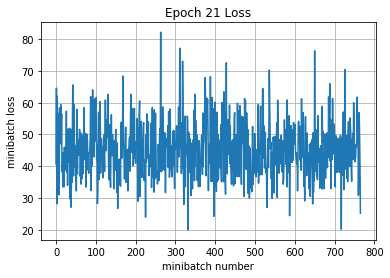

Iteration 16100: with minibatch training loss = 0.724 and accuracy of 0.75
Iteration 16200: with minibatch training loss = 0.805 and accuracy of 0.7
Iteration 16300: with minibatch training loss = 0.715 and accuracy of 0.78
Iteration 16400: with minibatch training loss = 0.66 and accuracy of 0.75
Iteration 16500: with minibatch training loss = 0.655 and accuracy of 0.81
Iteration 16600: with minibatch training loss = 1.04 and accuracy of 0.66
Iteration 16700: with minibatch training loss = 0.728 and accuracy of 0.78
Iteration 16800: with minibatch training loss = 0.73 and accuracy of 0.72
Epoch 22, Overall loss = 0.69 and accuracy of 0.764


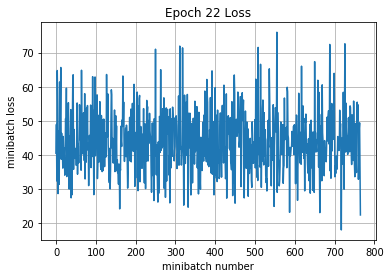

Iteration 16900: with minibatch training loss = 0.631 and accuracy of 0.81
Iteration 17000: with minibatch training loss = 0.678 and accuracy of 0.77
Iteration 17100: with minibatch training loss = 0.557 and accuracy of 0.75
Iteration 17200: with minibatch training loss = 0.503 and accuracy of 0.8
Iteration 17300: with minibatch training loss = 0.863 and accuracy of 0.73
Iteration 17400: with minibatch training loss = 0.417 and accuracy of 0.89
Iteration 17500: with minibatch training loss = 0.706 and accuracy of 0.7
Iteration 17600: with minibatch training loss = 0.79 and accuracy of 0.78
Epoch 23, Overall loss = 0.673 and accuracy of 0.769


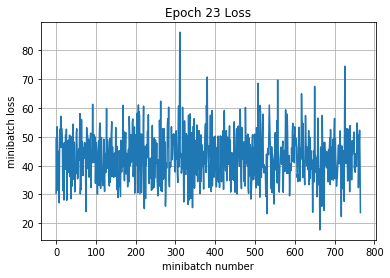

Iteration 17700: with minibatch training loss = 0.62 and accuracy of 0.78
Iteration 17800: with minibatch training loss = 0.715 and accuracy of 0.8
Iteration 17900: with minibatch training loss = 0.651 and accuracy of 0.8
Iteration 18000: with minibatch training loss = 0.651 and accuracy of 0.83
Iteration 18100: with minibatch training loss = 0.734 and accuracy of 0.73
Iteration 18200: with minibatch training loss = 0.877 and accuracy of 0.66
Iteration 18300: with minibatch training loss = 0.664 and accuracy of 0.78
Epoch 24, Overall loss = 0.659 and accuracy of 0.772


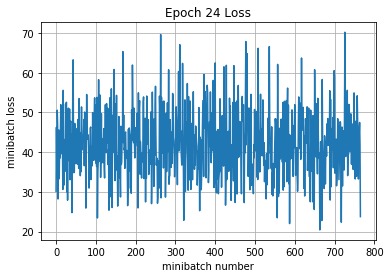

Iteration 18400: with minibatch training loss = 0.659 and accuracy of 0.83
Iteration 18500: with minibatch training loss = 0.636 and accuracy of 0.73
Iteration 18600: with minibatch training loss = 0.502 and accuracy of 0.86
Iteration 18700: with minibatch training loss = 0.569 and accuracy of 0.78
Iteration 18800: with minibatch training loss = 0.619 and accuracy of 0.8
Iteration 18900: with minibatch training loss = 0.626 and accuracy of 0.81
Iteration 19000: with minibatch training loss = 0.727 and accuracy of 0.77
Iteration 19100: with minibatch training loss = 0.651 and accuracy of 0.69
Epoch 25, Overall loss = 0.646 and accuracy of 0.781


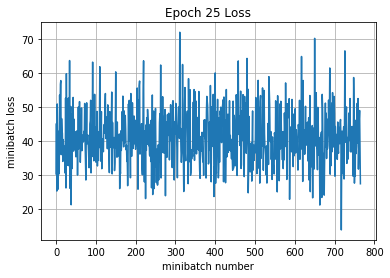

Iteration 19200: with minibatch training loss = 0.582 and accuracy of 0.78
Iteration 19300: with minibatch training loss = 0.726 and accuracy of 0.81
Iteration 19400: with minibatch training loss = 0.796 and accuracy of 0.67
Iteration 19500: with minibatch training loss = 0.573 and accuracy of 0.83
Iteration 19600: with minibatch training loss = 0.382 and accuracy of 0.83
Iteration 19700: with minibatch training loss = 0.638 and accuracy of 0.73
Iteration 19800: with minibatch training loss = 0.996 and accuracy of 0.69
Iteration 19900: with minibatch training loss = 0.503 and accuracy of 0.84
Epoch 26, Overall loss = 0.628 and accuracy of 0.785


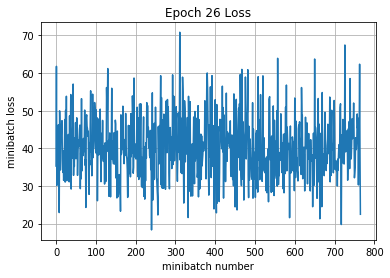

Iteration 20000: with minibatch training loss = 0.619 and accuracy of 0.77
Iteration 20100: with minibatch training loss = 0.771 and accuracy of 0.77
Iteration 20200: with minibatch training loss = 0.524 and accuracy of 0.81
Iteration 20300: with minibatch training loss = 0.564 and accuracy of 0.81
Iteration 20400: with minibatch training loss = 0.52 and accuracy of 0.83
Iteration 20500: with minibatch training loss = 0.584 and accuracy of 0.81
Iteration 20600: with minibatch training loss = 0.593 and accuracy of 0.77
Epoch 27, Overall loss = 0.617 and accuracy of 0.789


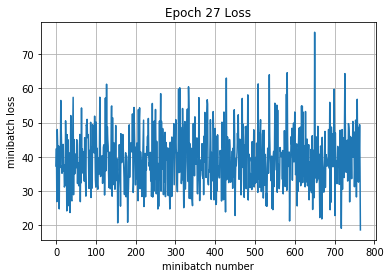

Iteration 20700: with minibatch training loss = 0.517 and accuracy of 0.78
Iteration 20800: with minibatch training loss = 0.441 and accuracy of 0.88
Iteration 20900: with minibatch training loss = 0.532 and accuracy of 0.83
Iteration 21000: with minibatch training loss = 0.742 and accuracy of 0.75
Iteration 21100: with minibatch training loss = 0.688 and accuracy of 0.78
Iteration 21200: with minibatch training loss = 0.542 and accuracy of 0.8
Iteration 21300: with minibatch training loss = 0.522 and accuracy of 0.8
Iteration 21400: with minibatch training loss = 0.587 and accuracy of 0.78
Epoch 28, Overall loss = 0.598 and accuracy of 0.797


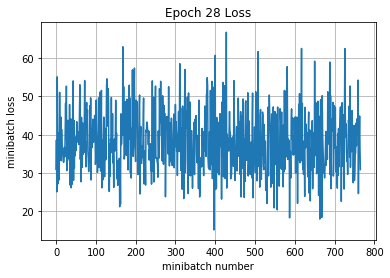

Iteration 21500: with minibatch training loss = 0.776 and accuracy of 0.72
Iteration 21600: with minibatch training loss = 0.688 and accuracy of 0.77
Iteration 21700: with minibatch training loss = 0.399 and accuracy of 0.88
Iteration 21800: with minibatch training loss = 0.711 and accuracy of 0.73
Iteration 21900: with minibatch training loss = 0.692 and accuracy of 0.72
Iteration 22000: with minibatch training loss = 0.711 and accuracy of 0.72
Iteration 22100: with minibatch training loss = 0.72 and accuracy of 0.73
Iteration 22200: with minibatch training loss = 0.471 and accuracy of 0.78
Epoch 29, Overall loss = 0.583 and accuracy of 0.799


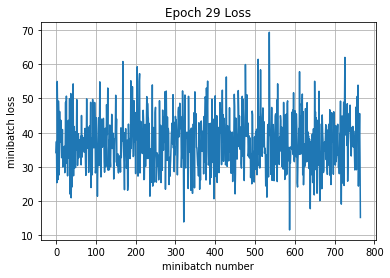

Iteration 22300: with minibatch training loss = 0.591 and accuracy of 0.8
Iteration 22400: with minibatch training loss = 0.494 and accuracy of 0.83
Iteration 22500: with minibatch training loss = 0.63 and accuracy of 0.78
Iteration 22600: with minibatch training loss = 0.552 and accuracy of 0.8
Iteration 22700: with minibatch training loss = 0.546 and accuracy of 0.83
Iteration 22800: with minibatch training loss = 0.76 and accuracy of 0.75
Iteration 22900: with minibatch training loss = 0.634 and accuracy of 0.8
Epoch 30, Overall loss = 0.573 and accuracy of 0.805


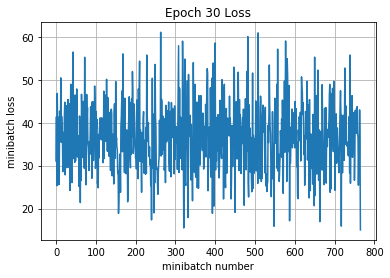

Iteration 23000: with minibatch training loss = 0.456 and accuracy of 0.84
Iteration 23100: with minibatch training loss = 0.714 and accuracy of 0.81
Iteration 23200: with minibatch training loss = 0.834 and accuracy of 0.67
Iteration 23300: with minibatch training loss = 0.362 and accuracy of 0.92
Iteration 23400: with minibatch training loss = 0.757 and accuracy of 0.77
Iteration 23500: with minibatch training loss = 0.493 and accuracy of 0.81
Iteration 23600: with minibatch training loss = 0.403 and accuracy of 0.91
Iteration 23700: with minibatch training loss = 0.478 and accuracy of 0.84
Epoch 31, Overall loss = 0.559 and accuracy of 0.811


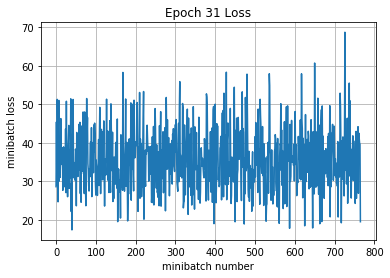

Iteration 23800: with minibatch training loss = 0.492 and accuracy of 0.83
Iteration 23900: with minibatch training loss = 0.541 and accuracy of 0.86
Iteration 24000: with minibatch training loss = 0.394 and accuracy of 0.86
Iteration 24100: with minibatch training loss = 0.532 and accuracy of 0.8
Iteration 24200: with minibatch training loss = 0.499 and accuracy of 0.86
Iteration 24300: with minibatch training loss = 0.473 and accuracy of 0.8
Iteration 24400: with minibatch training loss = 0.573 and accuracy of 0.8
Iteration 24500: with minibatch training loss = 0.592 and accuracy of 0.84
Epoch 32, Overall loss = 0.549 and accuracy of 0.813


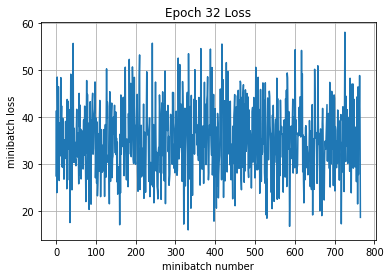

Iteration 24600: with minibatch training loss = 0.468 and accuracy of 0.84
Iteration 24700: with minibatch training loss = 0.508 and accuracy of 0.83
Iteration 24800: with minibatch training loss = 0.486 and accuracy of 0.83
Iteration 24900: with minibatch training loss = 0.648 and accuracy of 0.8
Iteration 25000: with minibatch training loss = 0.363 and accuracy of 0.89
Iteration 25100: with minibatch training loss = 0.518 and accuracy of 0.8
Iteration 25200: with minibatch training loss = 0.849 and accuracy of 0.75
Epoch 33, Overall loss = 0.534 and accuracy of 0.819


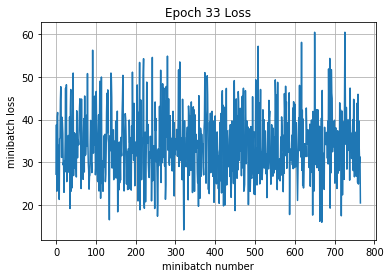

Iteration 25300: with minibatch training loss = 0.418 and accuracy of 0.88
Iteration 25400: with minibatch training loss = 0.373 and accuracy of 0.89
Iteration 25500: with minibatch training loss = 0.335 and accuracy of 0.91
Iteration 25600: with minibatch training loss = 0.404 and accuracy of 0.89
Iteration 25700: with minibatch training loss = 0.707 and accuracy of 0.7
Iteration 25800: with minibatch training loss = 0.381 and accuracy of 0.88
Iteration 25900: with minibatch training loss = 0.547 and accuracy of 0.8
Iteration 26000: with minibatch training loss = 0.428 and accuracy of 0.84
Epoch 34, Overall loss = 0.523 and accuracy of 0.824


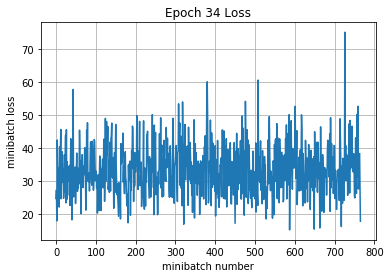

Iteration 26100: with minibatch training loss = 0.564 and accuracy of 0.78
Iteration 26200: with minibatch training loss = 0.453 and accuracy of 0.86
Iteration 26300: with minibatch training loss = 0.317 and accuracy of 0.86
Iteration 26400: with minibatch training loss = 0.528 and accuracy of 0.86
Iteration 26500: with minibatch training loss = 0.562 and accuracy of 0.8
Iteration 26600: with minibatch training loss = 0.425 and accuracy of 0.88
Iteration 26700: with minibatch training loss = 0.444 and accuracy of 0.88
Iteration 26800: with minibatch training loss = 0.558 and accuracy of 0.83
Epoch 35, Overall loss = 0.517 and accuracy of 0.823


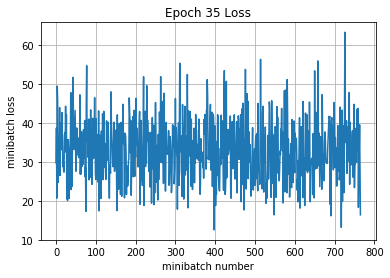

Iteration 26900: with minibatch training loss = 0.414 and accuracy of 0.88
Iteration 27000: with minibatch training loss = 0.55 and accuracy of 0.8
Iteration 27100: with minibatch training loss = 0.528 and accuracy of 0.8
Iteration 27200: with minibatch training loss = 0.366 and accuracy of 0.88
Iteration 27300: with minibatch training loss = 0.494 and accuracy of 0.81
Iteration 27400: with minibatch training loss = 0.502 and accuracy of 0.83
Iteration 27500: with minibatch training loss = 0.621 and accuracy of 0.81
Epoch 36, Overall loss = 0.505 and accuracy of 0.827


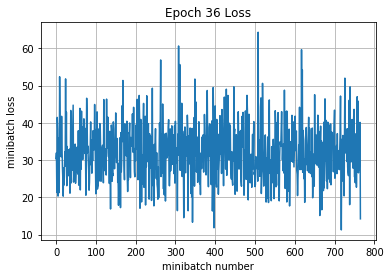

Iteration 27600: with minibatch training loss = 0.681 and accuracy of 0.83
Iteration 27700: with minibatch training loss = 0.513 and accuracy of 0.83
Iteration 27800: with minibatch training loss = 0.541 and accuracy of 0.73
Iteration 27900: with minibatch training loss = 0.64 and accuracy of 0.78
Iteration 28000: with minibatch training loss = 0.535 and accuracy of 0.83
Iteration 28100: with minibatch training loss = 0.437 and accuracy of 0.88
Iteration 28200: with minibatch training loss = 0.645 and accuracy of 0.73
Iteration 28300: with minibatch training loss = 0.362 and accuracy of 0.89
Epoch 37, Overall loss = 0.497 and accuracy of 0.832


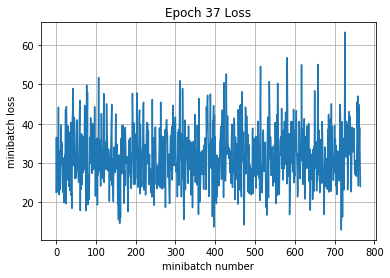

Iteration 28400: with minibatch training loss = 0.496 and accuracy of 0.84
Iteration 28500: with minibatch training loss = 0.388 and accuracy of 0.88
Iteration 28600: with minibatch training loss = 0.321 and accuracy of 0.91
Iteration 28700: with minibatch training loss = 0.283 and accuracy of 0.91
Iteration 28800: with minibatch training loss = 0.485 and accuracy of 0.84
Iteration 28900: with minibatch training loss = 0.382 and accuracy of 0.88
Iteration 29000: with minibatch training loss = 0.704 and accuracy of 0.75
Iteration 29100: with minibatch training loss = 0.451 and accuracy of 0.83
Epoch 38, Overall loss = 0.489 and accuracy of 0.833


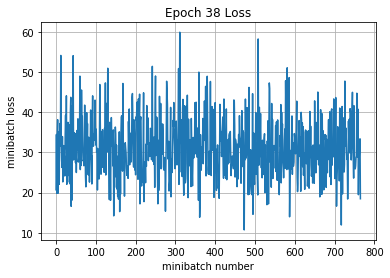

Iteration 29200: with minibatch training loss = 0.532 and accuracy of 0.83
Iteration 29300: with minibatch training loss = 0.583 and accuracy of 0.83
Iteration 29400: with minibatch training loss = 0.499 and accuracy of 0.84
Iteration 29500: with minibatch training loss = 0.62 and accuracy of 0.78
Iteration 29600: with minibatch training loss = 0.426 and accuracy of 0.84
Iteration 29700: with minibatch training loss = 0.606 and accuracy of 0.8
Iteration 29800: with minibatch training loss = 0.531 and accuracy of 0.84
Epoch 39, Overall loss = 0.475 and accuracy of 0.839


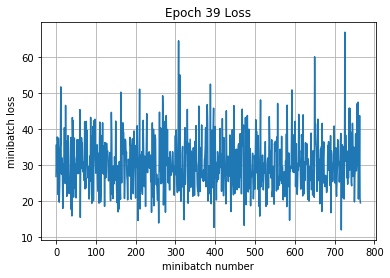

Iteration 29900: with minibatch training loss = 0.579 and accuracy of 0.78
Iteration 30000: with minibatch training loss = 0.525 and accuracy of 0.84
Iteration 30100: with minibatch training loss = 0.525 and accuracy of 0.84
Iteration 30200: with minibatch training loss = 0.369 and accuracy of 0.83
Iteration 30300: with minibatch training loss = 0.395 and accuracy of 0.88
Iteration 30400: with minibatch training loss = 0.533 and accuracy of 0.81
Iteration 30500: with minibatch training loss = 0.448 and accuracy of 0.83
Iteration 30600: with minibatch training loss = 0.971 and accuracy of 0.69
Epoch 40, Overall loss = 0.469 and accuracy of 0.84


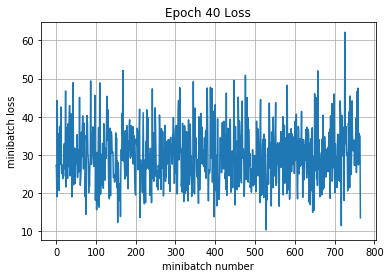

Iteration 30700: with minibatch training loss = 0.581 and accuracy of 0.75
Iteration 30800: with minibatch training loss = 0.307 and accuracy of 0.89
Iteration 30900: with minibatch training loss = 0.521 and accuracy of 0.81
Iteration 31000: with minibatch training loss = 0.396 and accuracy of 0.86
Iteration 31100: with minibatch training loss = 0.452 and accuracy of 0.86
Iteration 31200: with minibatch training loss = 0.337 and accuracy of 0.92
Iteration 31300: with minibatch training loss = 0.442 and accuracy of 0.88
Iteration 31400: with minibatch training loss = 0.292 and accuracy of 0.91
Epoch 41, Overall loss = 0.462 and accuracy of 0.845


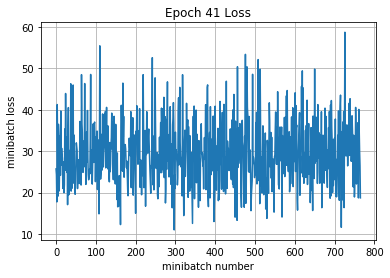

Iteration 31500: with minibatch training loss = 0.432 and accuracy of 0.88
Iteration 31600: with minibatch training loss = 0.396 and accuracy of 0.91
Iteration 31700: with minibatch training loss = 0.595 and accuracy of 0.77
Iteration 31800: with minibatch training loss = 0.38 and accuracy of 0.88
Iteration 31900: with minibatch training loss = 0.506 and accuracy of 0.83
Iteration 32000: with minibatch training loss = 0.376 and accuracy of 0.91
Iteration 32100: with minibatch training loss = 0.536 and accuracy of 0.84
Epoch 42, Overall loss = 0.456 and accuracy of 0.842


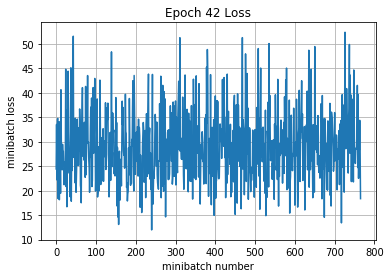

Iteration 32200: with minibatch training loss = 0.508 and accuracy of 0.8
Iteration 32300: with minibatch training loss = 0.549 and accuracy of 0.84
Iteration 32400: with minibatch training loss = 0.531 and accuracy of 0.84
Iteration 32500: with minibatch training loss = 0.519 and accuracy of 0.78
Iteration 32600: with minibatch training loss = 0.664 and accuracy of 0.75
Iteration 32700: with minibatch training loss = 0.314 and accuracy of 0.91
Iteration 32800: with minibatch training loss = 0.655 and accuracy of 0.78
Iteration 32900: with minibatch training loss = 0.55 and accuracy of 0.77
Epoch 43, Overall loss = 0.45 and accuracy of 0.847


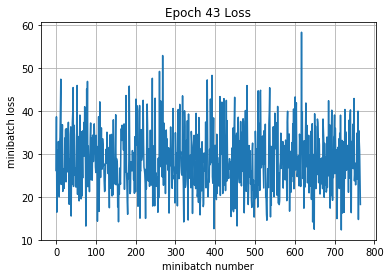

Iteration 33000: with minibatch training loss = 0.496 and accuracy of 0.81
Iteration 33100: with minibatch training loss = 0.351 and accuracy of 0.88
Iteration 33200: with minibatch training loss = 0.386 and accuracy of 0.84
Iteration 33300: with minibatch training loss = 0.318 and accuracy of 0.88
Iteration 33400: with minibatch training loss = 0.498 and accuracy of 0.81
Iteration 33500: with minibatch training loss = 0.411 and accuracy of 0.83
Iteration 33600: with minibatch training loss = 0.375 and accuracy of 0.83
Iteration 33700: with minibatch training loss = 0.405 and accuracy of 0.83
Epoch 44, Overall loss = 0.435 and accuracy of 0.852


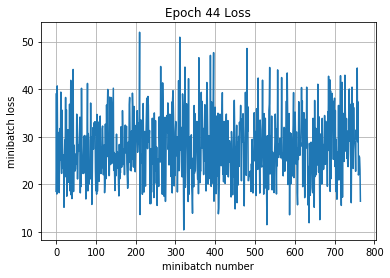

Iteration 33800: with minibatch training loss = 0.466 and accuracy of 0.84
Iteration 33900: with minibatch training loss = 0.536 and accuracy of 0.88
Iteration 34000: with minibatch training loss = 0.554 and accuracy of 0.81
Iteration 34100: with minibatch training loss = 0.53 and accuracy of 0.77
Iteration 34200: with minibatch training loss = 0.386 and accuracy of 0.84
Iteration 34300: with minibatch training loss = 0.261 and accuracy of 0.91
Iteration 34400: with minibatch training loss = 0.456 and accuracy of 0.84
Epoch 45, Overall loss = 0.425 and accuracy of 0.854


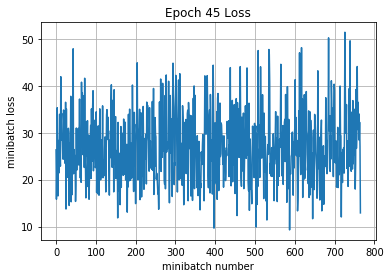

Iteration 34500: with minibatch training loss = 0.42 and accuracy of 0.84
Iteration 34600: with minibatch training loss = 0.555 and accuracy of 0.84
Iteration 34700: with minibatch training loss = 0.45 and accuracy of 0.81
Iteration 34800: with minibatch training loss = 0.569 and accuracy of 0.83
Iteration 34900: with minibatch training loss = 0.557 and accuracy of 0.83
Iteration 35000: with minibatch training loss = 0.254 and accuracy of 0.92
Iteration 35100: with minibatch training loss = 0.36 and accuracy of 0.88
Iteration 35200: with minibatch training loss = 0.629 and accuracy of 0.83
Epoch 46, Overall loss = 0.423 and accuracy of 0.854


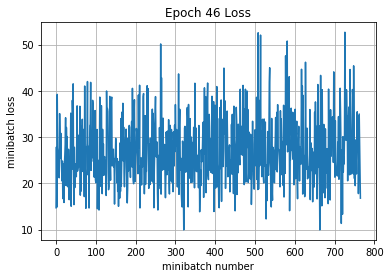

Iteration 35300: with minibatch training loss = 0.421 and accuracy of 0.91
Iteration 35400: with minibatch training loss = 0.507 and accuracy of 0.83
Iteration 35500: with minibatch training loss = 0.39 and accuracy of 0.88
Iteration 35600: with minibatch training loss = 0.311 and accuracy of 0.91
Iteration 35700: with minibatch training loss = 0.541 and accuracy of 0.84
Iteration 35800: with minibatch training loss = 0.54 and accuracy of 0.72
Iteration 35900: with minibatch training loss = 0.452 and accuracy of 0.86
Iteration 36000: with minibatch training loss = 0.415 and accuracy of 0.89
Epoch 47, Overall loss = 0.421 and accuracy of 0.857


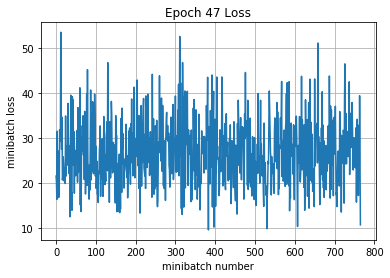

Iteration 36100: with minibatch training loss = 0.424 and accuracy of 0.86
Iteration 36200: with minibatch training loss = 0.345 and accuracy of 0.89
Iteration 36300: with minibatch training loss = 0.425 and accuracy of 0.86
Iteration 36400: with minibatch training loss = 0.496 and accuracy of 0.81
Iteration 36500: with minibatch training loss = 0.487 and accuracy of 0.84
Iteration 36600: with minibatch training loss = 0.365 and accuracy of 0.84
Iteration 36700: with minibatch training loss = 0.48 and accuracy of 0.81
Epoch 48, Overall loss = 0.411 and accuracy of 0.86


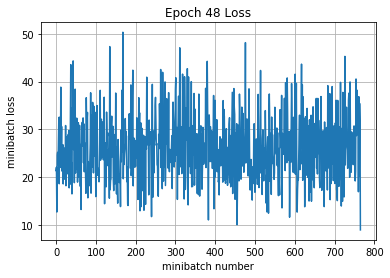

Iteration 36800: with minibatch training loss = 0.471 and accuracy of 0.83
Iteration 36900: with minibatch training loss = 0.379 and accuracy of 0.86
Iteration 37000: with minibatch training loss = 0.467 and accuracy of 0.84
Iteration 37100: with minibatch training loss = 0.254 and accuracy of 0.92
Iteration 37200: with minibatch training loss = 0.37 and accuracy of 0.88
Iteration 37300: with minibatch training loss = 0.284 and accuracy of 0.91
Iteration 37400: with minibatch training loss = 0.386 and accuracy of 0.88
Iteration 37500: with minibatch training loss = 0.463 and accuracy of 0.86
Epoch 49, Overall loss = 0.405 and accuracy of 0.862


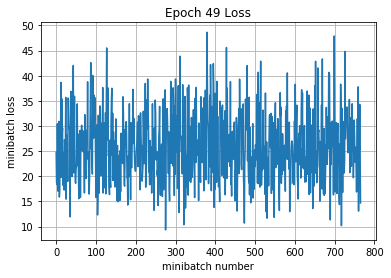

Iteration 37600: with minibatch training loss = 0.469 and accuracy of 0.86
Iteration 37700: with minibatch training loss = 0.479 and accuracy of 0.84
Iteration 37800: with minibatch training loss = 0.297 and accuracy of 0.86
Iteration 37900: with minibatch training loss = 0.461 and accuracy of 0.83
Iteration 38000: with minibatch training loss = 0.325 and accuracy of 0.88
Iteration 38100: with minibatch training loss = 0.281 and accuracy of 0.89
Iteration 38200: with minibatch training loss = 0.467 and accuracy of 0.88
Epoch 50, Overall loss = 0.397 and accuracy of 0.865


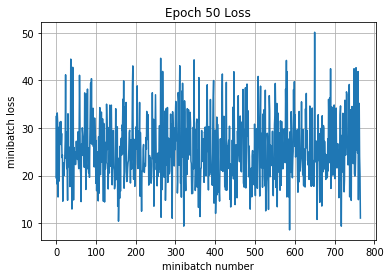

Iteration 38300: with minibatch training loss = 0.306 and accuracy of 0.91
Iteration 38400: with minibatch training loss = 0.266 and accuracy of 0.95
Iteration 38500: with minibatch training loss = 0.261 and accuracy of 0.89
Iteration 38600: with minibatch training loss = 0.506 and accuracy of 0.86
Iteration 38700: with minibatch training loss = 0.473 and accuracy of 0.84
Iteration 38800: with minibatch training loss = 0.207 and accuracy of 0.94
Iteration 38900: with minibatch training loss = 0.288 and accuracy of 0.91
Iteration 39000: with minibatch training loss = 0.285 and accuracy of 0.92
Epoch 51, Overall loss = 0.389 and accuracy of 0.867


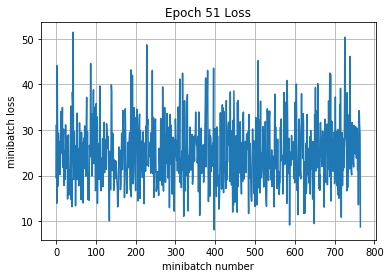

Iteration 39100: with minibatch training loss = 0.535 and accuracy of 0.81
Iteration 39200: with minibatch training loss = 0.257 and accuracy of 0.91
Iteration 39300: with minibatch training loss = 0.335 and accuracy of 0.88
Iteration 39400: with minibatch training loss = 0.277 and accuracy of 0.88
Iteration 39500: with minibatch training loss = 0.362 and accuracy of 0.86
Iteration 39600: with minibatch training loss = 0.212 and accuracy of 0.94
Iteration 39700: with minibatch training loss = 0.289 and accuracy of 0.92
Iteration 39800: with minibatch training loss = 0.502 and accuracy of 0.8
Epoch 52, Overall loss = 0.383 and accuracy of 0.87


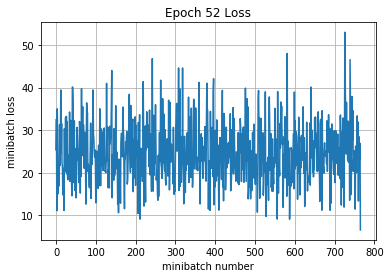

Iteration 39900: with minibatch training loss = 0.347 and accuracy of 0.88
Iteration 40000: with minibatch training loss = 0.518 and accuracy of 0.84
Iteration 40100: with minibatch training loss = 0.437 and accuracy of 0.86
Iteration 40200: with minibatch training loss = 0.376 and accuracy of 0.86
Iteration 40300: with minibatch training loss = 0.466 and accuracy of 0.83
Iteration 40400: with minibatch training loss = 0.291 and accuracy of 0.91
Iteration 40500: with minibatch training loss = 0.171 and accuracy of 0.94
Epoch 53, Overall loss = 0.38 and accuracy of 0.871


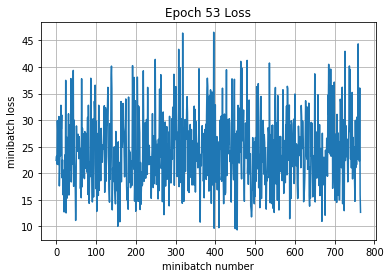

Iteration 40600: with minibatch training loss = 0.284 and accuracy of 0.91
Iteration 40700: with minibatch training loss = 0.468 and accuracy of 0.84
Iteration 40800: with minibatch training loss = 0.369 and accuracy of 0.91
Iteration 40900: with minibatch training loss = 0.377 and accuracy of 0.86
Iteration 41000: with minibatch training loss = 0.214 and accuracy of 0.95
Iteration 41100: with minibatch training loss = 0.463 and accuracy of 0.84
Iteration 41200: with minibatch training loss = 0.447 and accuracy of 0.83
Iteration 41300: with minibatch training loss = 0.436 and accuracy of 0.83
Epoch 54, Overall loss = 0.372 and accuracy of 0.872


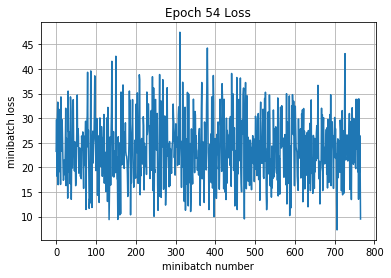

Iteration 41400: with minibatch training loss = 0.347 and accuracy of 0.88
Iteration 41500: with minibatch training loss = 0.317 and accuracy of 0.88
Iteration 41600: with minibatch training loss = 0.356 and accuracy of 0.89
Iteration 41700: with minibatch training loss = 0.385 and accuracy of 0.83
Iteration 41800: with minibatch training loss = 0.44 and accuracy of 0.86
Iteration 41900: with minibatch training loss = 0.417 and accuracy of 0.86
Iteration 42000: with minibatch training loss = 0.238 and accuracy of 0.89
Iteration 42100: with minibatch training loss = 0.467 and accuracy of 0.86
Epoch 55, Overall loss = 0.369 and accuracy of 0.873


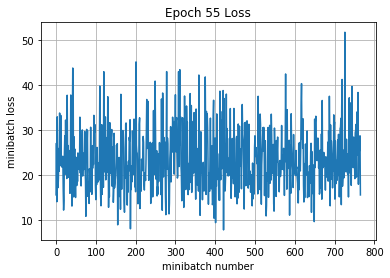

Iteration 42200: with minibatch training loss = 0.374 and accuracy of 0.89
Iteration 42300: with minibatch training loss = 0.429 and accuracy of 0.89
Iteration 42400: with minibatch training loss = 0.277 and accuracy of 0.91
Iteration 42500: with minibatch training loss = 0.351 and accuracy of 0.86
Iteration 42600: with minibatch training loss = 0.569 and accuracy of 0.84
Iteration 42700: with minibatch training loss = 0.379 and accuracy of 0.88
Iteration 42800: with minibatch training loss = 0.339 and accuracy of 0.86
Epoch 56, Overall loss = 0.367 and accuracy of 0.875


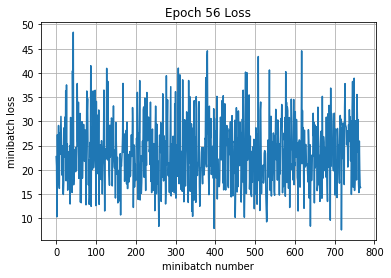

Iteration 42900: with minibatch training loss = 0.319 and accuracy of 0.89
Iteration 43000: with minibatch training loss = 0.298 and accuracy of 0.91
Iteration 43100: with minibatch training loss = 0.469 and accuracy of 0.84
Iteration 43200: with minibatch training loss = 0.421 and accuracy of 0.84
Iteration 43300: with minibatch training loss = 0.451 and accuracy of 0.84
Iteration 43400: with minibatch training loss = 0.496 and accuracy of 0.83
Iteration 43500: with minibatch training loss = 0.594 and accuracy of 0.81
Iteration 43600: with minibatch training loss = 0.337 and accuracy of 0.84
Epoch 57, Overall loss = 0.354 and accuracy of 0.879


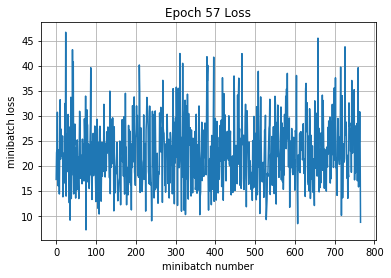

Iteration 43700: with minibatch training loss = 0.304 and accuracy of 0.95
Iteration 43800: with minibatch training loss = 0.432 and accuracy of 0.91
Iteration 43900: with minibatch training loss = 0.365 and accuracy of 0.86
Iteration 44000: with minibatch training loss = 0.293 and accuracy of 0.92
Iteration 44100: with minibatch training loss = 0.427 and accuracy of 0.84
Iteration 44200: with minibatch training loss = 0.262 and accuracy of 0.92
Iteration 44300: with minibatch training loss = 0.474 and accuracy of 0.83
Iteration 44400: with minibatch training loss = 0.25 and accuracy of 0.91
Epoch 58, Overall loss = 0.351 and accuracy of 0.88


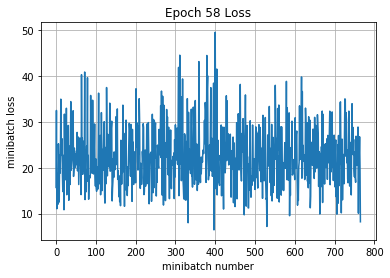

Iteration 44500: with minibatch training loss = 0.422 and accuracy of 0.86
Iteration 44600: with minibatch training loss = 0.195 and accuracy of 0.92
Iteration 44700: with minibatch training loss = 0.3 and accuracy of 0.91
Iteration 44800: with minibatch training loss = 0.349 and accuracy of 0.84
Iteration 44900: with minibatch training loss = 0.164 and accuracy of 0.97
Iteration 45000: with minibatch training loss = 0.347 and accuracy of 0.92
Iteration 45100: with minibatch training loss = 0.309 and accuracy of 0.88
Epoch 59, Overall loss = 0.346 and accuracy of 0.883


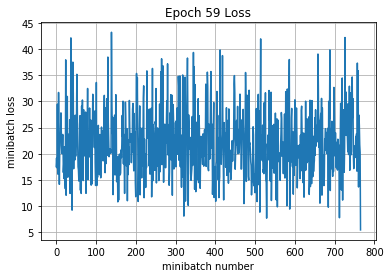

Iteration 45200: with minibatch training loss = 0.35 and accuracy of 0.84
Iteration 45300: with minibatch training loss = 0.357 and accuracy of 0.91
Iteration 45400: with minibatch training loss = 0.196 and accuracy of 0.94
Iteration 45500: with minibatch training loss = 0.289 and accuracy of 0.86
Iteration 45600: with minibatch training loss = 0.392 and accuracy of 0.88
Iteration 45700: with minibatch training loss = 0.282 and accuracy of 0.89
Iteration 45800: with minibatch training loss = 0.231 and accuracy of 0.89
Iteration 45900: with minibatch training loss = 0.272 and accuracy of 0.91
Epoch 60, Overall loss = 0.343 and accuracy of 0.885


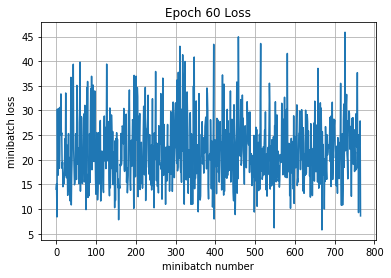

Iteration 46000: with minibatch training loss = 0.264 and accuracy of 0.92
Iteration 46100: with minibatch training loss = 0.363 and accuracy of 0.89
Iteration 46200: with minibatch training loss = 0.227 and accuracy of 0.88
Iteration 46300: with minibatch training loss = 0.327 and accuracy of 0.91
Iteration 46400: with minibatch training loss = 0.333 and accuracy of 0.81
Iteration 46500: with minibatch training loss = 0.376 and accuracy of 0.88
Iteration 46600: with minibatch training loss = 0.405 and accuracy of 0.86
Iteration 46700: with minibatch training loss = 0.443 and accuracy of 0.91
Epoch 61, Overall loss = 0.339 and accuracy of 0.884


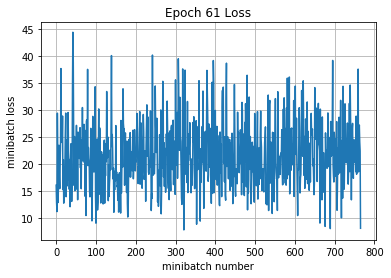

Iteration 46800: with minibatch training loss = 0.39 and accuracy of 0.88
Iteration 46900: with minibatch training loss = 0.369 and accuracy of 0.84
Iteration 47000: with minibatch training loss = 0.361 and accuracy of 0.88
Iteration 47100: with minibatch training loss = 0.488 and accuracy of 0.78
Iteration 47200: with minibatch training loss = 0.298 and accuracy of 0.88
Iteration 47300: with minibatch training loss = 0.359 and accuracy of 0.89
Iteration 47400: with minibatch training loss = 0.32 and accuracy of 0.88
Epoch 62, Overall loss = 0.332 and accuracy of 0.885


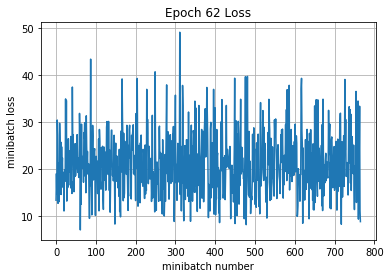

Iteration 47500: with minibatch training loss = 0.227 and accuracy of 0.91
Iteration 47600: with minibatch training loss = 0.167 and accuracy of 0.95
Iteration 47700: with minibatch training loss = 0.309 and accuracy of 0.92
Iteration 47800: with minibatch training loss = 0.428 and accuracy of 0.84
Iteration 47900: with minibatch training loss = 0.118 and accuracy of 0.95
Iteration 48000: with minibatch training loss = 0.508 and accuracy of 0.81
Iteration 48100: with minibatch training loss = 0.286 and accuracy of 0.91
Iteration 48200: with minibatch training loss = 0.308 and accuracy of 0.89
Epoch 63, Overall loss = 0.327 and accuracy of 0.889


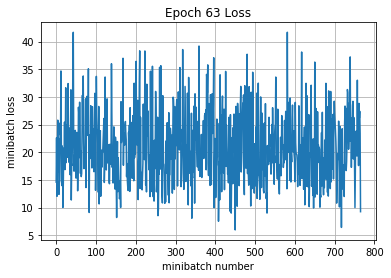

Iteration 48300: with minibatch training loss = 0.379 and accuracy of 0.83
Iteration 48400: with minibatch training loss = 0.424 and accuracy of 0.86
Iteration 48500: with minibatch training loss = 0.433 and accuracy of 0.89
Iteration 48600: with minibatch training loss = 0.203 and accuracy of 0.92
Iteration 48700: with minibatch training loss = 0.45 and accuracy of 0.86
Iteration 48800: with minibatch training loss = 0.381 and accuracy of 0.84
Iteration 48900: with minibatch training loss = 0.179 and accuracy of 0.94
Iteration 49000: with minibatch training loss = 0.203 and accuracy of 0.92
Epoch 64, Overall loss = 0.326 and accuracy of 0.889


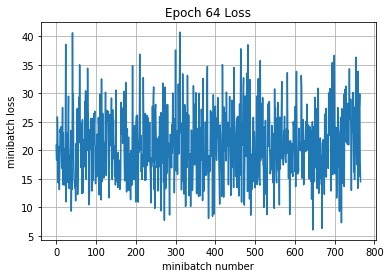

Iteration 49100: with minibatch training loss = 0.317 and accuracy of 0.91
Iteration 49200: with minibatch training loss = 0.262 and accuracy of 0.94
Iteration 49300: with minibatch training loss = 0.236 and accuracy of 0.94
Iteration 49400: with minibatch training loss = 0.398 and accuracy of 0.88
Iteration 49500: with minibatch training loss = 0.414 and accuracy of 0.78
Iteration 49600: with minibatch training loss = 0.309 and accuracy of 0.89
Iteration 49700: with minibatch training loss = 0.145 and accuracy of 0.95
Epoch 65, Overall loss = 0.316 and accuracy of 0.891


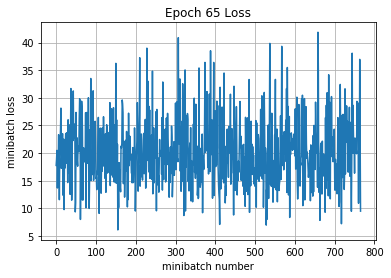

Iteration 49800: with minibatch training loss = 0.485 and accuracy of 0.84
Iteration 49900: with minibatch training loss = 0.416 and accuracy of 0.88
Iteration 50000: with minibatch training loss = 0.522 and accuracy of 0.84
Iteration 50100: with minibatch training loss = 0.485 and accuracy of 0.84
Iteration 50200: with minibatch training loss = 0.183 and accuracy of 0.94
Iteration 50300: with minibatch training loss = 0.169 and accuracy of 0.95
Iteration 50400: with minibatch training loss = 0.388 and accuracy of 0.91
Iteration 50500: with minibatch training loss = 0.304 and accuracy of 0.89
Epoch 66, Overall loss = 0.315 and accuracy of 0.892


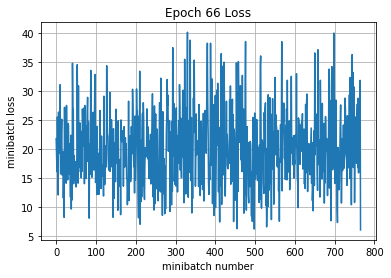

Iteration 50600: with minibatch training loss = 0.218 and accuracy of 0.94
Iteration 50700: with minibatch training loss = 0.28 and accuracy of 0.84
Iteration 50800: with minibatch training loss = 0.278 and accuracy of 0.94
Iteration 50900: with minibatch training loss = 0.269 and accuracy of 0.89
Iteration 51000: with minibatch training loss = 0.233 and accuracy of 0.92
Iteration 51100: with minibatch training loss = 0.302 and accuracy of 0.92
Iteration 51200: with minibatch training loss = 0.3 and accuracy of 0.89
Iteration 51300: with minibatch training loss = 0.328 and accuracy of 0.89
Epoch 67, Overall loss = 0.313 and accuracy of 0.893


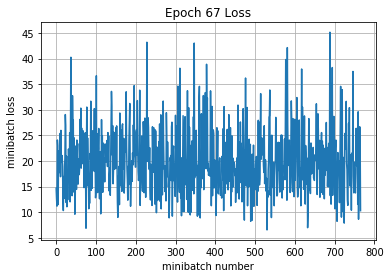

Iteration 51400: with minibatch training loss = 0.353 and accuracy of 0.88
Iteration 51500: with minibatch training loss = 0.355 and accuracy of 0.86
Iteration 51600: with minibatch training loss = 0.428 and accuracy of 0.88
Iteration 51700: with minibatch training loss = 0.432 and accuracy of 0.84
Iteration 51800: with minibatch training loss = 0.259 and accuracy of 0.88
Iteration 51900: with minibatch training loss = 0.427 and accuracy of 0.84
Iteration 52000: with minibatch training loss = 0.272 and accuracy of 0.92
Epoch 68, Overall loss = 0.306 and accuracy of 0.896


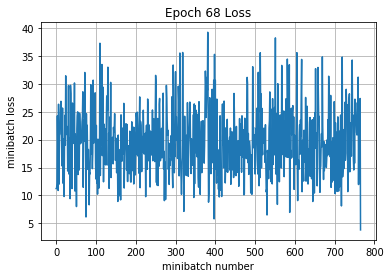

Iteration 52100: with minibatch training loss = 0.27 and accuracy of 0.94
Iteration 52200: with minibatch training loss = 0.169 and accuracy of 0.95
Iteration 52300: with minibatch training loss = 0.247 and accuracy of 0.94
Iteration 52400: with minibatch training loss = 0.302 and accuracy of 0.88
Iteration 52500: with minibatch training loss = 0.429 and accuracy of 0.88
Iteration 52600: with minibatch training loss = 0.188 and accuracy of 0.92
Iteration 52700: with minibatch training loss = 0.294 and accuracy of 0.91
Iteration 52800: with minibatch training loss = 0.204 and accuracy of 0.92
Epoch 69, Overall loss = 0.299 and accuracy of 0.896


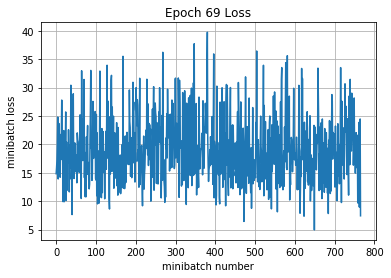

Iteration 52900: with minibatch training loss = 0.252 and accuracy of 0.89
Iteration 53000: with minibatch training loss = 0.509 and accuracy of 0.83
Iteration 53100: with minibatch training loss = 0.127 and accuracy of 0.97
Iteration 53200: with minibatch training loss = 0.209 and accuracy of 0.94
Iteration 53300: with minibatch training loss = 0.294 and accuracy of 0.91
Iteration 53400: with minibatch training loss = 0.278 and accuracy of 0.92
Iteration 53500: with minibatch training loss = 0.175 and accuracy of 0.91
Iteration 53600: with minibatch training loss = 0.581 and accuracy of 0.81
Epoch 70, Overall loss = 0.298 and accuracy of 0.897


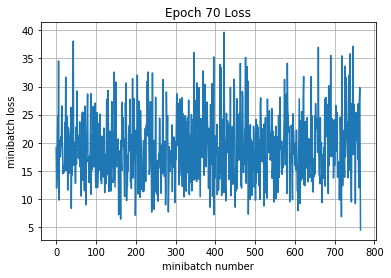

Iteration 53700: with minibatch training loss = 0.296 and accuracy of 0.88
Iteration 53800: with minibatch training loss = 0.217 and accuracy of 0.92
Iteration 53900: with minibatch training loss = 0.25 and accuracy of 0.94
Iteration 54000: with minibatch training loss = 0.487 and accuracy of 0.91
Iteration 54100: with minibatch training loss = 0.353 and accuracy of 0.91
Iteration 54200: with minibatch training loss = 0.3 and accuracy of 0.88
Iteration 54300: with minibatch training loss = 0.282 and accuracy of 0.92
Epoch 71, Overall loss = 0.294 and accuracy of 0.899


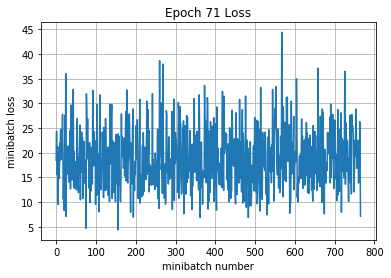

Iteration 54400: with minibatch training loss = 0.264 and accuracy of 0.91
Iteration 54500: with minibatch training loss = 0.379 and accuracy of 0.88
Iteration 54600: with minibatch training loss = 0.328 and accuracy of 0.86
Iteration 54700: with minibatch training loss = 0.229 and accuracy of 0.92
Iteration 54800: with minibatch training loss = 0.256 and accuracy of 0.88
Iteration 54900: with minibatch training loss = 0.319 and accuracy of 0.89
Iteration 55000: with minibatch training loss = 0.209 and accuracy of 0.92
Iteration 55100: with minibatch training loss = 0.305 and accuracy of 0.86
Epoch 72, Overall loss = 0.29 and accuracy of 0.9


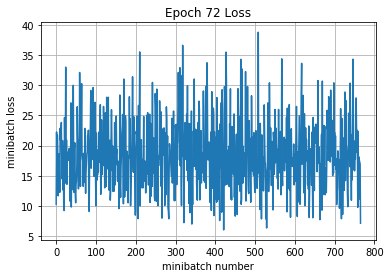

Iteration 55200: with minibatch training loss = 0.172 and accuracy of 0.98
Iteration 55300: with minibatch training loss = 0.199 and accuracy of 0.92
Iteration 55400: with minibatch training loss = 0.231 and accuracy of 0.92
Iteration 55500: with minibatch training loss = 0.238 and accuracy of 0.89
Iteration 55600: with minibatch training loss = 0.273 and accuracy of 0.92
Iteration 55700: with minibatch training loss = 0.185 and accuracy of 0.92
Iteration 55800: with minibatch training loss = 0.225 and accuracy of 0.91
Iteration 55900: with minibatch training loss = 0.352 and accuracy of 0.91
Epoch 73, Overall loss = 0.289 and accuracy of 0.901


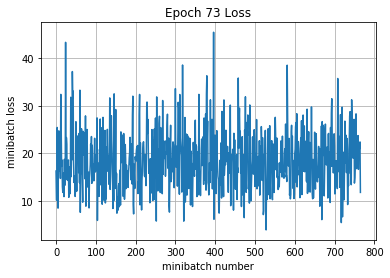

Iteration 56000: with minibatch training loss = 0.204 and accuracy of 0.91
Iteration 56100: with minibatch training loss = 0.326 and accuracy of 0.92
Iteration 56200: with minibatch training loss = 0.19 and accuracy of 0.95
Iteration 56300: with minibatch training loss = 0.33 and accuracy of 0.88
Iteration 56400: with minibatch training loss = 0.312 and accuracy of 0.89
Iteration 56500: with minibatch training loss = 0.294 and accuracy of 0.94
Iteration 56600: with minibatch training loss = 0.113 and accuracy of 0.98
Epoch 74, Overall loss = 0.284 and accuracy of 0.903


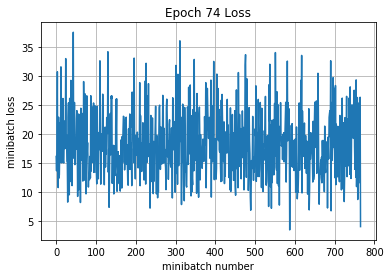

Iteration 56700: with minibatch training loss = 0.278 and accuracy of 0.92
Iteration 56800: with minibatch training loss = 0.19 and accuracy of 0.94
Iteration 56900: with minibatch training loss = 0.231 and accuracy of 0.92
Iteration 57000: with minibatch training loss = 0.191 and accuracy of 0.92
Iteration 57100: with minibatch training loss = 0.216 and accuracy of 0.94
Iteration 57200: with minibatch training loss = 0.203 and accuracy of 0.91
Iteration 57300: with minibatch training loss = 0.286 and accuracy of 0.88
Iteration 57400: with minibatch training loss = 0.3 and accuracy of 0.91
Epoch 75, Overall loss = 0.281 and accuracy of 0.904


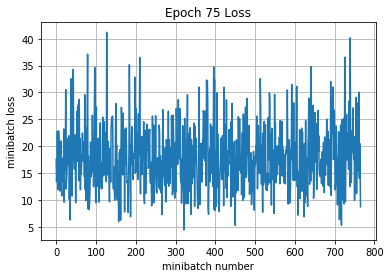

Iteration 57500: with minibatch training loss = 0.155 and accuracy of 0.94
Iteration 57600: with minibatch training loss = 0.308 and accuracy of 0.89
Iteration 57700: with minibatch training loss = 0.333 and accuracy of 0.91
Iteration 57800: with minibatch training loss = 0.187 and accuracy of 0.94
Iteration 57900: with minibatch training loss = 0.187 and accuracy of 0.91
Iteration 58000: with minibatch training loss = 0.363 and accuracy of 0.89
Iteration 58100: with minibatch training loss = 0.445 and accuracy of 0.86
Iteration 58200: with minibatch training loss = 0.285 and accuracy of 0.92
Epoch 76, Overall loss = 0.277 and accuracy of 0.903


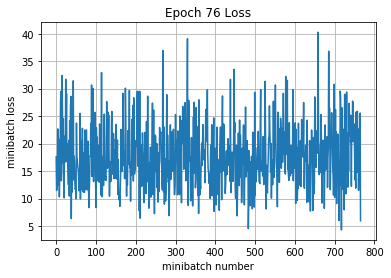

Iteration 58300: with minibatch training loss = 0.114 and accuracy of 0.95
Iteration 58400: with minibatch training loss = 0.299 and accuracy of 0.86
Iteration 58500: with minibatch training loss = 0.213 and accuracy of 0.91
Iteration 58600: with minibatch training loss = 0.338 and accuracy of 0.86
Iteration 58700: with minibatch training loss = 0.233 and accuracy of 0.92
Iteration 58800: with minibatch training loss = 0.237 and accuracy of 0.91
Iteration 58900: with minibatch training loss = 0.379 and accuracy of 0.84
Epoch 77, Overall loss = 0.276 and accuracy of 0.905


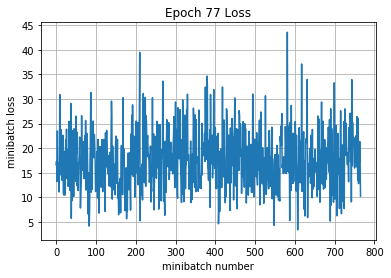

Iteration 59000: with minibatch training loss = 0.189 and accuracy of 0.94
Iteration 59100: with minibatch training loss = 0.272 and accuracy of 0.92
Iteration 59200: with minibatch training loss = 0.33 and accuracy of 0.92
Iteration 59300: with minibatch training loss = 0.556 and accuracy of 0.8
Iteration 59400: with minibatch training loss = 0.349 and accuracy of 0.86
Iteration 59500: with minibatch training loss = 0.275 and accuracy of 0.89
Iteration 59600: with minibatch training loss = 0.233 and accuracy of 0.91
Iteration 59700: with minibatch training loss = 0.294 and accuracy of 0.94
Epoch 78, Overall loss = 0.267 and accuracy of 0.909


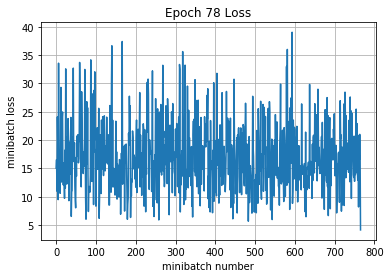

Iteration 59800: with minibatch training loss = 0.181 and accuracy of 0.94
Iteration 59900: with minibatch training loss = 0.329 and accuracy of 0.89
Iteration 60000: with minibatch training loss = 0.215 and accuracy of 0.94
Iteration 60100: with minibatch training loss = 0.264 and accuracy of 0.92
Iteration 60200: with minibatch training loss = 0.302 and accuracy of 0.91
Iteration 60300: with minibatch training loss = 0.304 and accuracy of 0.86
Iteration 60400: with minibatch training loss = 0.228 and accuracy of 0.92
Iteration 60500: with minibatch training loss = 0.114 and accuracy of 0.97
Epoch 79, Overall loss = 0.261 and accuracy of 0.911


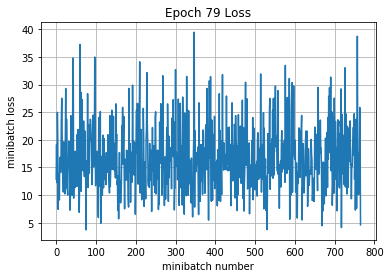

Iteration 60600: with minibatch training loss = 0.288 and accuracy of 0.91
Iteration 60700: with minibatch training loss = 0.257 and accuracy of 0.92
Iteration 60800: with minibatch training loss = 0.301 and accuracy of 0.86
Iteration 60900: with minibatch training loss = 0.309 and accuracy of 0.89
Iteration 61000: with minibatch training loss = 0.209 and accuracy of 0.92
Iteration 61100: with minibatch training loss = 0.333 and accuracy of 0.86
Iteration 61200: with minibatch training loss = 0.171 and accuracy of 0.97
Epoch 80, Overall loss = 0.265 and accuracy of 0.908


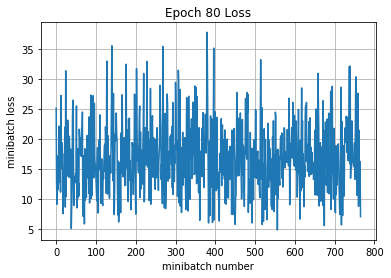

Iteration 61300: with minibatch training loss = 0.325 and accuracy of 0.89
Iteration 61400: with minibatch training loss = 0.273 and accuracy of 0.89
Iteration 61500: with minibatch training loss = 0.362 and accuracy of 0.88
Iteration 61600: with minibatch training loss = 0.162 and accuracy of 0.89
Iteration 61700: with minibatch training loss = 0.32 and accuracy of 0.88
Iteration 61800: with minibatch training loss = 0.234 and accuracy of 0.91
Iteration 61900: with minibatch training loss = 0.136 and accuracy of 0.97
Iteration 62000: with minibatch training loss = 0.184 and accuracy of 0.94
Epoch 81, Overall loss = 0.261 and accuracy of 0.909


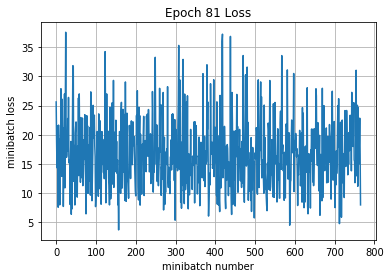

Iteration 62100: with minibatch training loss = 0.289 and accuracy of 0.88
Iteration 62200: with minibatch training loss = 0.342 and accuracy of 0.89
Iteration 62300: with minibatch training loss = 0.228 and accuracy of 0.91
Iteration 62400: with minibatch training loss = 0.211 and accuracy of 0.94
Iteration 62500: with minibatch training loss = 0.259 and accuracy of 0.92
Iteration 62600: with minibatch training loss = 0.172 and accuracy of 0.95
Iteration 62700: with minibatch training loss = 0.346 and accuracy of 0.89
Iteration 62800: with minibatch training loss = 0.318 and accuracy of 0.91
Epoch 82, Overall loss = 0.262 and accuracy of 0.91


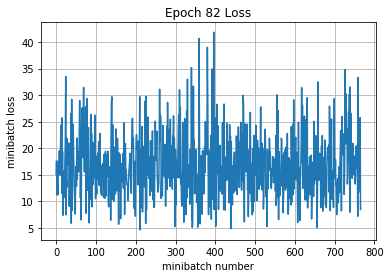

Iteration 62900: with minibatch training loss = 0.223 and accuracy of 0.92
Iteration 63000: with minibatch training loss = 0.251 and accuracy of 0.95
Iteration 63100: with minibatch training loss = 0.432 and accuracy of 0.89
Iteration 63200: with minibatch training loss = 0.376 and accuracy of 0.86
Iteration 63300: with minibatch training loss = 0.243 and accuracy of 0.92
Iteration 63400: with minibatch training loss = 0.141 and accuracy of 0.94
Iteration 63500: with minibatch training loss = 0.237 and accuracy of 0.92
Epoch 83, Overall loss = 0.254 and accuracy of 0.913


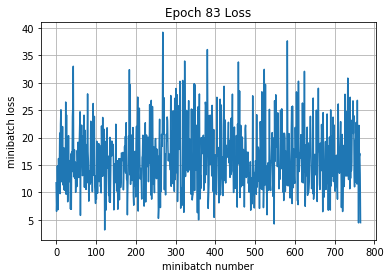

Iteration 63600: with minibatch training loss = 0.186 and accuracy of 0.94
Iteration 63700: with minibatch training loss = 0.105 and accuracy of 0.97
Iteration 63800: with minibatch training loss = 0.155 and accuracy of 0.92
Iteration 63900: with minibatch training loss = 0.252 and accuracy of 0.89
Iteration 64000: with minibatch training loss = 0.231 and accuracy of 0.92
Iteration 64100: with minibatch training loss = 0.125 and accuracy of 0.97
Iteration 64200: with minibatch training loss = 0.226 and accuracy of 0.91
Iteration 64300: with minibatch training loss = 0.157 and accuracy of 0.92
Epoch 84, Overall loss = 0.249 and accuracy of 0.914


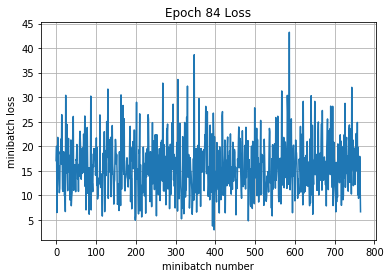

Iteration 64400: with minibatch training loss = 0.307 and accuracy of 0.91
Iteration 64500: with minibatch training loss = 0.188 and accuracy of 0.92
Iteration 64600: with minibatch training loss = 0.0494 and accuracy of 1
Iteration 64700: with minibatch training loss = 0.202 and accuracy of 0.95
Iteration 64800: with minibatch training loss = 0.247 and accuracy of 0.89
Iteration 64900: with minibatch training loss = 0.17 and accuracy of 0.94
Iteration 65000: with minibatch training loss = 0.325 and accuracy of 0.91
Iteration 65100: with minibatch training loss = 0.394 and accuracy of 0.91
Epoch 85, Overall loss = 0.25 and accuracy of 0.915


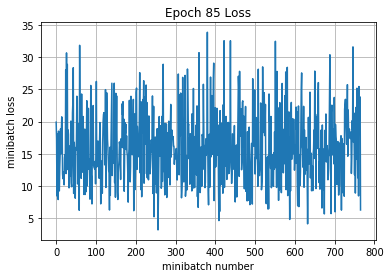

Iteration 65200: with minibatch training loss = 0.107 and accuracy of 0.98
Iteration 65300: with minibatch training loss = 0.218 and accuracy of 0.95
Iteration 65400: with minibatch training loss = 0.178 and accuracy of 0.95
Iteration 65500: with minibatch training loss = 0.213 and accuracy of 0.95
Iteration 65600: with minibatch training loss = 0.218 and accuracy of 0.95
Iteration 65700: with minibatch training loss = 0.293 and accuracy of 0.89
Iteration 65800: with minibatch training loss = 0.347 and accuracy of 0.88
Epoch 86, Overall loss = 0.248 and accuracy of 0.914


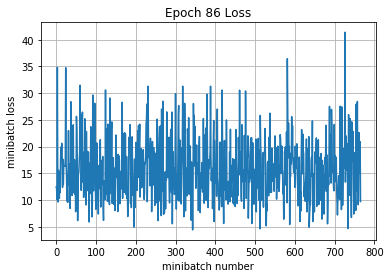

Iteration 65900: with minibatch training loss = 0.307 and accuracy of 0.91
Iteration 66000: with minibatch training loss = 0.158 and accuracy of 0.95
Iteration 66100: with minibatch training loss = 0.294 and accuracy of 0.92
Iteration 66200: with minibatch training loss = 0.287 and accuracy of 0.91
Iteration 66300: with minibatch training loss = 0.137 and accuracy of 0.95
Iteration 66400: with minibatch training loss = 0.248 and accuracy of 0.91
Iteration 66500: with minibatch training loss = 0.221 and accuracy of 0.94
Iteration 66600: with minibatch training loss = 0.232 and accuracy of 0.91
Epoch 87, Overall loss = 0.248 and accuracy of 0.915


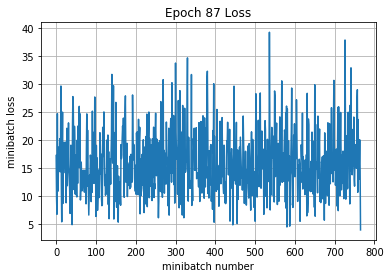

Iteration 66700: with minibatch training loss = 0.247 and accuracy of 0.91
Iteration 66800: with minibatch training loss = 0.104 and accuracy of 0.97
Iteration 66900: with minibatch training loss = 0.161 and accuracy of 0.97
Iteration 67000: with minibatch training loss = 0.175 and accuracy of 0.97
Iteration 67100: with minibatch training loss = 0.218 and accuracy of 0.94
Iteration 67200: with minibatch training loss = 0.314 and accuracy of 0.94
Iteration 67300: with minibatch training loss = 0.584 and accuracy of 0.84
Iteration 67400: with minibatch training loss = 0.137 and accuracy of 0.95
Epoch 88, Overall loss = 0.238 and accuracy of 0.918


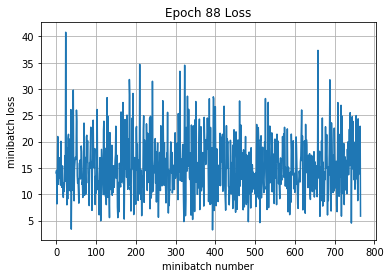

Iteration 67500: with minibatch training loss = 0.268 and accuracy of 0.91
Iteration 67600: with minibatch training loss = 0.284 and accuracy of 0.88
Iteration 67700: with minibatch training loss = 0.191 and accuracy of 0.95
Iteration 67800: with minibatch training loss = 0.34 and accuracy of 0.88
Iteration 67900: with minibatch training loss = 0.106 and accuracy of 0.98
Iteration 68000: with minibatch training loss = 0.401 and accuracy of 0.88
Iteration 68100: with minibatch training loss = 0.28 and accuracy of 0.91
Epoch 89, Overall loss = 0.237 and accuracy of 0.918


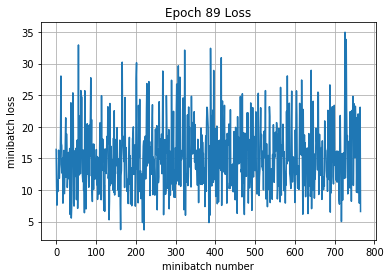

Iteration 68200: with minibatch training loss = 0.26 and accuracy of 0.91
Iteration 68300: with minibatch training loss = 0.245 and accuracy of 0.88
Iteration 68400: with minibatch training loss = 0.337 and accuracy of 0.88
Iteration 68500: with minibatch training loss = 0.132 and accuracy of 0.94
Iteration 68600: with minibatch training loss = 0.156 and accuracy of 0.95
Iteration 68700: with minibatch training loss = 0.307 and accuracy of 0.88
Iteration 68800: with minibatch training loss = 0.266 and accuracy of 0.89
Iteration 68900: with minibatch training loss = 0.36 and accuracy of 0.84
Epoch 90, Overall loss = 0.235 and accuracy of 0.92


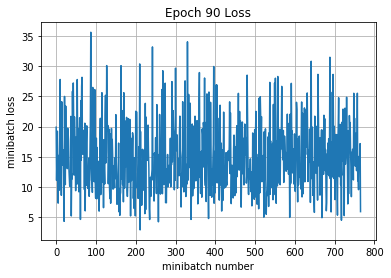

Iteration 69000: with minibatch training loss = 0.21 and accuracy of 0.89
Iteration 69100: with minibatch training loss = 0.272 and accuracy of 0.88
Iteration 69200: with minibatch training loss = 0.452 and accuracy of 0.78
Iteration 69300: with minibatch training loss = 0.169 and accuracy of 0.94
Iteration 69400: with minibatch training loss = 0.244 and accuracy of 0.94
Iteration 69500: with minibatch training loss = 0.248 and accuracy of 0.95
Iteration 69600: with minibatch training loss = 0.224 and accuracy of 0.92
Iteration 69700: with minibatch training loss = 0.0903 and accuracy of 0.98
Epoch 91, Overall loss = 0.23 and accuracy of 0.921


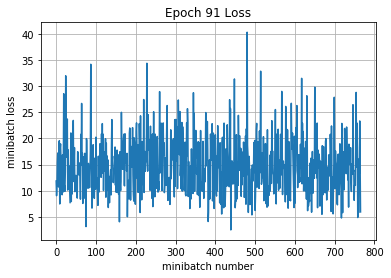

Iteration 69800: with minibatch training loss = 0.188 and accuracy of 0.91
Iteration 69900: with minibatch training loss = 0.171 and accuracy of 0.94
Iteration 70000: with minibatch training loss = 0.217 and accuracy of 0.92
Iteration 70100: with minibatch training loss = 0.354 and accuracy of 0.89
Iteration 70200: with minibatch training loss = 0.248 and accuracy of 0.92
Iteration 70300: with minibatch training loss = 0.193 and accuracy of 0.89
Iteration 70400: with minibatch training loss = 0.24 and accuracy of 0.88
Epoch 92, Overall loss = 0.226 and accuracy of 0.922


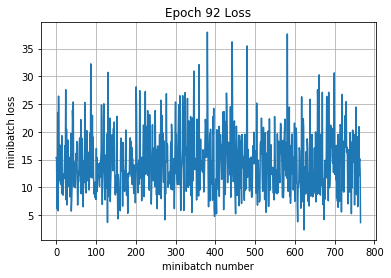

Iteration 70500: with minibatch training loss = 0.167 and accuracy of 0.95
Iteration 70600: with minibatch training loss = 0.276 and accuracy of 0.92
Iteration 70700: with minibatch training loss = 0.42 and accuracy of 0.88
Iteration 70800: with minibatch training loss = 0.144 and accuracy of 0.94
Iteration 70900: with minibatch training loss = 0.236 and accuracy of 0.92
Iteration 71000: with minibatch training loss = 0.151 and accuracy of 0.94
Iteration 71100: with minibatch training loss = 0.172 and accuracy of 0.92
Iteration 71200: with minibatch training loss = 0.342 and accuracy of 0.91
Epoch 93, Overall loss = 0.23 and accuracy of 0.92


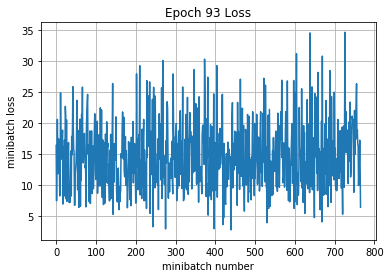

Iteration 71300: with minibatch training loss = 0.175 and accuracy of 0.94
Iteration 71400: with minibatch training loss = 0.0967 and accuracy of 0.95
Iteration 71500: with minibatch training loss = 0.237 and accuracy of 0.89
Iteration 71600: with minibatch training loss = 0.0594 and accuracy of 0.98
Iteration 71700: with minibatch training loss = 0.146 and accuracy of 0.95
Iteration 71800: with minibatch training loss = 0.142 and accuracy of 0.95
Iteration 71900: with minibatch training loss = 0.206 and accuracy of 0.95
Iteration 72000: with minibatch training loss = 0.214 and accuracy of 0.92
Epoch 94, Overall loss = 0.229 and accuracy of 0.921


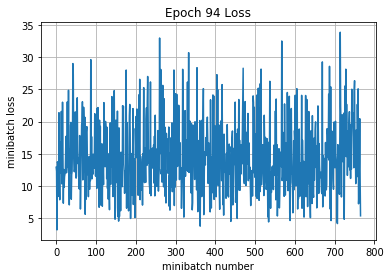

Iteration 72100: with minibatch training loss = 0.206 and accuracy of 0.97
Iteration 72200: with minibatch training loss = 0.265 and accuracy of 0.94
Iteration 72300: with minibatch training loss = 0.26 and accuracy of 0.91
Iteration 72400: with minibatch training loss = 0.497 and accuracy of 0.84
Iteration 72500: with minibatch training loss = 0.238 and accuracy of 0.94
Iteration 72600: with minibatch training loss = 0.0915 and accuracy of 0.95
Iteration 72700: with minibatch training loss = 0.122 and accuracy of 0.94
Epoch 95, Overall loss = 0.22 and accuracy of 0.924


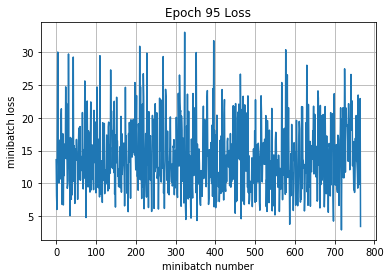

Iteration 72800: with minibatch training loss = 0.436 and accuracy of 0.84
Iteration 72900: with minibatch training loss = 0.205 and accuracy of 0.91
Iteration 73000: with minibatch training loss = 0.299 and accuracy of 0.94
Iteration 73100: with minibatch training loss = 0.43 and accuracy of 0.89
Iteration 73200: with minibatch training loss = 0.294 and accuracy of 0.88
Iteration 73300: with minibatch training loss = 0.0954 and accuracy of 0.95
Iteration 73400: with minibatch training loss = 0.253 and accuracy of 0.88
Iteration 73500: with minibatch training loss = 0.185 and accuracy of 0.94
Epoch 96, Overall loss = 0.219 and accuracy of 0.924


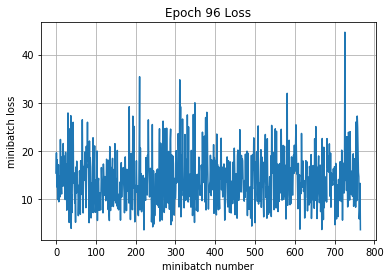

Iteration 73600: with minibatch training loss = 0.226 and accuracy of 0.91
Iteration 73700: with minibatch training loss = 0.203 and accuracy of 0.91
Iteration 73800: with minibatch training loss = 0.151 and accuracy of 0.95
Iteration 73900: with minibatch training loss = 0.262 and accuracy of 0.92
Iteration 74000: with minibatch training loss = 0.207 and accuracy of 0.94
Iteration 74100: with minibatch training loss = 0.224 and accuracy of 0.91
Iteration 74200: with minibatch training loss = 0.235 and accuracy of 0.91
Iteration 74300: with minibatch training loss = 0.294 and accuracy of 0.88
Epoch 97, Overall loss = 0.222 and accuracy of 0.924


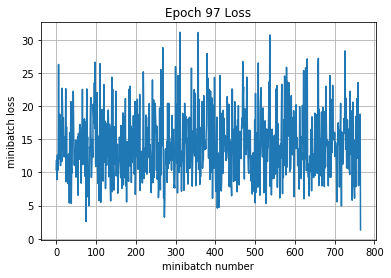

Iteration 74400: with minibatch training loss = 0.314 and accuracy of 0.92
Iteration 74500: with minibatch training loss = 0.348 and accuracy of 0.89
Iteration 74600: with minibatch training loss = 0.279 and accuracy of 0.91
Iteration 74700: with minibatch training loss = 0.363 and accuracy of 0.89
Iteration 74800: with minibatch training loss = 0.198 and accuracy of 0.95
Iteration 74900: with minibatch training loss = 0.189 and accuracy of 0.95
Iteration 75000: with minibatch training loss = 0.23 and accuracy of 0.89
Epoch 98, Overall loss = 0.216 and accuracy of 0.925


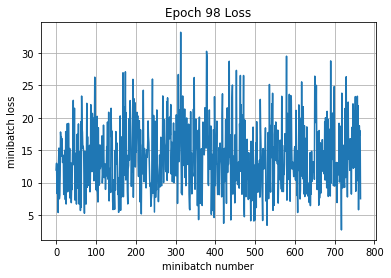

Iteration 75100: with minibatch training loss = 0.28 and accuracy of 0.92
Iteration 75200: with minibatch training loss = 0.218 and accuracy of 0.92
Iteration 75300: with minibatch training loss = 0.209 and accuracy of 0.91
Iteration 75400: with minibatch training loss = 0.115 and accuracy of 0.97
Iteration 75500: with minibatch training loss = 0.112 and accuracy of 0.94
Iteration 75600: with minibatch training loss = 0.168 and accuracy of 0.94
Iteration 75700: with minibatch training loss = 0.151 and accuracy of 0.94
Iteration 75800: with minibatch training loss = 0.258 and accuracy of 0.91
Epoch 99, Overall loss = 0.218 and accuracy of 0.926


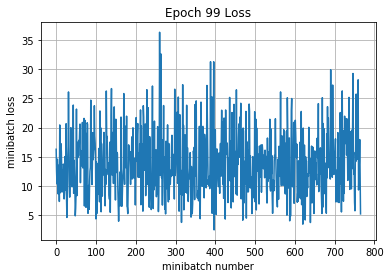

Iteration 75900: with minibatch training loss = 0.285 and accuracy of 0.92
Iteration 76000: with minibatch training loss = 0.19 and accuracy of 0.92
Iteration 76100: with minibatch training loss = 0.324 and accuracy of 0.88
Iteration 76200: with minibatch training loss = 0.155 and accuracy of 0.95
Iteration 76300: with minibatch training loss = 0.163 and accuracy of 0.94
Iteration 76400: with minibatch training loss = 0.157 and accuracy of 0.95
Iteration 76500: with minibatch training loss = 0.183 and accuracy of 0.92
Epoch 100, Overall loss = 0.217 and accuracy of 0.925


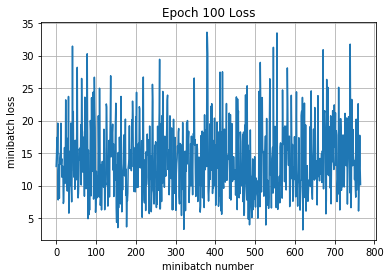

Iteration 76600: with minibatch training loss = 0.273 and accuracy of 0.91
Iteration 76700: with minibatch training loss = 0.129 and accuracy of 0.94
Iteration 76800: with minibatch training loss = 0.113 and accuracy of 0.92
Iteration 76900: with minibatch training loss = 0.15 and accuracy of 0.97
Iteration 77000: with minibatch training loss = 0.372 and accuracy of 0.91
Iteration 77100: with minibatch training loss = 0.169 and accuracy of 0.95
Iteration 77200: with minibatch training loss = 0.217 and accuracy of 0.94
Iteration 77300: with minibatch training loss = 0.274 and accuracy of 0.88
Epoch 101, Overall loss = 0.214 and accuracy of 0.926


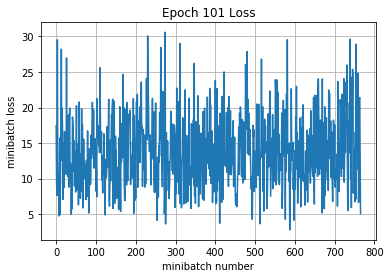

Iteration 77400: with minibatch training loss = 0.141 and accuracy of 0.97
Iteration 77500: with minibatch training loss = 0.24 and accuracy of 0.89
Iteration 77600: with minibatch training loss = 0.154 and accuracy of 0.92
Iteration 77700: with minibatch training loss = 0.126 and accuracy of 0.98
Iteration 77800: with minibatch training loss = 0.229 and accuracy of 0.89
Iteration 77900: with minibatch training loss = 0.273 and accuracy of 0.92
Iteration 78000: with minibatch training loss = 0.136 and accuracy of 0.95
Iteration 78100: with minibatch training loss = 0.222 and accuracy of 0.94
Epoch 102, Overall loss = 0.21 and accuracy of 0.928


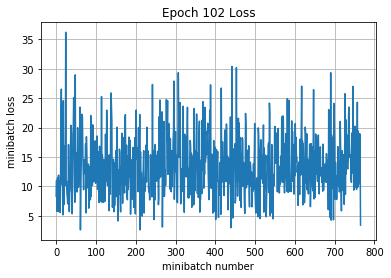

Iteration 78200: with minibatch training loss = 0.206 and accuracy of 0.95
Iteration 78300: with minibatch training loss = 0.27 and accuracy of 0.92
Iteration 78400: with minibatch training loss = 0.289 and accuracy of 0.91
Iteration 78500: with minibatch training loss = 0.31 and accuracy of 0.88
Iteration 78600: with minibatch training loss = 0.125 and accuracy of 0.95
Iteration 78700: with minibatch training loss = 0.39 and accuracy of 0.88
Iteration 78800: with minibatch training loss = 0.102 and accuracy of 0.97
Epoch 103, Overall loss = 0.212 and accuracy of 0.927


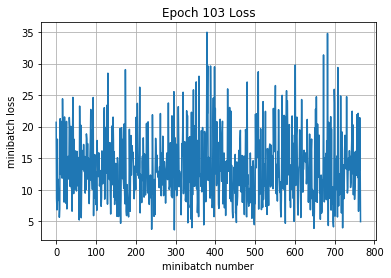

Iteration 78900: with minibatch training loss = 0.11 and accuracy of 0.95
Iteration 79000: with minibatch training loss = 0.236 and accuracy of 0.95
Iteration 79100: with minibatch training loss = 0.318 and accuracy of 0.92
Iteration 79200: with minibatch training loss = 0.298 and accuracy of 0.92
Iteration 79300: with minibatch training loss = 0.144 and accuracy of 0.97
Iteration 79400: with minibatch training loss = 0.181 and accuracy of 0.95
Iteration 79500: with minibatch training loss = 0.23 and accuracy of 0.89
Iteration 79600: with minibatch training loss = 0.167 and accuracy of 0.94
Epoch 104, Overall loss = 0.204 and accuracy of 0.929


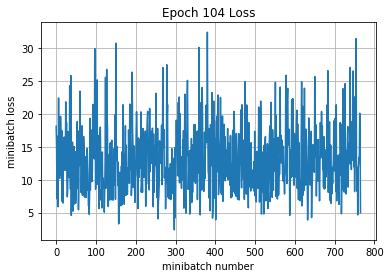

Iteration 79700: with minibatch training loss = 0.114 and accuracy of 0.97
Iteration 79800: with minibatch training loss = 0.17 and accuracy of 0.92
Iteration 79900: with minibatch training loss = 0.238 and accuracy of 0.94
Iteration 80000: with minibatch training loss = 0.129 and accuracy of 0.95
Iteration 80100: with minibatch training loss = 0.166 and accuracy of 0.92
Iteration 80200: with minibatch training loss = 0.173 and accuracy of 0.91
Iteration 80300: with minibatch training loss = 0.166 and accuracy of 0.95
Iteration 80400: with minibatch training loss = 0.192 and accuracy of 0.97
Epoch 105, Overall loss = 0.206 and accuracy of 0.929


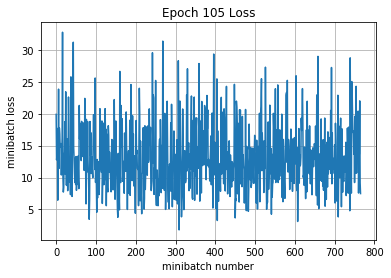

Iteration 80500: with minibatch training loss = 0.242 and accuracy of 0.92
Iteration 80600: with minibatch training loss = 0.262 and accuracy of 0.94
Iteration 80700: with minibatch training loss = 0.124 and accuracy of 0.95
Iteration 80800: with minibatch training loss = 0.258 and accuracy of 0.91
Iteration 80900: with minibatch training loss = 0.455 and accuracy of 0.91
Iteration 81000: with minibatch training loss = 0.227 and accuracy of 0.92
Iteration 81100: with minibatch training loss = 0.175 and accuracy of 0.94
Epoch 106, Overall loss = 0.203 and accuracy of 0.93


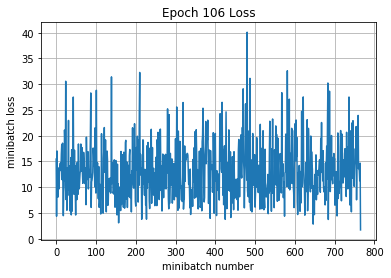

Iteration 81200: with minibatch training loss = 0.208 and accuracy of 0.94
Iteration 81300: with minibatch training loss = 0.134 and accuracy of 0.95
Iteration 81400: with minibatch training loss = 0.351 and accuracy of 0.84
Iteration 81500: with minibatch training loss = 0.178 and accuracy of 0.95
Iteration 81600: with minibatch training loss = 0.295 and accuracy of 0.89
Iteration 81700: with minibatch training loss = 0.145 and accuracy of 0.95
Iteration 81800: with minibatch training loss = 0.315 and accuracy of 0.86
Iteration 81900: with minibatch training loss = 0.116 and accuracy of 0.97
Epoch 107, Overall loss = 0.199 and accuracy of 0.93


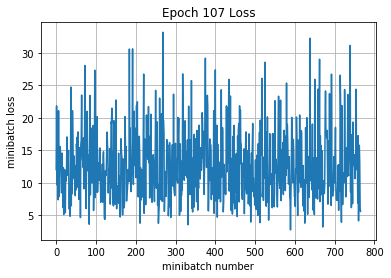

Iteration 82000: with minibatch training loss = 0.121 and accuracy of 0.97
Iteration 82100: with minibatch training loss = 0.132 and accuracy of 0.94
Iteration 82200: with minibatch training loss = 0.109 and accuracy of 0.95
Iteration 82300: with minibatch training loss = 0.317 and accuracy of 0.89
Iteration 82400: with minibatch training loss = 0.187 and accuracy of 0.97
Iteration 82500: with minibatch training loss = 0.141 and accuracy of 0.95
Iteration 82600: with minibatch training loss = 0.349 and accuracy of 0.86
Iteration 82700: with minibatch training loss = 0.157 and accuracy of 0.92
Epoch 108, Overall loss = 0.198 and accuracy of 0.932


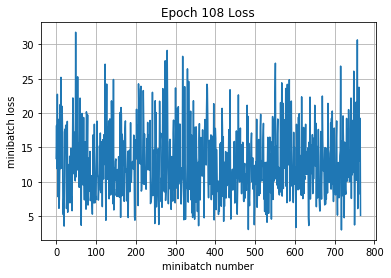

Iteration 82800: with minibatch training loss = 0.201 and accuracy of 0.92
Iteration 82900: with minibatch training loss = 0.0683 and accuracy of 0.98
Iteration 83000: with minibatch training loss = 0.197 and accuracy of 0.92
Iteration 83100: with minibatch training loss = 0.0957 and accuracy of 0.97
Iteration 83200: with minibatch training loss = 0.0738 and accuracy of 1
Iteration 83300: with minibatch training loss = 0.0837 and accuracy of 0.97
Iteration 83400: with minibatch training loss = 0.115 and accuracy of 0.97
Epoch 109, Overall loss = 0.196 and accuracy of 0.933


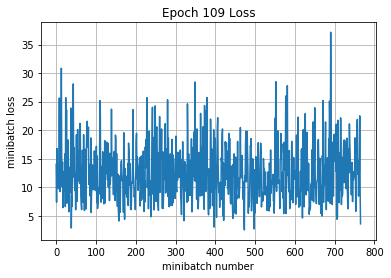

Iteration 83500: with minibatch training loss = 0.169 and accuracy of 0.95
Iteration 83600: with minibatch training loss = 0.261 and accuracy of 0.92
Iteration 83700: with minibatch training loss = 0.134 and accuracy of 0.95
Iteration 83800: with minibatch training loss = 0.165 and accuracy of 0.94
Iteration 83900: with minibatch training loss = 0.136 and accuracy of 0.95
Iteration 84000: with minibatch training loss = 0.137 and accuracy of 0.94
Iteration 84100: with minibatch training loss = 0.158 and accuracy of 0.95
Iteration 84200: with minibatch training loss = 0.176 and accuracy of 0.94
Epoch 110, Overall loss = 0.192 and accuracy of 0.934


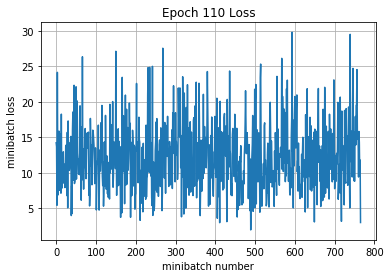

Iteration 84300: with minibatch training loss = 0.163 and accuracy of 0.97
Iteration 84400: with minibatch training loss = 0.156 and accuracy of 0.95
Iteration 84500: with minibatch training loss = 0.0964 and accuracy of 0.94
Iteration 84600: with minibatch training loss = 0.295 and accuracy of 0.91
Iteration 84700: with minibatch training loss = 0.254 and accuracy of 0.92
Iteration 84800: with minibatch training loss = 0.144 and accuracy of 0.95
Iteration 84900: with minibatch training loss = 0.305 and accuracy of 0.88
Iteration 85000: with minibatch training loss = 0.224 and accuracy of 0.88
Epoch 111, Overall loss = 0.195 and accuracy of 0.932


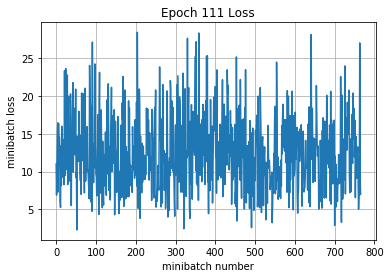

Iteration 85100: with minibatch training loss = 0.173 and accuracy of 0.94
Iteration 85200: with minibatch training loss = 0.259 and accuracy of 0.91
Iteration 85300: with minibatch training loss = 0.168 and accuracy of 0.94
Iteration 85400: with minibatch training loss = 0.166 and accuracy of 0.91
Iteration 85500: with minibatch training loss = 0.207 and accuracy of 0.92
Iteration 85600: with minibatch training loss = 0.19 and accuracy of 0.91
Iteration 85700: with minibatch training loss = 0.159 and accuracy of 0.94
Epoch 112, Overall loss = 0.194 and accuracy of 0.932


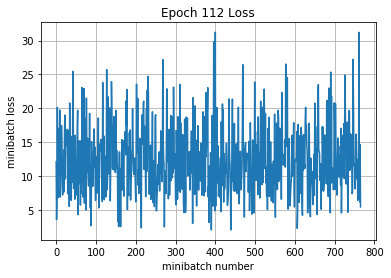

Iteration 85800: with minibatch training loss = 0.147 and accuracy of 0.94
Iteration 85900: with minibatch training loss = 0.167 and accuracy of 0.94
Iteration 86000: with minibatch training loss = 0.21 and accuracy of 0.89
Iteration 86100: with minibatch training loss = 0.171 and accuracy of 0.97
Iteration 86200: with minibatch training loss = 0.253 and accuracy of 0.94
Iteration 86300: with minibatch training loss = 0.319 and accuracy of 0.91
Iteration 86400: with minibatch training loss = 0.142 and accuracy of 0.95
Iteration 86500: with minibatch training loss = 0.316 and accuracy of 0.89
Epoch 113, Overall loss = 0.188 and accuracy of 0.934


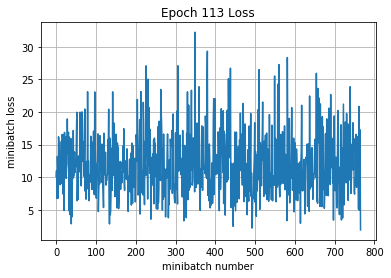

Iteration 86600: with minibatch training loss = 0.241 and accuracy of 0.91
Iteration 86700: with minibatch training loss = 0.15 and accuracy of 0.95
Iteration 86800: with minibatch training loss = 0.302 and accuracy of 0.89
Iteration 86900: with minibatch training loss = 0.146 and accuracy of 0.94
Iteration 87000: with minibatch training loss = 0.245 and accuracy of 0.94
Iteration 87100: with minibatch training loss = 0.26 and accuracy of 0.92
Iteration 87200: with minibatch training loss = 0.273 and accuracy of 0.89
Iteration 87300: with minibatch training loss = 0.0592 and accuracy of 1
Epoch 114, Overall loss = 0.187 and accuracy of 0.935


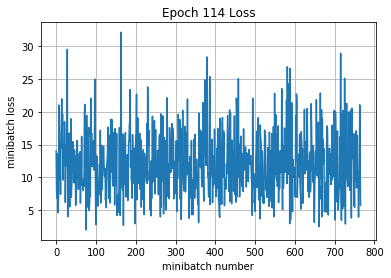

Iteration 87400: with minibatch training loss = 0.117 and accuracy of 0.95
Iteration 87500: with minibatch training loss = 0.136 and accuracy of 0.95
Iteration 87600: with minibatch training loss = 0.281 and accuracy of 0.91
Iteration 87700: with minibatch training loss = 0.196 and accuracy of 0.94
Iteration 87800: with minibatch training loss = 0.291 and accuracy of 0.94
Iteration 87900: with minibatch training loss = 0.161 and accuracy of 0.92
Iteration 88000: with minibatch training loss = 0.0864 and accuracy of 0.97
Epoch 115, Overall loss = 0.188 and accuracy of 0.935


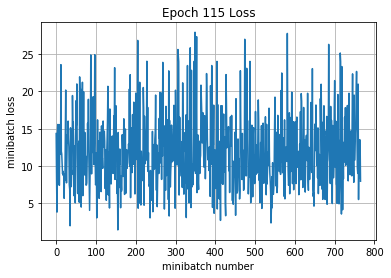

Iteration 88100: with minibatch training loss = 0.178 and accuracy of 0.95
Iteration 88200: with minibatch training loss = 0.331 and accuracy of 0.88
Iteration 88300: with minibatch training loss = 0.212 and accuracy of 0.94
Iteration 88400: with minibatch training loss = 0.283 and accuracy of 0.89
Iteration 88500: with minibatch training loss = 0.121 and accuracy of 0.94
Iteration 88600: with minibatch training loss = 0.209 and accuracy of 0.91
Iteration 88700: with minibatch training loss = 0.22 and accuracy of 0.95
Iteration 88800: with minibatch training loss = 0.147 and accuracy of 0.92
Epoch 116, Overall loss = 0.186 and accuracy of 0.936


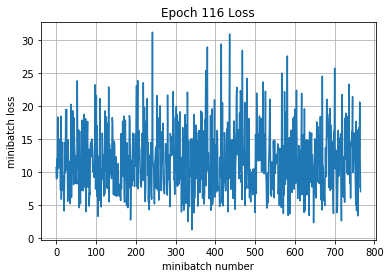

Iteration 88900: with minibatch training loss = 0.285 and accuracy of 0.94
Iteration 89000: with minibatch training loss = 0.201 and accuracy of 0.92
Iteration 89100: with minibatch training loss = 0.234 and accuracy of 0.91
Iteration 89200: with minibatch training loss = 0.198 and accuracy of 0.92
Iteration 89300: with minibatch training loss = 0.126 and accuracy of 0.94
Iteration 89400: with minibatch training loss = 0.157 and accuracy of 0.94
Iteration 89500: with minibatch training loss = 0.196 and accuracy of 0.94
Iteration 89600: with minibatch training loss = 0.172 and accuracy of 0.94
Epoch 117, Overall loss = 0.18 and accuracy of 0.937


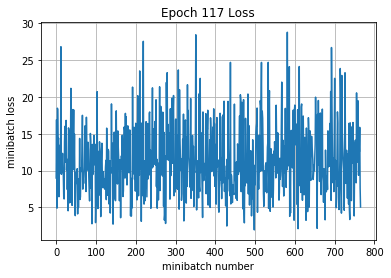

Iteration 89700: with minibatch training loss = 0.236 and accuracy of 0.92
Iteration 89800: with minibatch training loss = 0.214 and accuracy of 0.94
Iteration 89900: with minibatch training loss = 0.228 and accuracy of 0.92
Iteration 90000: with minibatch training loss = 0.461 and accuracy of 0.83
Iteration 90100: with minibatch training loss = 0.15 and accuracy of 0.92
Iteration 90200: with minibatch training loss = 0.163 and accuracy of 0.94
Iteration 90300: with minibatch training loss = 0.141 and accuracy of 0.98
Epoch 118, Overall loss = 0.185 and accuracy of 0.935


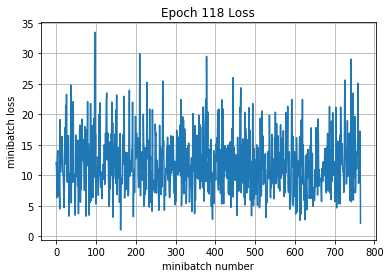

Iteration 90400: with minibatch training loss = 0.285 and accuracy of 0.91
Iteration 90500: with minibatch training loss = 0.128 and accuracy of 0.94
Iteration 90600: with minibatch training loss = 0.183 and accuracy of 0.94
Iteration 90700: with minibatch training loss = 0.304 and accuracy of 0.91
Iteration 90800: with minibatch training loss = 0.231 and accuracy of 0.91
Iteration 90900: with minibatch training loss = 0.132 and accuracy of 0.95
Iteration 91000: with minibatch training loss = 0.21 and accuracy of 0.92
Iteration 91100: with minibatch training loss = 0.118 and accuracy of 0.95
Epoch 119, Overall loss = 0.179 and accuracy of 0.938


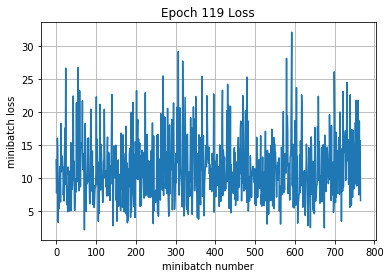

Iteration 91200: with minibatch training loss = 0.178 and accuracy of 0.94
Iteration 91300: with minibatch training loss = 0.15 and accuracy of 0.95
Iteration 91400: with minibatch training loss = 0.129 and accuracy of 0.92
Iteration 91500: with minibatch training loss = 0.254 and accuracy of 0.91
Iteration 91600: with minibatch training loss = 0.165 and accuracy of 0.95
Iteration 91700: with minibatch training loss = 0.138 and accuracy of 0.95
Iteration 91800: with minibatch training loss = 0.182 and accuracy of 0.95
Iteration 91900: with minibatch training loss = 0.256 and accuracy of 0.95
Epoch 120, Overall loss = 0.18 and accuracy of 0.937


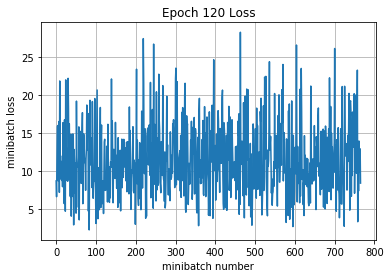

Iteration 92000: with minibatch training loss = 0.0464 and accuracy of 1
Iteration 92100: with minibatch training loss = 0.149 and accuracy of 0.94
Iteration 92200: with minibatch training loss = 0.439 and accuracy of 0.86
Iteration 92300: with minibatch training loss = 0.265 and accuracy of 0.91
Iteration 92400: with minibatch training loss = 0.272 and accuracy of 0.92
Iteration 92500: with minibatch training loss = 0.145 and accuracy of 0.95
Iteration 92600: with minibatch training loss = 0.117 and accuracy of 0.94
Epoch 121, Overall loss = 0.181 and accuracy of 0.938


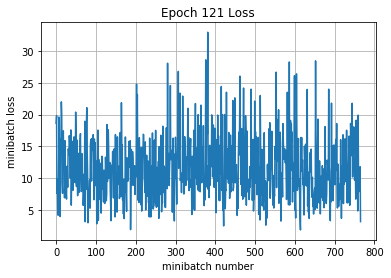

Iteration 92700: with minibatch training loss = 0.149 and accuracy of 0.97
Iteration 92800: with minibatch training loss = 0.218 and accuracy of 0.92
Iteration 92900: with minibatch training loss = 0.104 and accuracy of 0.98
Iteration 93000: with minibatch training loss = 0.271 and accuracy of 0.88
Iteration 93100: with minibatch training loss = 0.223 and accuracy of 0.92
Iteration 93200: with minibatch training loss = 0.201 and accuracy of 0.95
Iteration 93300: with minibatch training loss = 0.143 and accuracy of 0.95
Iteration 93400: with minibatch training loss = 0.255 and accuracy of 0.92
Epoch 122, Overall loss = 0.175 and accuracy of 0.941


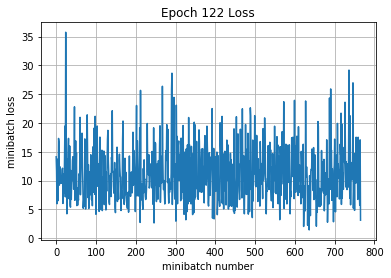

Iteration 93500: with minibatch training loss = 0.199 and accuracy of 0.94
Iteration 93600: with minibatch training loss = 0.175 and accuracy of 0.94
Iteration 93700: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 93800: with minibatch training loss = 0.166 and accuracy of 0.92
Iteration 93900: with minibatch training loss = 0.147 and accuracy of 0.92
Iteration 94000: with minibatch training loss = 0.0358 and accuracy of 0.98
Iteration 94100: with minibatch training loss = 0.12 and accuracy of 0.94
Iteration 94200: with minibatch training loss = 0.262 and accuracy of 0.91
Epoch 123, Overall loss = 0.177 and accuracy of 0.939


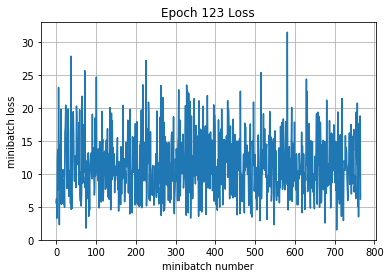

Iteration 94300: with minibatch training loss = 0.276 and accuracy of 0.91
Iteration 94400: with minibatch training loss = 0.152 and accuracy of 0.92
Iteration 94500: with minibatch training loss = 0.0973 and accuracy of 0.97
Iteration 94600: with minibatch training loss = 0.0622 and accuracy of 0.98
Iteration 94700: with minibatch training loss = 0.183 and accuracy of 0.95
Iteration 94800: with minibatch training loss = 0.24 and accuracy of 0.86
Iteration 94900: with minibatch training loss = 0.208 and accuracy of 0.91
Epoch 124, Overall loss = 0.174 and accuracy of 0.94


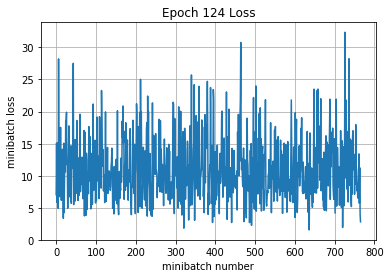

Iteration 95000: with minibatch training loss = 0.291 and accuracy of 0.92
Iteration 95100: with minibatch training loss = 0.211 and accuracy of 0.92
Iteration 95200: with minibatch training loss = 0.187 and accuracy of 0.95
Iteration 95300: with minibatch training loss = 0.12 and accuracy of 0.94
Iteration 95400: with minibatch training loss = 0.0529 and accuracy of 1
Iteration 95500: with minibatch training loss = 0.191 and accuracy of 0.95
Iteration 95600: with minibatch training loss = 0.229 and accuracy of 0.91
Iteration 95700: with minibatch training loss = 0.126 and accuracy of 0.95
Epoch 125, Overall loss = 0.171 and accuracy of 0.941


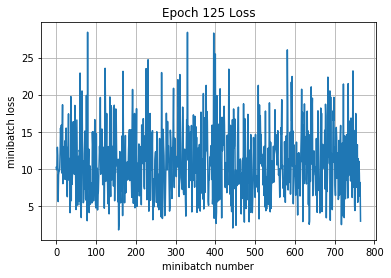

Iteration 95800: with minibatch training loss = 0.165 and accuracy of 0.94
Iteration 95900: with minibatch training loss = 0.305 and accuracy of 0.91
Iteration 96000: with minibatch training loss = 0.258 and accuracy of 0.89
Iteration 96100: with minibatch training loss = 0.306 and accuracy of 0.86
Iteration 96200: with minibatch training loss = 0.147 and accuracy of 0.95
Iteration 96300: with minibatch training loss = 0.214 and accuracy of 0.91
Iteration 96400: with minibatch training loss = 0.173 and accuracy of 0.94
Iteration 96500: with minibatch training loss = 0.169 and accuracy of 0.94
Epoch 126, Overall loss = 0.172 and accuracy of 0.941


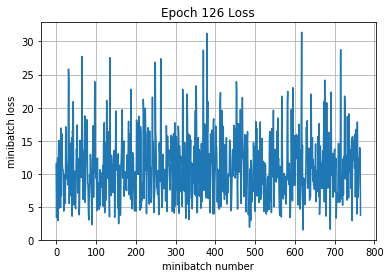

Iteration 96600: with minibatch training loss = 0.134 and accuracy of 0.97
Iteration 96700: with minibatch training loss = 0.338 and accuracy of 0.91
Iteration 96800: with minibatch training loss = 0.164 and accuracy of 0.94
Iteration 96900: with minibatch training loss = 0.235 and accuracy of 0.94
Iteration 97000: with minibatch training loss = 0.129 and accuracy of 0.95
Iteration 97100: with minibatch training loss = 0.0778 and accuracy of 0.98
Iteration 97200: with minibatch training loss = 0.114 and accuracy of 0.95
Epoch 127, Overall loss = 0.169 and accuracy of 0.941


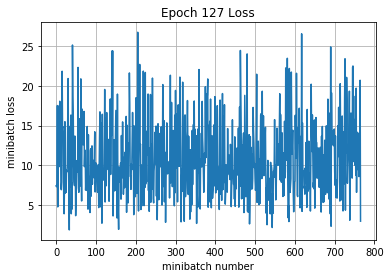

Iteration 97300: with minibatch training loss = 0.122 and accuracy of 0.98
Iteration 97400: with minibatch training loss = 0.231 and accuracy of 0.92
Iteration 97500: with minibatch training loss = 0.298 and accuracy of 0.94
Iteration 97600: with minibatch training loss = 0.229 and accuracy of 0.92
Iteration 97700: with minibatch training loss = 0.372 and accuracy of 0.83
Iteration 97800: with minibatch training loss = 0.156 and accuracy of 0.94
Iteration 97900: with minibatch training loss = 0.274 and accuracy of 0.91
Iteration 98000: with minibatch training loss = 0.171 and accuracy of 0.94
Epoch 128, Overall loss = 0.169 and accuracy of 0.942


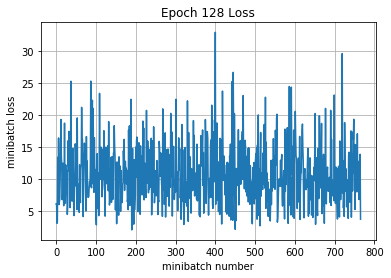

Iteration 98100: with minibatch training loss = 0.178 and accuracy of 0.92
Iteration 98200: with minibatch training loss = 0.1 and accuracy of 0.97
Iteration 98300: with minibatch training loss = 0.116 and accuracy of 0.92
Iteration 98400: with minibatch training loss = 0.303 and accuracy of 0.92
Iteration 98500: with minibatch training loss = 0.169 and accuracy of 0.94
Iteration 98600: with minibatch training loss = 0.168 and accuracy of 0.95
Iteration 98700: with minibatch training loss = 0.0939 and accuracy of 0.98
Iteration 98800: with minibatch training loss = 0.16 and accuracy of 0.94
Epoch 129, Overall loss = 0.162 and accuracy of 0.943


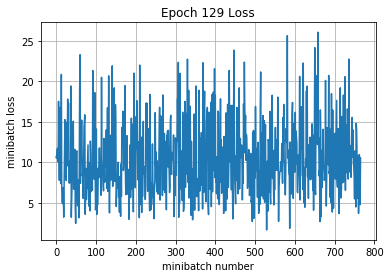

Iteration 98900: with minibatch training loss = 0.299 and accuracy of 0.89
Iteration 99000: with minibatch training loss = 0.241 and accuracy of 0.95
Iteration 99100: with minibatch training loss = 0.105 and accuracy of 0.98
Iteration 99200: with minibatch training loss = 0.193 and accuracy of 0.95
Iteration 99300: with minibatch training loss = 0.0946 and accuracy of 0.98
Iteration 99400: with minibatch training loss = 0.194 and accuracy of 0.91
Iteration 99500: with minibatch training loss = 0.149 and accuracy of 0.94
Epoch 130, Overall loss = 0.17 and accuracy of 0.942


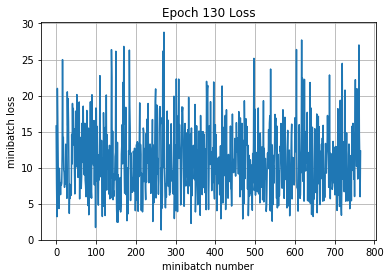

Iteration 99600: with minibatch training loss = 0.153 and accuracy of 0.95
Iteration 99700: with minibatch training loss = 0.21 and accuracy of 0.95
Iteration 99800: with minibatch training loss = 0.244 and accuracy of 0.94
Iteration 99900: with minibatch training loss = 0.101 and accuracy of 0.97
Iteration 100000: with minibatch training loss = 0.122 and accuracy of 0.95
Iteration 100100: with minibatch training loss = 0.24 and accuracy of 0.91
Iteration 100200: with minibatch training loss = 0.0862 and accuracy of 0.98
Iteration 100300: with minibatch training loss = 0.163 and accuracy of 0.95
Epoch 131, Overall loss = 0.164 and accuracy of 0.943


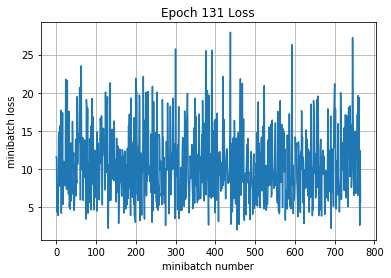

Iteration 100400: with minibatch training loss = 0.219 and accuracy of 0.95
Iteration 100500: with minibatch training loss = 0.09 and accuracy of 0.97
Iteration 100600: with minibatch training loss = 0.0554 and accuracy of 0.97
Iteration 100700: with minibatch training loss = 0.168 and accuracy of 0.95
Iteration 100800: with minibatch training loss = 0.238 and accuracy of 0.92
Iteration 100900: with minibatch training loss = 0.156 and accuracy of 0.94
Iteration 101000: with minibatch training loss = 0.109 and accuracy of 0.95
Iteration 101100: with minibatch training loss = 0.2 and accuracy of 0.94
Epoch 132, Overall loss = 0.158 and accuracy of 0.946


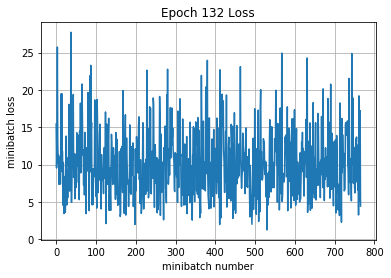

Iteration 101200: with minibatch training loss = 0.215 and accuracy of 0.92
Iteration 101300: with minibatch training loss = 0.157 and accuracy of 0.94
Iteration 101400: with minibatch training loss = 0.132 and accuracy of 0.94
Iteration 101500: with minibatch training loss = 0.243 and accuracy of 0.91
Iteration 101600: with minibatch training loss = 0.128 and accuracy of 0.94
Iteration 101700: with minibatch training loss = 0.15 and accuracy of 0.97
Iteration 101800: with minibatch training loss = 0.303 and accuracy of 0.91
Epoch 133, Overall loss = 0.159 and accuracy of 0.946


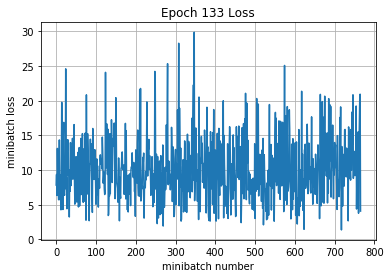

Iteration 101900: with minibatch training loss = 0.189 and accuracy of 0.94
Iteration 102000: with minibatch training loss = 0.164 and accuracy of 0.95
Iteration 102100: with minibatch training loss = 0.102 and accuracy of 0.98
Iteration 102200: with minibatch training loss = 0.12 and accuracy of 0.95
Iteration 102300: with minibatch training loss = 0.289 and accuracy of 0.89
Iteration 102400: with minibatch training loss = 0.162 and accuracy of 0.92
Iteration 102500: with minibatch training loss = 0.0993 and accuracy of 0.95
Iteration 102600: with minibatch training loss = 0.113 and accuracy of 0.95
Epoch 134, Overall loss = 0.163 and accuracy of 0.943


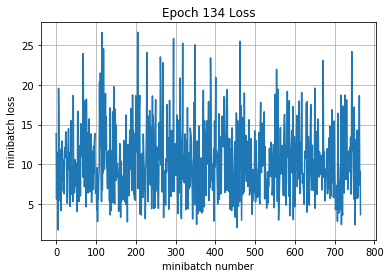

Iteration 102700: with minibatch training loss = 0.158 and accuracy of 0.94
Iteration 102800: with minibatch training loss = 0.0214 and accuracy of 1
Iteration 102900: with minibatch training loss = 0.158 and accuracy of 0.92
Iteration 103000: with minibatch training loss = 0.236 and accuracy of 0.94
Iteration 103100: with minibatch training loss = 0.124 and accuracy of 0.95
Iteration 103200: with minibatch training loss = 0.0968 and accuracy of 0.94
Iteration 103300: with minibatch training loss = 0.109 and accuracy of 0.97
Iteration 103400: with minibatch training loss = 0.108 and accuracy of 0.97
Epoch 135, Overall loss = 0.161 and accuracy of 0.944


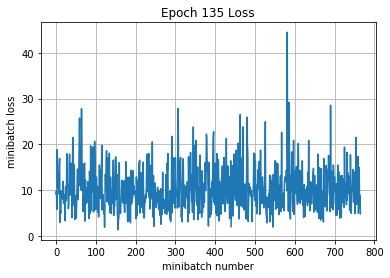

Iteration 103500: with minibatch training loss = 0.201 and accuracy of 0.92
Iteration 103600: with minibatch training loss = 0.121 and accuracy of 0.97
Iteration 103700: with minibatch training loss = 0.149 and accuracy of 0.95
Iteration 103800: with minibatch training loss = 0.133 and accuracy of 0.95
Iteration 103900: with minibatch training loss = 0.185 and accuracy of 0.91
Iteration 104000: with minibatch training loss = 0.0949 and accuracy of 0.97
Iteration 104100: with minibatch training loss = 0.25 and accuracy of 0.97
Epoch 136, Overall loss = 0.158 and accuracy of 0.945


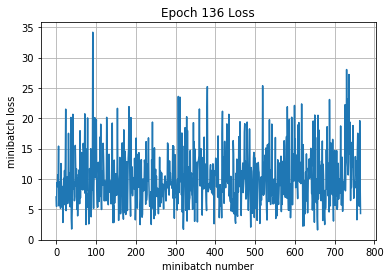

Iteration 104200: with minibatch training loss = 0.236 and accuracy of 0.92
Iteration 104300: with minibatch training loss = 0.191 and accuracy of 0.92
Iteration 104400: with minibatch training loss = 0.203 and accuracy of 0.91
Iteration 104500: with minibatch training loss = 0.144 and accuracy of 0.94
Iteration 104600: with minibatch training loss = 0.0728 and accuracy of 1
Iteration 104700: with minibatch training loss = 0.166 and accuracy of 0.94
Iteration 104800: with minibatch training loss = 0.125 and accuracy of 0.95
Iteration 104900: with minibatch training loss = 0.13 and accuracy of 0.94
Epoch 137, Overall loss = 0.159 and accuracy of 0.944


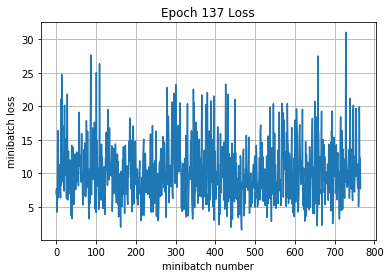

Iteration 105000: with minibatch training loss = 0.0746 and accuracy of 0.95
Iteration 105100: with minibatch training loss = 0.0964 and accuracy of 0.94
Iteration 105200: with minibatch training loss = 0.222 and accuracy of 0.94
Iteration 105300: with minibatch training loss = 0.0473 and accuracy of 1
Iteration 105400: with minibatch training loss = 0.203 and accuracy of 0.97
Iteration 105500: with minibatch training loss = 0.153 and accuracy of 0.94
Iteration 105600: with minibatch training loss = 0.264 and accuracy of 0.86
Iteration 105700: with minibatch training loss = 0.134 and accuracy of 0.95
Epoch 138, Overall loss = 0.154 and accuracy of 0.947


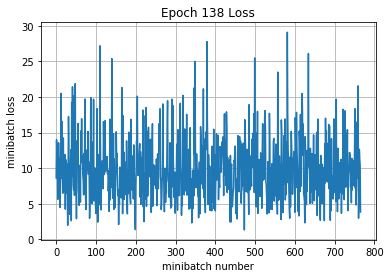

Iteration 105800: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 105900: with minibatch training loss = 0.158 and accuracy of 0.94
Iteration 106000: with minibatch training loss = 0.127 and accuracy of 0.97
Iteration 106100: with minibatch training loss = 0.252 and accuracy of 0.88
Iteration 106200: with minibatch training loss = 0.0861 and accuracy of 0.97
Iteration 106300: with minibatch training loss = 0.256 and accuracy of 0.92
Iteration 106400: with minibatch training loss = 0.261 and accuracy of 0.92
Epoch 139, Overall loss = 0.154 and accuracy of 0.947


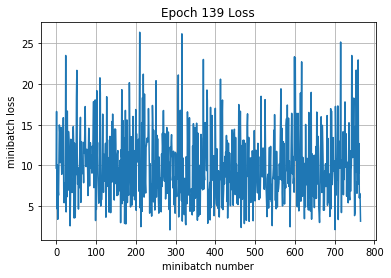

Iteration 106500: with minibatch training loss = 0.242 and accuracy of 0.89
Iteration 106600: with minibatch training loss = 0.151 and accuracy of 0.92
Iteration 106700: with minibatch training loss = 0.116 and accuracy of 0.94
Iteration 106800: with minibatch training loss = 0.0578 and accuracy of 0.98
Iteration 106900: with minibatch training loss = 0.0785 and accuracy of 0.98
Iteration 107000: with minibatch training loss = 0.165 and accuracy of 0.95
Iteration 107100: with minibatch training loss = 0.0566 and accuracy of 0.98
Iteration 107200: with minibatch training loss = 0.252 and accuracy of 0.89
Epoch 140, Overall loss = 0.151 and accuracy of 0.948


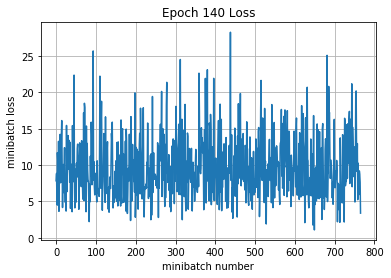

Iteration 107300: with minibatch training loss = 0.166 and accuracy of 0.97
Iteration 107400: with minibatch training loss = 0.137 and accuracy of 0.94
Iteration 107500: with minibatch training loss = 0.211 and accuracy of 0.94
Iteration 107600: with minibatch training loss = 0.154 and accuracy of 0.95
Iteration 107700: with minibatch training loss = 0.14 and accuracy of 0.94
Iteration 107800: with minibatch training loss = 0.179 and accuracy of 0.94
Iteration 107900: with minibatch training loss = 0.128 and accuracy of 0.95
Iteration 108000: with minibatch training loss = 0.114 and accuracy of 0.97
Epoch 141, Overall loss = 0.154 and accuracy of 0.946


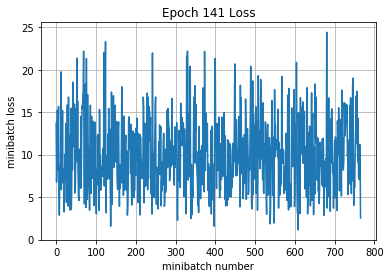

Iteration 108100: with minibatch training loss = 0.227 and accuracy of 0.95
Iteration 108200: with minibatch training loss = 0.0898 and accuracy of 0.98
Iteration 108300: with minibatch training loss = 0.127 and accuracy of 0.95
Iteration 108400: with minibatch training loss = 0.201 and accuracy of 0.94
Iteration 108500: with minibatch training loss = 0.12 and accuracy of 0.94
Iteration 108600: with minibatch training loss = 0.0885 and accuracy of 0.97
Iteration 108700: with minibatch training loss = 0.144 and accuracy of 0.92
Epoch 142, Overall loss = 0.156 and accuracy of 0.946


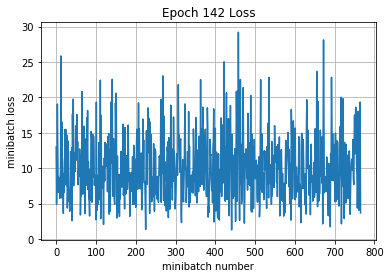

Iteration 108800: with minibatch training loss = 0.159 and accuracy of 0.94
Iteration 108900: with minibatch training loss = 0.159 and accuracy of 0.97
Iteration 109000: with minibatch training loss = 0.245 and accuracy of 0.92
Iteration 109100: with minibatch training loss = 0.242 and accuracy of 0.95
Iteration 109200: with minibatch training loss = 0.0875 and accuracy of 0.97
Iteration 109300: with minibatch training loss = 0.164 and accuracy of 0.97
Iteration 109400: with minibatch training loss = 0.164 and accuracy of 0.95
Iteration 109500: with minibatch training loss = 0.158 and accuracy of 0.95
Epoch 143, Overall loss = 0.153 and accuracy of 0.947


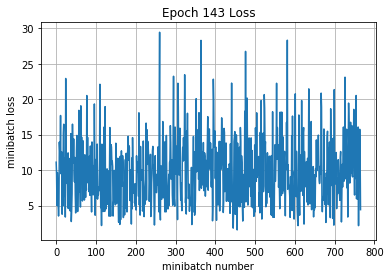

Iteration 109600: with minibatch training loss = 0.212 and accuracy of 0.92
Iteration 109700: with minibatch training loss = 0.091 and accuracy of 0.95
Iteration 109800: with minibatch training loss = 0.0616 and accuracy of 0.97
Iteration 109900: with minibatch training loss = 0.0314 and accuracy of 0.98
Iteration 110000: with minibatch training loss = 0.136 and accuracy of 0.95
Iteration 110100: with minibatch training loss = 0.12 and accuracy of 0.94
Iteration 110200: with minibatch training loss = 0.0767 and accuracy of 0.97
Iteration 110300: with minibatch training loss = 0.0663 and accuracy of 0.98
Epoch 144, Overall loss = 0.145 and accuracy of 0.951


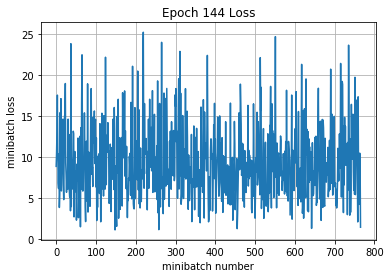

Iteration 110400: with minibatch training loss = 0.164 and accuracy of 0.94
Iteration 110500: with minibatch training loss = 0.126 and accuracy of 0.95
Iteration 110600: with minibatch training loss = 0.098 and accuracy of 0.95
Iteration 110700: with minibatch training loss = 0.38 and accuracy of 0.84
Iteration 110800: with minibatch training loss = 0.129 and accuracy of 0.94
Iteration 110900: with minibatch training loss = 0.0735 and accuracy of 0.98
Iteration 111000: with minibatch training loss = 0.141 and accuracy of 0.95
Epoch 145, Overall loss = 0.144 and accuracy of 0.949


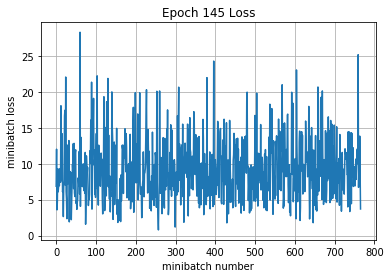

Iteration 111100: with minibatch training loss = 0.195 and accuracy of 0.94
Iteration 111200: with minibatch training loss = 0.403 and accuracy of 0.89
Iteration 111300: with minibatch training loss = 0.198 and accuracy of 0.94
Iteration 111400: with minibatch training loss = 0.306 and accuracy of 0.91
Iteration 111500: with minibatch training loss = 0.218 and accuracy of 0.92
Iteration 111600: with minibatch training loss = 0.0881 and accuracy of 0.98
Iteration 111700: with minibatch training loss = 0.0918 and accuracy of 0.97
Iteration 111800: with minibatch training loss = 0.142 and accuracy of 0.92
Epoch 146, Overall loss = 0.146 and accuracy of 0.95


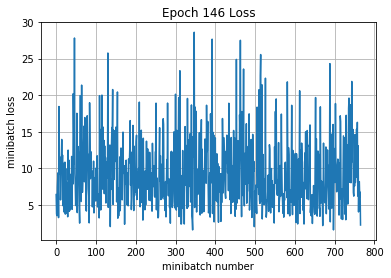

Iteration 111900: with minibatch training loss = 0.165 and accuracy of 0.94
Iteration 112000: with minibatch training loss = 0.149 and accuracy of 0.97
Iteration 112100: with minibatch training loss = 0.105 and accuracy of 0.97
Iteration 112200: with minibatch training loss = 0.129 and accuracy of 0.95
Iteration 112300: with minibatch training loss = 0.371 and accuracy of 0.89
Iteration 112400: with minibatch training loss = 0.16 and accuracy of 0.95
Iteration 112500: with minibatch training loss = 0.183 and accuracy of 0.94
Iteration 112600: with minibatch training loss = 0.269 and accuracy of 0.91
Epoch 147, Overall loss = 0.148 and accuracy of 0.948


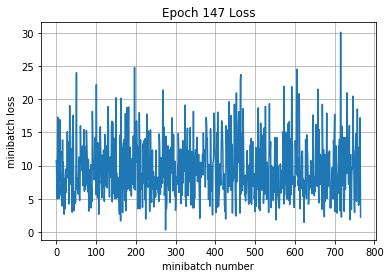

Iteration 112700: with minibatch training loss = 0.147 and accuracy of 0.94
Iteration 112800: with minibatch training loss = 0.326 and accuracy of 0.91
Iteration 112900: with minibatch training loss = 0.179 and accuracy of 0.94
Iteration 113000: with minibatch training loss = 0.196 and accuracy of 0.92
Iteration 113100: with minibatch training loss = 0.109 and accuracy of 0.95
Iteration 113200: with minibatch training loss = 0.0881 and accuracy of 0.97
Iteration 113300: with minibatch training loss = 0.197 and accuracy of 0.94
Epoch 148, Overall loss = 0.15 and accuracy of 0.949


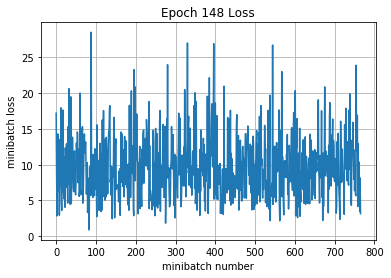

Iteration 113400: with minibatch training loss = 0.151 and accuracy of 0.92
Iteration 113500: with minibatch training loss = 0.101 and accuracy of 0.95
Iteration 113600: with minibatch training loss = 0.171 and accuracy of 0.91
Iteration 113700: with minibatch training loss = 0.0777 and accuracy of 0.98
Iteration 113800: with minibatch training loss = 0.156 and accuracy of 0.95
Iteration 113900: with minibatch training loss = 0.087 and accuracy of 0.98
Iteration 114000: with minibatch training loss = 0.0463 and accuracy of 0.98
Iteration 114100: with minibatch training loss = 0.21 and accuracy of 0.94
Epoch 149, Overall loss = 0.143 and accuracy of 0.949


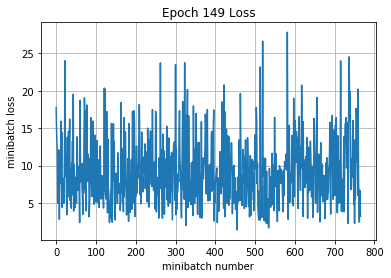

Iteration 114200: with minibatch training loss = 0.242 and accuracy of 0.92
Iteration 114300: with minibatch training loss = 0.13 and accuracy of 0.97
Iteration 114400: with minibatch training loss = 0.173 and accuracy of 0.94
Iteration 114500: with minibatch training loss = 0.167 and accuracy of 0.94
Iteration 114600: with minibatch training loss = 0.101 and accuracy of 0.97
Iteration 114700: with minibatch training loss = 0.0713 and accuracy of 0.97
Iteration 114800: with minibatch training loss = 0.146 and accuracy of 0.95
Epoch 150, Overall loss = 0.145 and accuracy of 0.951


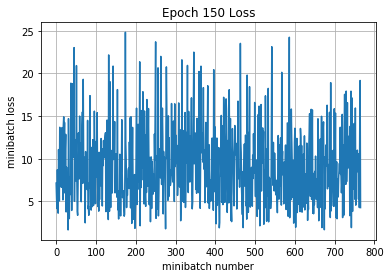

Iteration 114900: with minibatch training loss = 0.115 and accuracy of 0.95
Iteration 115000: with minibatch training loss = 0.0715 and accuracy of 0.98
Iteration 115100: with minibatch training loss = 0.198 and accuracy of 0.94
Iteration 115200: with minibatch training loss = 0.114 and accuracy of 0.97
Iteration 115300: with minibatch training loss = 0.257 and accuracy of 0.94
Iteration 115400: with minibatch training loss = 0.172 and accuracy of 0.92
Iteration 115500: with minibatch training loss = 0.14 and accuracy of 0.95
Iteration 115600: with minibatch training loss = 0.157 and accuracy of 0.94
Epoch 151, Overall loss = 0.141 and accuracy of 0.951


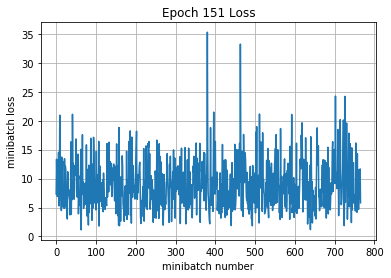

Iteration 115700: with minibatch training loss = 0.139 and accuracy of 0.95
Iteration 115800: with minibatch training loss = 0.106 and accuracy of 0.97
Iteration 115900: with minibatch training loss = 0.175 and accuracy of 0.94
Iteration 116000: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 116100: with minibatch training loss = 0.113 and accuracy of 0.94
Iteration 116200: with minibatch training loss = 0.14 and accuracy of 0.97
Iteration 116300: with minibatch training loss = 0.0651 and accuracy of 0.97
Iteration 116400: with minibatch training loss = 0.106 and accuracy of 0.97
Epoch 152, Overall loss = 0.141 and accuracy of 0.952


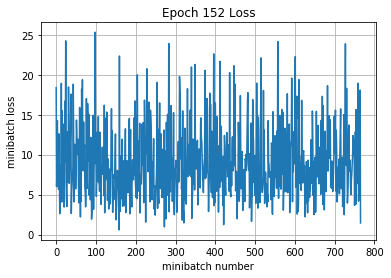

Iteration 116500: with minibatch training loss = 0.225 and accuracy of 0.94
Iteration 116600: with minibatch training loss = 0.175 and accuracy of 0.95
Iteration 116700: with minibatch training loss = 0.227 and accuracy of 0.92
Iteration 116800: with minibatch training loss = 0.0588 and accuracy of 0.98
Iteration 116900: with minibatch training loss = 0.179 and accuracy of 0.95
Iteration 117000: with minibatch training loss = 0.165 and accuracy of 0.97
Iteration 117100: with minibatch training loss = 0.101 and accuracy of 0.97
Epoch 153, Overall loss = 0.138 and accuracy of 0.953


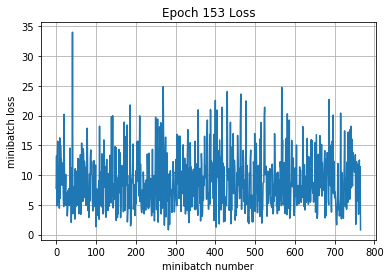

Iteration 117200: with minibatch training loss = 0.151 and accuracy of 0.97
Iteration 117300: with minibatch training loss = 0.0914 and accuracy of 0.98
Iteration 117400: with minibatch training loss = 0.245 and accuracy of 0.92
Iteration 117500: with minibatch training loss = 0.121 and accuracy of 0.95
Iteration 117600: with minibatch training loss = 0.0826 and accuracy of 0.95
Iteration 117700: with minibatch training loss = 0.0923 and accuracy of 0.95
Iteration 117800: with minibatch training loss = 0.0939 and accuracy of 0.95
Iteration 117900: with minibatch training loss = 0.14 and accuracy of 0.94
Epoch 154, Overall loss = 0.143 and accuracy of 0.951


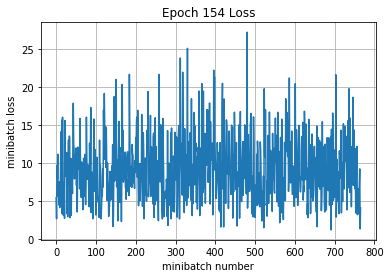

Iteration 118000: with minibatch training loss = 0.136 and accuracy of 0.94
Iteration 118100: with minibatch training loss = 0.109 and accuracy of 0.97
Iteration 118200: with minibatch training loss = 0.123 and accuracy of 0.97
Iteration 118300: with minibatch training loss = 0.116 and accuracy of 0.92
Iteration 118400: with minibatch training loss = 0.101 and accuracy of 0.97
Iteration 118500: with minibatch training loss = 0.0669 and accuracy of 1
Iteration 118600: with minibatch training loss = 0.0608 and accuracy of 0.97
Iteration 118700: with minibatch training loss = 0.264 and accuracy of 0.92
Epoch 155, Overall loss = 0.135 and accuracy of 0.953


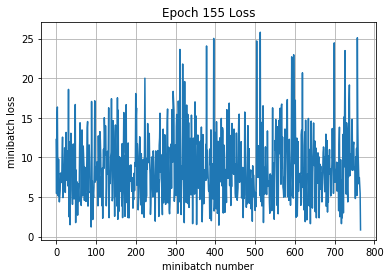

Iteration 118800: with minibatch training loss = 0.11 and accuracy of 0.95
Iteration 118900: with minibatch training loss = 0.0574 and accuracy of 0.97
Iteration 119000: with minibatch training loss = 0.143 and accuracy of 0.95
Iteration 119100: with minibatch training loss = 0.155 and accuracy of 0.95
Iteration 119200: with minibatch training loss = 0.0939 and accuracy of 0.97
Iteration 119300: with minibatch training loss = 0.105 and accuracy of 0.97
Iteration 119400: with minibatch training loss = 0.14 and accuracy of 0.95
Epoch 156, Overall loss = 0.142 and accuracy of 0.952


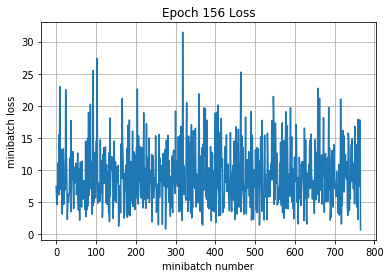

Iteration 119500: with minibatch training loss = 0.173 and accuracy of 0.94
Iteration 119600: with minibatch training loss = 0.161 and accuracy of 0.94
Iteration 119700: with minibatch training loss = 0.19 and accuracy of 0.92
Iteration 119800: with minibatch training loss = 0.151 and accuracy of 0.95
Iteration 119900: with minibatch training loss = 0.135 and accuracy of 0.97
Iteration 120000: with minibatch training loss = 0.181 and accuracy of 0.95
Iteration 120100: with minibatch training loss = 0.321 and accuracy of 0.92
Iteration 120200: with minibatch training loss = 0.0893 and accuracy of 0.97
Epoch 157, Overall loss = 0.137 and accuracy of 0.953


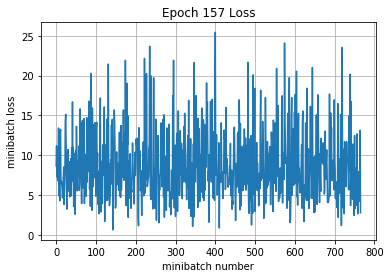

Iteration 120300: with minibatch training loss = 0.0388 and accuracy of 1
Iteration 120400: with minibatch training loss = 0.133 and accuracy of 0.97
Iteration 120500: with minibatch training loss = 0.264 and accuracy of 0.91
Iteration 120600: with minibatch training loss = 0.0857 and accuracy of 1
Iteration 120700: with minibatch training loss = 0.235 and accuracy of 0.94
Iteration 120800: with minibatch training loss = 0.12 and accuracy of 0.95
Iteration 120900: with minibatch training loss = 0.311 and accuracy of 0.94
Iteration 121000: with minibatch training loss = 0.0362 and accuracy of 0.98
Epoch 158, Overall loss = 0.137 and accuracy of 0.953


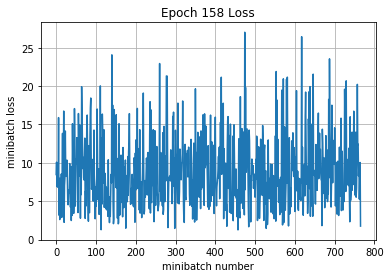

Iteration 121100: with minibatch training loss = 0.122 and accuracy of 0.98
Iteration 121200: with minibatch training loss = 0.0397 and accuracy of 0.98
Iteration 121300: with minibatch training loss = 0.19 and accuracy of 0.94
Iteration 121400: with minibatch training loss = 0.151 and accuracy of 0.94
Iteration 121500: with minibatch training loss = 0.0892 and accuracy of 0.97
Iteration 121600: with minibatch training loss = 0.0593 and accuracy of 0.98
Iteration 121700: with minibatch training loss = 0.0885 and accuracy of 0.95
Epoch 159, Overall loss = 0.139 and accuracy of 0.953


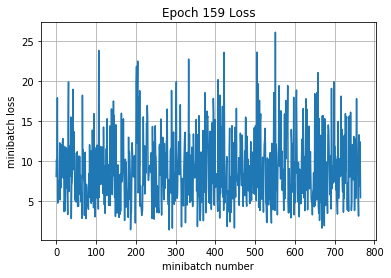

Iteration 121800: with minibatch training loss = 0.0991 and accuracy of 0.97
Iteration 121900: with minibatch training loss = 0.051 and accuracy of 0.98
Iteration 122000: with minibatch training loss = 0.0725 and accuracy of 0.97
Iteration 122100: with minibatch training loss = 0.0881 and accuracy of 0.97
Iteration 122200: with minibatch training loss = 0.155 and accuracy of 0.94
Iteration 122300: with minibatch training loss = 0.217 and accuracy of 0.91
Iteration 122400: with minibatch training loss = 0.149 and accuracy of 0.92
Iteration 122500: with minibatch training loss = 0.209 and accuracy of 0.95
Epoch 160, Overall loss = 0.135 and accuracy of 0.953


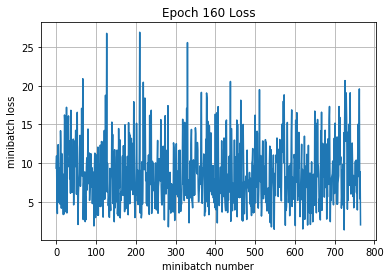

Iteration 122600: with minibatch training loss = 0.191 and accuracy of 0.95
Iteration 122700: with minibatch training loss = 0.165 and accuracy of 0.94
Iteration 122800: with minibatch training loss = 0.0746 and accuracy of 0.97
Iteration 122900: with minibatch training loss = 0.157 and accuracy of 0.94
Iteration 123000: with minibatch training loss = 0.131 and accuracy of 0.94
Iteration 123100: with minibatch training loss = 0.114 and accuracy of 0.95
Iteration 123200: with minibatch training loss = 0.0972 and accuracy of 0.97
Iteration 123300: with minibatch training loss = 0.0715 and accuracy of 0.97
Epoch 161, Overall loss = 0.132 and accuracy of 0.954


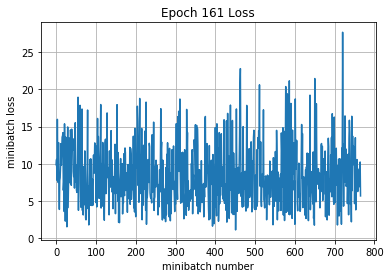

Iteration 123400: with minibatch training loss = 0.141 and accuracy of 0.95
Iteration 123500: with minibatch training loss = 0.166 and accuracy of 0.94
Iteration 123600: with minibatch training loss = 0.164 and accuracy of 0.95
Iteration 123700: with minibatch training loss = 0.16 and accuracy of 0.95
Iteration 123800: with minibatch training loss = 0.176 and accuracy of 0.95
Iteration 123900: with minibatch training loss = 0.163 and accuracy of 0.97
Iteration 124000: with minibatch training loss = 0.153 and accuracy of 0.92
Epoch 162, Overall loss = 0.133 and accuracy of 0.954


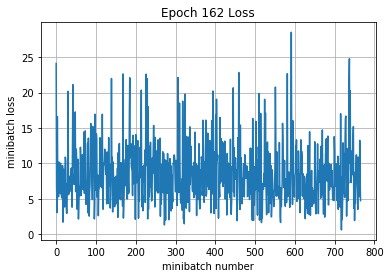

Iteration 124100: with minibatch training loss = 0.114 and accuracy of 0.95
Iteration 124200: with minibatch training loss = 0.0648 and accuracy of 0.98
Iteration 124300: with minibatch training loss = 0.191 and accuracy of 0.95
Iteration 124400: with minibatch training loss = 0.211 and accuracy of 0.94
Iteration 124500: with minibatch training loss = 0.0795 and accuracy of 0.97
Iteration 124600: with minibatch training loss = 0.209 and accuracy of 0.91
Iteration 124700: with minibatch training loss = 0.049 and accuracy of 0.98
Iteration 124800: with minibatch training loss = 0.125 and accuracy of 0.97
Epoch 163, Overall loss = 0.126 and accuracy of 0.956


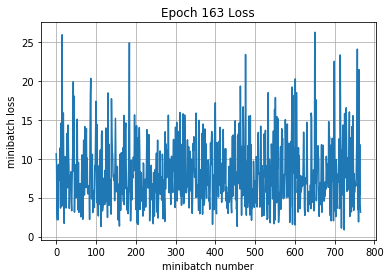

Iteration 124900: with minibatch training loss = 0.219 and accuracy of 0.89
Iteration 125000: with minibatch training loss = 0.122 and accuracy of 0.98
Iteration 125100: with minibatch training loss = 0.22 and accuracy of 0.92
Iteration 125200: with minibatch training loss = 0.0688 and accuracy of 0.98
Iteration 125300: with minibatch training loss = 0.28 and accuracy of 0.94
Iteration 125400: with minibatch training loss = 0.087 and accuracy of 0.98
Iteration 125500: with minibatch training loss = 0.191 and accuracy of 0.94
Iteration 125600: with minibatch training loss = 0.146 and accuracy of 0.98
Epoch 164, Overall loss = 0.135 and accuracy of 0.954


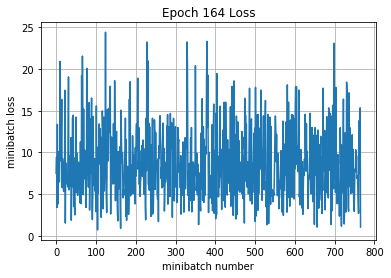

Iteration 125700: with minibatch training loss = 0.282 and accuracy of 0.91
Iteration 125800: with minibatch training loss = 0.209 and accuracy of 0.92
Iteration 125900: with minibatch training loss = 0.0874 and accuracy of 0.97
Iteration 126000: with minibatch training loss = 0.201 and accuracy of 0.92
Iteration 126100: with minibatch training loss = 0.452 and accuracy of 0.88
Iteration 126200: with minibatch training loss = 0.11 and accuracy of 0.94
Iteration 126300: with minibatch training loss = 0.139 and accuracy of 0.94
Epoch 165, Overall loss = 0.126 and accuracy of 0.956


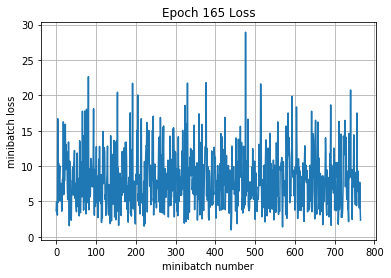

Iteration 126400: with minibatch training loss = 0.0352 and accuracy of 1
Iteration 126500: with minibatch training loss = 0.194 and accuracy of 0.94
Iteration 126600: with minibatch training loss = 0.0988 and accuracy of 0.97
Iteration 126700: with minibatch training loss = 0.0911 and accuracy of 0.97
Iteration 126800: with minibatch training loss = 0.11 and accuracy of 0.97
Iteration 126900: with minibatch training loss = 0.118 and accuracy of 0.95
Iteration 127000: with minibatch training loss = 0.311 and accuracy of 0.94
Iteration 127100: with minibatch training loss = 0.16 and accuracy of 0.95
Epoch 166, Overall loss = 0.127 and accuracy of 0.956


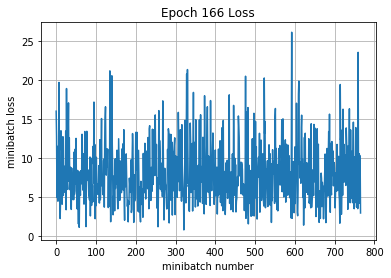

Iteration 127200: with minibatch training loss = 0.134 and accuracy of 0.94
Iteration 127300: with minibatch training loss = 0.162 and accuracy of 0.95
Iteration 127400: with minibatch training loss = 0.141 and accuracy of 0.95
Iteration 127500: with minibatch training loss = 0.119 and accuracy of 0.95
Iteration 127600: with minibatch training loss = 0.113 and accuracy of 0.95
Iteration 127700: with minibatch training loss = 0.101 and accuracy of 0.94
Iteration 127800: with minibatch training loss = 0.0731 and accuracy of 0.98
Iteration 127900: with minibatch training loss = 0.19 and accuracy of 0.95
Epoch 167, Overall loss = 0.129 and accuracy of 0.955


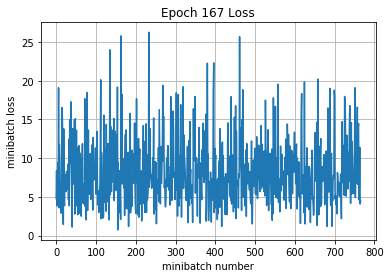

Iteration 128000: with minibatch training loss = 0.151 and accuracy of 0.92
Iteration 128100: with minibatch training loss = 0.0743 and accuracy of 0.97
Iteration 128200: with minibatch training loss = 0.153 and accuracy of 0.94
Iteration 128300: with minibatch training loss = 0.195 and accuracy of 0.92
Iteration 128400: with minibatch training loss = 0.138 and accuracy of 0.94
Iteration 128500: with minibatch training loss = 0.124 and accuracy of 0.97
Iteration 128600: with minibatch training loss = 0.123 and accuracy of 0.95
Epoch 168, Overall loss = 0.131 and accuracy of 0.955


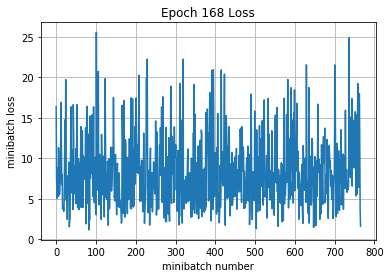

Iteration 128700: with minibatch training loss = 0.156 and accuracy of 0.95
Iteration 128800: with minibatch training loss = 0.0751 and accuracy of 0.97
Iteration 128900: with minibatch training loss = 0.208 and accuracy of 0.95
Iteration 129000: with minibatch training loss = 0.157 and accuracy of 0.94
Iteration 129100: with minibatch training loss = 0.133 and accuracy of 0.95
Iteration 129200: with minibatch training loss = 0.0479 and accuracy of 0.98
Iteration 129300: with minibatch training loss = 0.128 and accuracy of 0.95
Iteration 129400: with minibatch training loss = 0.138 and accuracy of 0.94
Epoch 169, Overall loss = 0.129 and accuracy of 0.955


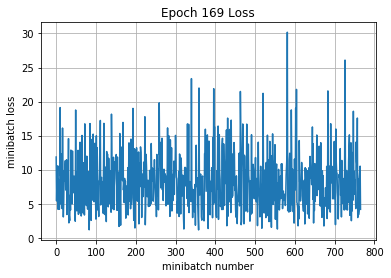

Iteration 129500: with minibatch training loss = 0.08 and accuracy of 0.98
Iteration 129600: with minibatch training loss = 0.0572 and accuracy of 0.98
Iteration 129700: with minibatch training loss = 0.0117 and accuracy of 1
Iteration 129800: with minibatch training loss = 0.0965 and accuracy of 0.97
Iteration 129900: with minibatch training loss = 0.148 and accuracy of 0.94
Iteration 130000: with minibatch training loss = 0.0819 and accuracy of 0.94
Iteration 130100: with minibatch training loss = 0.216 and accuracy of 0.92
Iteration 130200: with minibatch training loss = 0.254 and accuracy of 0.91
Epoch 170, Overall loss = 0.13 and accuracy of 0.955


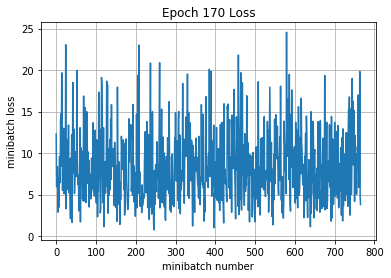

Iteration 130300: with minibatch training loss = 0.178 and accuracy of 0.97
Iteration 130400: with minibatch training loss = 0.094 and accuracy of 0.98
Iteration 130500: with minibatch training loss = 0.106 and accuracy of 0.97
Iteration 130600: with minibatch training loss = 0.486 and accuracy of 0.89
Iteration 130700: with minibatch training loss = 0.126 and accuracy of 0.94
Iteration 130800: with minibatch training loss = 0.0826 and accuracy of 0.98
Iteration 130900: with minibatch training loss = 0.142 and accuracy of 0.97
Epoch 171, Overall loss = 0.127 and accuracy of 0.956


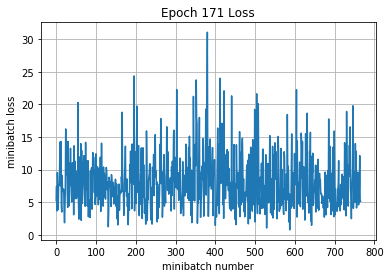

Iteration 131000: with minibatch training loss = 0.104 and accuracy of 0.97
Iteration 131100: with minibatch training loss = 0.201 and accuracy of 0.92
Iteration 131200: with minibatch training loss = 0.0657 and accuracy of 0.98
Iteration 131300: with minibatch training loss = 0.0986 and accuracy of 0.95
Iteration 131400: with minibatch training loss = 0.179 and accuracy of 0.95
Iteration 131500: with minibatch training loss = 0.187 and accuracy of 0.92
Iteration 131600: with minibatch training loss = 0.215 and accuracy of 0.97
Iteration 131700: with minibatch training loss = 0.189 and accuracy of 0.89
Epoch 172, Overall loss = 0.124 and accuracy of 0.957


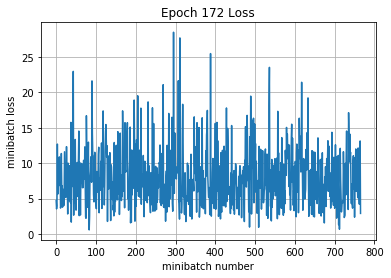

Iteration 131800: with minibatch training loss = 0.126 and accuracy of 0.98
Iteration 131900: with minibatch training loss = 0.211 and accuracy of 0.94
Iteration 132000: with minibatch training loss = 0.108 and accuracy of 0.95
Iteration 132100: with minibatch training loss = 0.194 and accuracy of 0.94
Iteration 132200: with minibatch training loss = 0.139 and accuracy of 0.95
Iteration 132300: with minibatch training loss = 0.0873 and accuracy of 0.97
Iteration 132400: with minibatch training loss = 0.111 and accuracy of 0.97
Iteration 132500: with minibatch training loss = 0.18 and accuracy of 0.94
Epoch 173, Overall loss = 0.121 and accuracy of 0.958


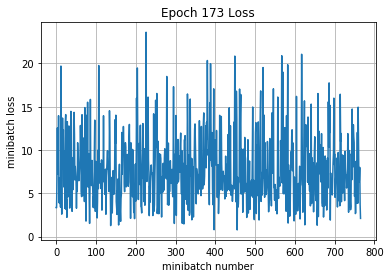

Iteration 132600: with minibatch training loss = 0.0668 and accuracy of 0.97
Iteration 132700: with minibatch training loss = 0.0707 and accuracy of 0.97
Iteration 132800: with minibatch training loss = 0.0962 and accuracy of 0.95
Iteration 132900: with minibatch training loss = 0.109 and accuracy of 0.97
Iteration 133000: with minibatch training loss = 0.119 and accuracy of 0.97
Iteration 133100: with minibatch training loss = 0.2 and accuracy of 0.95
Iteration 133200: with minibatch training loss = 0.17 and accuracy of 0.92
Epoch 174, Overall loss = 0.122 and accuracy of 0.957


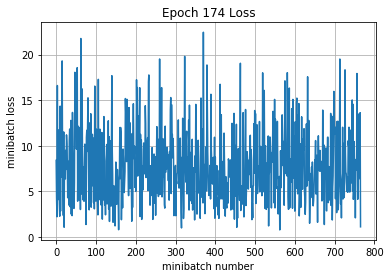

Iteration 133300: with minibatch training loss = 0.167 and accuracy of 0.95
Iteration 133400: with minibatch training loss = 0.0736 and accuracy of 0.98
Iteration 133500: with minibatch training loss = 0.0716 and accuracy of 0.97
Iteration 133600: with minibatch training loss = 0.198 and accuracy of 0.94
Iteration 133700: with minibatch training loss = 0.116 and accuracy of 0.97
Iteration 133800: with minibatch training loss = 0.116 and accuracy of 0.95
Iteration 133900: with minibatch training loss = 0.0761 and accuracy of 0.97
Iteration 134000: with minibatch training loss = 0.169 and accuracy of 0.92
Epoch 175, Overall loss = 0.128 and accuracy of 0.956


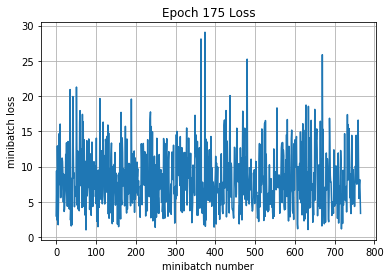

Iteration 134100: with minibatch training loss = 0.201 and accuracy of 0.95
Iteration 134200: with minibatch training loss = 0.0759 and accuracy of 0.98
Iteration 134300: with minibatch training loss = 0.224 and accuracy of 0.92
Iteration 134400: with minibatch training loss = 0.122 and accuracy of 0.95
Iteration 134500: with minibatch training loss = 0.163 and accuracy of 0.95
Iteration 134600: with minibatch training loss = 0.185 and accuracy of 0.94
Iteration 134700: with minibatch training loss = 0.0861 and accuracy of 0.98
Iteration 134800: with minibatch training loss = 0.0996 and accuracy of 0.95
Epoch 176, Overall loss = 0.126 and accuracy of 0.956


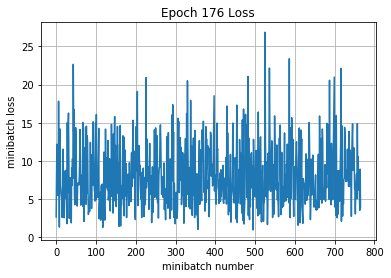

Iteration 134900: with minibatch training loss = 0.137 and accuracy of 0.95
Iteration 135000: with minibatch training loss = 0.0883 and accuracy of 0.98
Iteration 135100: with minibatch training loss = 0.0462 and accuracy of 0.98
Iteration 135200: with minibatch training loss = 0.0385 and accuracy of 1
Iteration 135300: with minibatch training loss = 0.201 and accuracy of 0.97
Iteration 135400: with minibatch training loss = 0.211 and accuracy of 0.92
Iteration 135500: with minibatch training loss = 0.0626 and accuracy of 0.98
Epoch 177, Overall loss = 0.122 and accuracy of 0.957


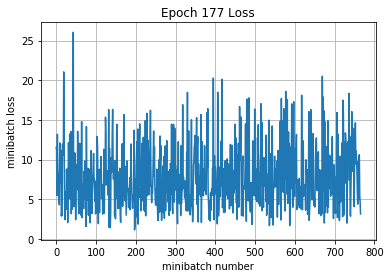

Iteration 135600: with minibatch training loss = 0.0665 and accuracy of 0.98
Iteration 135700: with minibatch training loss = 0.139 and accuracy of 0.95
Iteration 135800: with minibatch training loss = 0.107 and accuracy of 0.97
Iteration 135900: with minibatch training loss = 0.0809 and accuracy of 0.97
Iteration 136000: with minibatch training loss = 0.0876 and accuracy of 0.97
Iteration 136100: with minibatch training loss = 0.0339 and accuracy of 1
Iteration 136200: with minibatch training loss = 0.0265 and accuracy of 1
Iteration 136300: with minibatch training loss = 0.0595 and accuracy of 0.98
Epoch 178, Overall loss = 0.12 and accuracy of 0.958


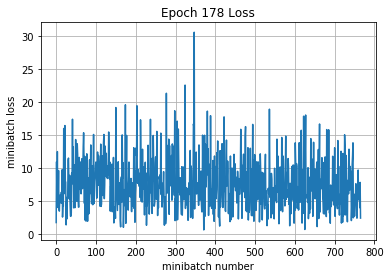

Iteration 136400: with minibatch training loss = 0.122 and accuracy of 0.97
Iteration 136500: with minibatch training loss = 0.242 and accuracy of 0.92
Iteration 136600: with minibatch training loss = 0.0668 and accuracy of 0.97
Iteration 136700: with minibatch training loss = 0.0895 and accuracy of 0.95
Iteration 136800: with minibatch training loss = 0.139 and accuracy of 0.95
Iteration 136900: with minibatch training loss = 0.149 and accuracy of 0.94
Iteration 137000: with minibatch training loss = 0.223 and accuracy of 0.92
Iteration 137100: with minibatch training loss = 0.199 and accuracy of 0.97
Epoch 179, Overall loss = 0.119 and accuracy of 0.959


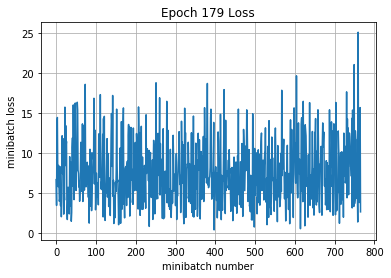

Iteration 137200: with minibatch training loss = 0.0721 and accuracy of 0.97
Iteration 137300: with minibatch training loss = 0.0722 and accuracy of 0.97
Iteration 137400: with minibatch training loss = 0.0516 and accuracy of 0.98
Iteration 137500: with minibatch training loss = 0.2 and accuracy of 0.91
Iteration 137600: with minibatch training loss = 0.18 and accuracy of 0.94
Iteration 137700: with minibatch training loss = 0.227 and accuracy of 0.91
Iteration 137800: with minibatch training loss = 0.127 and accuracy of 0.97
Epoch 180, Overall loss = 0.117 and accuracy of 0.96


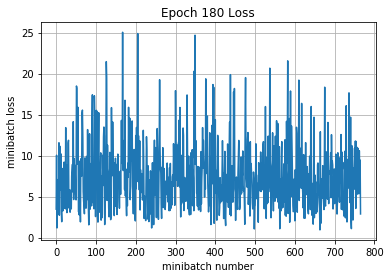

Iteration 137900: with minibatch training loss = 0.192 and accuracy of 0.94
Iteration 138000: with minibatch training loss = 0.0803 and accuracy of 0.98
Iteration 138100: with minibatch training loss = 0.0894 and accuracy of 0.98
Iteration 138200: with minibatch training loss = 0.146 and accuracy of 0.94
Iteration 138300: with minibatch training loss = 0.237 and accuracy of 0.91
Iteration 138400: with minibatch training loss = 0.0783 and accuracy of 0.98
Iteration 138500: with minibatch training loss = 0.0792 and accuracy of 0.97
Iteration 138600: with minibatch training loss = 0.0548 and accuracy of 0.98
Epoch 181, Overall loss = 0.123 and accuracy of 0.958


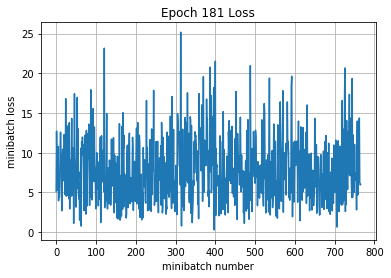

Iteration 138700: with minibatch training loss = 0.0505 and accuracy of 0.98
Iteration 138800: with minibatch training loss = 0.0406 and accuracy of 0.98
Iteration 138900: with minibatch training loss = 0.0316 and accuracy of 1
Iteration 139000: with minibatch training loss = 0.124 and accuracy of 0.94
Iteration 139100: with minibatch training loss = 0.0841 and accuracy of 0.97
Iteration 139200: with minibatch training loss = 0.0655 and accuracy of 0.98
Iteration 139300: with minibatch training loss = 0.127 and accuracy of 0.95
Iteration 139400: with minibatch training loss = 0.203 and accuracy of 0.92
Epoch 182, Overall loss = 0.118 and accuracy of 0.959


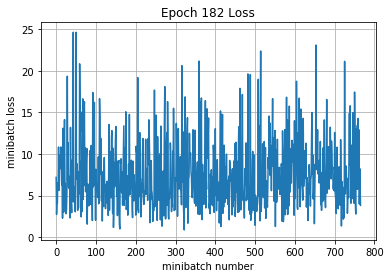

Iteration 139500: with minibatch training loss = 0.111 and accuracy of 0.97
Iteration 139600: with minibatch training loss = 0.139 and accuracy of 0.94
Iteration 139700: with minibatch training loss = 0.0641 and accuracy of 0.97
Iteration 139800: with minibatch training loss = 0.255 and accuracy of 0.92
Iteration 139900: with minibatch training loss = 0.0783 and accuracy of 0.97
Iteration 140000: with minibatch training loss = 0.0461 and accuracy of 0.98
Iteration 140100: with minibatch training loss = 0.198 and accuracy of 0.94
Epoch 183, Overall loss = 0.12 and accuracy of 0.959


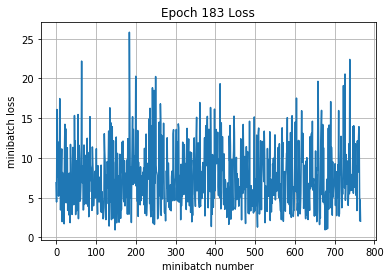

Iteration 140200: with minibatch training loss = 0.133 and accuracy of 0.94
Iteration 140300: with minibatch training loss = 0.136 and accuracy of 0.94
Iteration 140400: with minibatch training loss = 0.116 and accuracy of 0.94
Iteration 140500: with minibatch training loss = 0.0964 and accuracy of 0.97
Iteration 140600: with minibatch training loss = 0.156 and accuracy of 0.97
Iteration 140700: with minibatch training loss = 0.0938 and accuracy of 0.94
Iteration 140800: with minibatch training loss = 0.12 and accuracy of 0.92
Iteration 140900: with minibatch training loss = 0.067 and accuracy of 0.97
Epoch 184, Overall loss = 0.115 and accuracy of 0.96


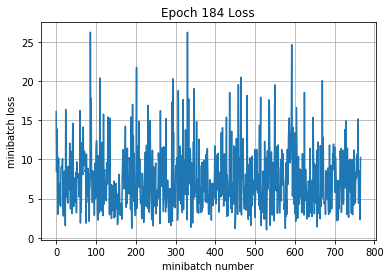

Iteration 141000: with minibatch training loss = 0.139 and accuracy of 0.95
Iteration 141100: with minibatch training loss = 0.0518 and accuracy of 0.98
Iteration 141200: with minibatch training loss = 0.137 and accuracy of 0.95
Iteration 141300: with minibatch training loss = 0.158 and accuracy of 0.97
Iteration 141400: with minibatch training loss = 0.225 and accuracy of 0.92
Iteration 141500: with minibatch training loss = 0.0222 and accuracy of 0.98
Iteration 141600: with minibatch training loss = 0.0454 and accuracy of 0.98
Iteration 141700: with minibatch training loss = 0.0747 and accuracy of 0.97
Epoch 185, Overall loss = 0.117 and accuracy of 0.96


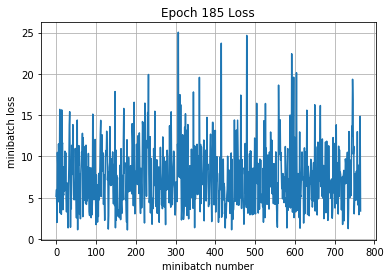

Iteration 141800: with minibatch training loss = 0.0866 and accuracy of 0.98
Iteration 141900: with minibatch training loss = 0.0893 and accuracy of 0.97
Iteration 142000: with minibatch training loss = 0.0548 and accuracy of 0.98
Iteration 142100: with minibatch training loss = 0.0203 and accuracy of 1
Iteration 142200: with minibatch training loss = 0.121 and accuracy of 0.97
Iteration 142300: with minibatch training loss = 0.149 and accuracy of 0.95
Iteration 142400: with minibatch training loss = 0.0714 and accuracy of 0.98
Epoch 186, Overall loss = 0.117 and accuracy of 0.959


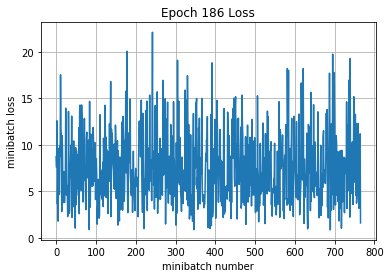

Iteration 142500: with minibatch training loss = 0.0969 and accuracy of 0.98
Iteration 142600: with minibatch training loss = 0.0254 and accuracy of 1
Iteration 142700: with minibatch training loss = 0.128 and accuracy of 0.95
Iteration 142800: with minibatch training loss = 0.147 and accuracy of 0.95
Iteration 142900: with minibatch training loss = 0.0784 and accuracy of 0.95
Iteration 143000: with minibatch training loss = 0.0755 and accuracy of 0.97
Iteration 143100: with minibatch training loss = 0.154 and accuracy of 0.97
Iteration 143200: with minibatch training loss = 0.167 and accuracy of 0.97
Epoch 187, Overall loss = 0.116 and accuracy of 0.961


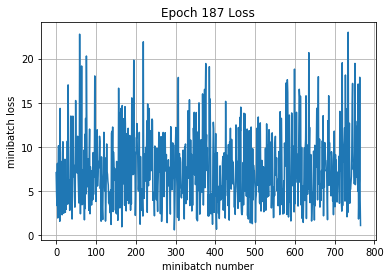

Iteration 143300: with minibatch training loss = 0.0969 and accuracy of 0.98
Iteration 143400: with minibatch training loss = 0.172 and accuracy of 0.92
Iteration 143500: with minibatch training loss = 0.0556 and accuracy of 0.97
Iteration 143600: with minibatch training loss = 0.078 and accuracy of 0.97
Iteration 143700: with minibatch training loss = 0.191 and accuracy of 0.89
Iteration 143800: with minibatch training loss = 0.155 and accuracy of 0.92
Iteration 143900: with minibatch training loss = 0.184 and accuracy of 0.92
Iteration 144000: with minibatch training loss = 0.066 and accuracy of 0.97
Epoch 188, Overall loss = 0.117 and accuracy of 0.96


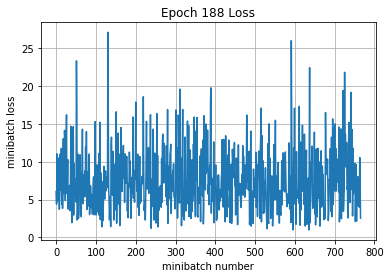

Iteration 144100: with minibatch training loss = 0.151 and accuracy of 0.94
Iteration 144200: with minibatch training loss = 0.109 and accuracy of 0.95
Iteration 144300: with minibatch training loss = 0.0473 and accuracy of 0.98
Iteration 144400: with minibatch training loss = 0.0993 and accuracy of 0.94
Iteration 144500: with minibatch training loss = 0.191 and accuracy of 0.92
Iteration 144600: with minibatch training loss = 0.187 and accuracy of 0.97
Iteration 144700: with minibatch training loss = 0.117 and accuracy of 0.95
Epoch 189, Overall loss = 0.115 and accuracy of 0.959


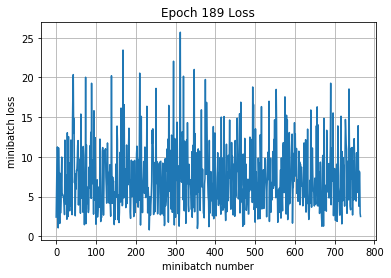

Iteration 144800: with minibatch training loss = 0.0488 and accuracy of 0.97
Iteration 144900: with minibatch training loss = 0.268 and accuracy of 0.95
Iteration 145000: with minibatch training loss = 0.293 and accuracy of 0.89
Iteration 145100: with minibatch training loss = 0.293 and accuracy of 0.92
Iteration 145200: with minibatch training loss = 0.0613 and accuracy of 0.98
Iteration 145300: with minibatch training loss = 0.236 and accuracy of 0.89
Iteration 145400: with minibatch training loss = 0.146 and accuracy of 0.94
Iteration 145500: with minibatch training loss = 0.205 and accuracy of 0.91
Epoch 190, Overall loss = 0.116 and accuracy of 0.959


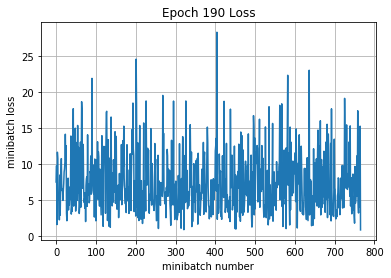

Iteration 145600: with minibatch training loss = 0.0599 and accuracy of 0.98
Iteration 145700: with minibatch training loss = 0.078 and accuracy of 0.97
Iteration 145800: with minibatch training loss = 0.147 and accuracy of 0.95
Iteration 145900: with minibatch training loss = 0.116 and accuracy of 0.95
Iteration 146000: with minibatch training loss = 0.141 and accuracy of 0.97
Iteration 146100: with minibatch training loss = 0.0917 and accuracy of 0.97
Iteration 146200: with minibatch training loss = 0.163 and accuracy of 0.95
Iteration 146300: with minibatch training loss = 0.0113 and accuracy of 1
Epoch 191, Overall loss = 0.113 and accuracy of 0.961


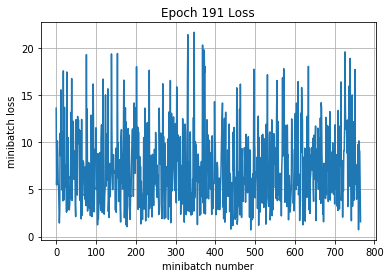

Iteration 146400: with minibatch training loss = 0.13 and accuracy of 0.98
Iteration 146500: with minibatch training loss = 0.0753 and accuracy of 0.97
Iteration 146600: with minibatch training loss = 0.0573 and accuracy of 1
Iteration 146700: with minibatch training loss = 0.132 and accuracy of 0.97
Iteration 146800: with minibatch training loss = 0.115 and accuracy of 0.95
Iteration 146900: with minibatch training loss = 0.0381 and accuracy of 0.97
Iteration 147000: with minibatch training loss = 0.0972 and accuracy of 0.97
Epoch 192, Overall loss = 0.111 and accuracy of 0.962


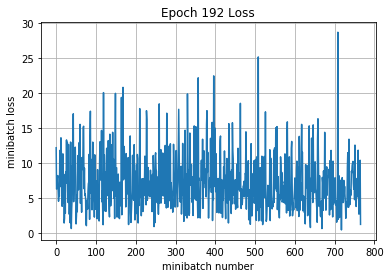

Iteration 147100: with minibatch training loss = 0.0278 and accuracy of 0.98
Iteration 147200: with minibatch training loss = 0.101 and accuracy of 0.97
Iteration 147300: with minibatch training loss = 0.101 and accuracy of 0.97
Iteration 147400: with minibatch training loss = 0.153 and accuracy of 0.95
Iteration 147500: with minibatch training loss = 0.114 and accuracy of 0.94
Iteration 147600: with minibatch training loss = 0.095 and accuracy of 0.95
Iteration 147700: with minibatch training loss = 0.0567 and accuracy of 0.97
Iteration 147800: with minibatch training loss = 0.0508 and accuracy of 1
Epoch 193, Overall loss = 0.111 and accuracy of 0.962


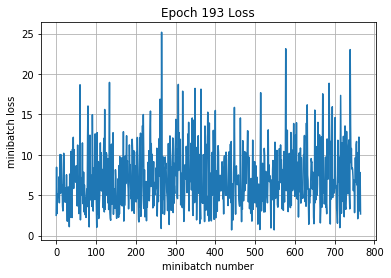

Iteration 147900: with minibatch training loss = 0.249 and accuracy of 0.94
Iteration 148000: with minibatch training loss = 0.0316 and accuracy of 1
Iteration 148100: with minibatch training loss = 0.102 and accuracy of 0.95
Iteration 148200: with minibatch training loss = 0.034 and accuracy of 1
Iteration 148300: with minibatch training loss = 0.197 and accuracy of 0.94
Iteration 148400: with minibatch training loss = 0.0328 and accuracy of 0.98
Iteration 148500: with minibatch training loss = 0.0449 and accuracy of 0.98
Iteration 148600: with minibatch training loss = 0.101 and accuracy of 0.97
Epoch 194, Overall loss = 0.112 and accuracy of 0.962


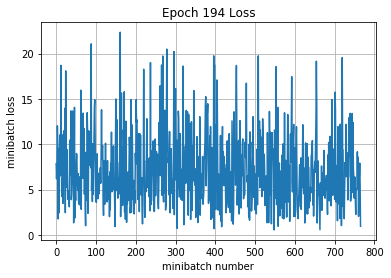

Iteration 148700: with minibatch training loss = 0.0355 and accuracy of 1
Iteration 148800: with minibatch training loss = 0.108 and accuracy of 0.94
Iteration 148900: with minibatch training loss = 0.0926 and accuracy of 0.97
Iteration 149000: with minibatch training loss = 0.206 and accuracy of 0.94
Iteration 149100: with minibatch training loss = 0.108 and accuracy of 0.95
Iteration 149200: with minibatch training loss = 0.0478 and accuracy of 0.98
Iteration 149300: with minibatch training loss = 0.0913 and accuracy of 0.97
Epoch 195, Overall loss = 0.111 and accuracy of 0.962


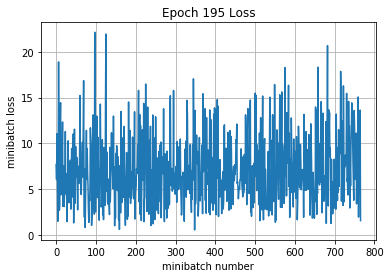

Iteration 149400: with minibatch training loss = 0.0594 and accuracy of 0.97
Iteration 149500: with minibatch training loss = 0.075 and accuracy of 0.97
Iteration 149600: with minibatch training loss = 0.24 and accuracy of 0.95
Iteration 149700: with minibatch training loss = 0.205 and accuracy of 0.95
Iteration 149800: with minibatch training loss = 0.221 and accuracy of 0.88
Iteration 149900: with minibatch training loss = 0.0684 and accuracy of 0.95
Iteration 150000: with minibatch training loss = 0.0248 and accuracy of 1
Iteration 150100: with minibatch training loss = 0.0608 and accuracy of 0.98
Epoch 196, Overall loss = 0.107 and accuracy of 0.962


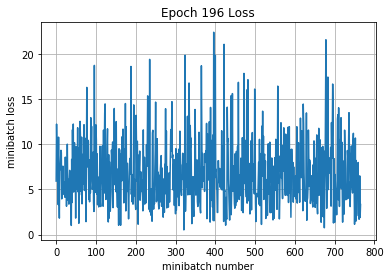

Iteration 150200: with minibatch training loss = 0.0919 and accuracy of 0.97
Iteration 150300: with minibatch training loss = 0.0856 and accuracy of 0.95
Iteration 150400: with minibatch training loss = 0.0617 and accuracy of 0.97
Iteration 150500: with minibatch training loss = 0.0779 and accuracy of 0.97
Iteration 150600: with minibatch training loss = 0.296 and accuracy of 0.92
Iteration 150700: with minibatch training loss = 0.179 and accuracy of 0.95
Iteration 150800: with minibatch training loss = 0.143 and accuracy of 0.97
Iteration 150900: with minibatch training loss = 0.132 and accuracy of 0.97
Epoch 197, Overall loss = 0.108 and accuracy of 0.962


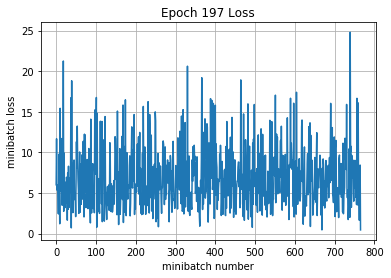

Iteration 151000: with minibatch training loss = 0.275 and accuracy of 0.91
Iteration 151100: with minibatch training loss = 0.0234 and accuracy of 0.98
Iteration 151200: with minibatch training loss = 0.2 and accuracy of 0.92
Iteration 151300: with minibatch training loss = 0.103 and accuracy of 0.97
Iteration 151400: with minibatch training loss = 0.0831 and accuracy of 0.97
Iteration 151500: with minibatch training loss = 0.117 and accuracy of 0.95
Iteration 151600: with minibatch training loss = 0.148 and accuracy of 0.94
Epoch 198, Overall loss = 0.109 and accuracy of 0.962


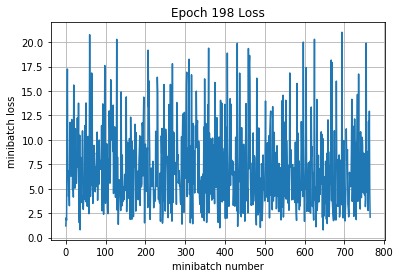

Iteration 151700: with minibatch training loss = 0.142 and accuracy of 0.95
Iteration 151800: with minibatch training loss = 0.202 and accuracy of 0.94
Iteration 151900: with minibatch training loss = 0.0687 and accuracy of 0.97
Iteration 152000: with minibatch training loss = 0.0481 and accuracy of 0.98
Iteration 152100: with minibatch training loss = 0.143 and accuracy of 0.97
Iteration 152200: with minibatch training loss = 0.271 and accuracy of 0.91
Iteration 152300: with minibatch training loss = 0.0759 and accuracy of 0.98
Iteration 152400: with minibatch training loss = 0.24 and accuracy of 0.92
Epoch 199, Overall loss = 0.107 and accuracy of 0.964


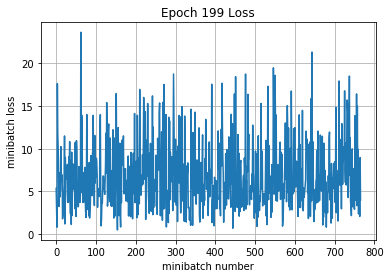

Iteration 152500: with minibatch training loss = 0.149 and accuracy of 0.95
Iteration 152600: with minibatch training loss = 0.149 and accuracy of 0.92
Iteration 152700: with minibatch training loss = 0.0114 and accuracy of 1
Iteration 152800: with minibatch training loss = 0.187 and accuracy of 0.95
Iteration 152900: with minibatch training loss = 0.0378 and accuracy of 1
Iteration 153000: with minibatch training loss = 0.0675 and accuracy of 0.97
Iteration 153100: with minibatch training loss = 0.138 and accuracy of 0.97
Epoch 200, Overall loss = 0.106 and accuracy of 0.963


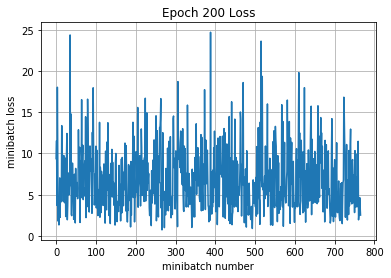

Validation
Epoch 1, Overall loss = 0.581 and accuracy of 0.869


(0.58129512429237362, 0.869)

In [22]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
def run_my_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, global_acc=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += float(np.sum(corr))
            global_acc = float(np.sum(corr))/actual_batch_size
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
#                 print (float(np.sum(corr))/actual_batch_size)
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,float(np.sum(corr))/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct


sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_my_model(sess,y_out,mean_loss,X_train,y_train,200,64,100,train_step, global_acc, True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [23]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.0135 and accuracy of 0.996
Validation
Epoch 1, Overall loss = 0.581 and accuracy of 0.869


(0.58129513978958125, 0.869)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_
conv - bn - conv - bn - max_pool - dropout - conv - bn - conv - bn - max_pool - dropout  - 5 residual_blockd - fc - bn - fc -bn - fc

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [24]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 0.596 and accuracy of 0.862


(0.59641151256561276, 0.8619)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

I used xavier initializer and learning rate decay on training accuracy